### This Loop is going to do a few things. Mainly, I am trying to save the Skill Scores of this NAO Model->Temp to look at how well it's performing.

I may tack on some of those bar plots from Mayer and Barnes (2021) here at the end. 

I will have a separate coding file to do LRP. 

In [31]:
%matplotlib inline
##so-called "math" related imports
from netCDF4 import Dataset as ncread
import numpy as np
from scipy.io import loadmat
import pandas as pd
import h5py
import math
from random import seed
from random import randint
from random import sample
from scipy.ndimage import gaussian_filter
from sklearn.metrics import brier_score_loss
import xarray as xr

import pickle

#plotting related imports
import matplotlib.pyplot as plt
from matplotlib import rcParams #For changing text properties
import cmocean #A package with beautiful colormaps
from cartopy import crs as ccrs #Useful for plotting maps
import cartopy.util #Requires separate import
from cartopy.util import add_cyclic_point
import cartopy.feature as cf
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import matplotlib.path as mpath
import matplotlib.colors as mcolors

##import tensorflow/keras related files
import tensorflow as tf    
#tf.compat.v1.disable_v2_behavior() # <-- HERE !

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import Input
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
import tensorflow.keras.backend as K
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dropout, Activation, Reshape, Flatten, LSTM, Dense, Dropout, Embedding, Bidirectional, GRU
from tensorflow.keras import Sequential
from tensorflow.keras import initializers, regularizers
from tensorflow.keras import optimizers
from tensorflow.keras import constraints
from tensorflow.keras.layers import Layer, InputSpec
from tensorflow.keras.callbacks import EarlyStopping

tf.compat.v1.disable_eager_execution()
import innvestigate

In [32]:
#import definitions from skill stat file
from SkillStats_MOD import BSS
from SkillStats_MOD import RAS_two
from SkillStats_MOD import PAS_two
from climoprobs import climo

import random
import sklearn

In [33]:
#inputs ... CHANGE FOR WHATEVER REGION YOU WANT TO LOOK AT 
infile = open("../data/1203_pv.p", 'rb') 
input = pickle.load(infile)
infile.close()

infile = open("../data/1203_classmedian_t.p", 'rb')
gph = pickle.load(infile)
infile.close()

#infile = open("../data/ANN/eur_climoprob_filt.p", 'rb')
#climo = pickle.load(infile)
#infile.close()

In [34]:
##checking shapes
print(input.shape)
print(gph.shape)

(63, 151, 11, 145)
(63, 151)


In [35]:
gph = gph.reshape(63,151)

In [36]:
##introduce tw-day time lag
gph_n = np.zeros((63,145))
input_n = np.zeros((63,145,11,145))

for i in range(63):
    for j in range(145):
        gph_n[i,j] = gph[i,j+6]
        input_n[i,j] = input[i,j,:,:] 

In [37]:
##Set X_all and Y_all datasets
X_all = np.copy(input_n.reshape(63*145,1595))
Y_all = np.copy(gph_n.reshape(63*145))

##training data partition out
X_tri = X_all[:59*145,:]
Y_tri = Y_all[:59*145]

#testing data partition out
X_tes = X_all[59*145:,:]
Y_tes = Y_all[59*145:]

#Convert the Y array into a categorical array. This means we will create one-hot vector labels for all of the inputs.
# The one-hot vectors have an index for each possible output category (two in our case)
# A "1" is put in the index corresponding to the category to which the sample belongs
Y_all = keras.utils.to_categorical(Y_all)
Y_tri = keras.utils.to_categorical(Y_tri)
Y_tes= keras.utils.to_categorical(Y_tes)

In [38]:
##checking my data for NaN of Infs because I need to make sure this doesn't cause
#the model to throw back no loss

if np.any(np.isnan(X_all)) or np.any(np.isinf(X_all)):
    print("NaN or Inf values found in X_all!")

if np.any(np.isnan(Y_all)) or np.any(np.isinf(Y_all)):
    print("NaN or Inf values found in Y_all!")

### Begin setting up parts of my model architecture.

The first few cells here are for partitioning data and setting up lists to save skill scores. 

In [39]:
##set fraction of data as 6 years
frac_ind = 145*6
frac_ind

870

In [40]:
##number of input nodes, (lat*lon)
numb_int = X_all.shape[-1]

In [41]:
##Loss and ACC lists, only relevant w/o early stopping
train_loss = []
val_loss = []
cat_acc = []
val_acc = []

In [42]:
##BSS Arrays, all of the skill scores have 200 rows
#because that is how many cross-validations I will do for the model
BSS_all= np.empty((100,2))
BSS_val= np.empty((100,2))
BSS_train= np.empty((100,2))
BSS_test= np.empty((100,2))

##RAS and PAS Arrays
Prec_all= np.empty((100,2))
Rec_all= np.empty((100,2))

Prec_val= np.empty((100,2))
Rec_val= np.empty((100,2))

Prec_train= np.empty((100,2))
Rec_train= np.empty((100,2))

Prec_test= np.empty((100,2))
Rec_test= np.empty((100,2))

In [43]:
####for LRP
comp_pos = np.empty((100,1595))
comp_neg = np.empty((100,1595))
compFpos = np.empty((100,1595))
compFneg = np.empty((100,1595))

pos90_LRP= np.empty((100,11,145))
neg90_LRP= np.empty((100,11,145))
Fpos90_LRP= np.empty((100,11,145))
Fneg90_LRP= np.empty((100,11,145))

In [44]:
##Testing Accuracy Arrays
fulltest_acc = []
test90_acc = []

##Training Accuracy Arrays
fulltrain_acc = []
train90_acc = []

##Validation Accuracy Arrays
fullval_acc = []
val90_acc = []

### Model architecture specifics start here.

In [45]:
###### batch, epochs, etc
batch_size = 256 #The number of samples the network sees before it backpropagates (batch size)
epochs = 50 #The number of times the network will loop through the entire dataset (epochs)
shuffle = True #Set whether to shuffle the training data so the model doesn't see it sequentially 
verbose = 2 #Set whether the model will output information when trained (0 = no output; 2 = output accuracy every epoch)

In [46]:
##class weight creator for the instance where now I have a four dimensional output array 
def class_weight_creator(Y):
    class_dict = {}
    Y_reshaped = Y.reshape(-1, Y.shape[-1])
    weights = np.max(np.sum(Y_reshaped, axis=0)) / np.sum(Y_reshaped, axis=0)
    for i in range(Y.shape[-1] ):
        class_dict[i] = weights[i]
        
    return class_dict

In [47]:
##DEFINITION STATEMENT FOR MODEL ITSELF
def basic_ANN(number_inputs,num_cats,n1,n2,rl1,rl2,learn,epochs):
    ##input tensor has the shape of the number of nodes, 777
    input_tensor = Input(shape=(int(number_inputs),))
    #first dense layer
    layer1 = layers.Dense(n1, activation='relu', use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2= rl1))(input_tensor)
    #second dense layer
    layer1 = layers.Dense(n2, activation='relu',use_bias=True,
                          kernel_initializer='he_normal',bias_initializer='he_normal',
                          kernel_regularizer=keras.regularizers.l2(l2=rl2))(layer1)
    #decay_rate = learn / epochs ###option for decaying learning rate
    #output layer with 2 categories
    output_tensor = layers.Dense(num_cats,activation='softmax')(layer1)
    model = Model(input_tensor, output_tensor)
    model.compile(optimizer=keras.optimizers.legacy.Adam(learning_rate=learn),
              loss = 'categorical_crossentropy', #Our loss function is based on categorical error
              metrics=[keras.metrics.categorical_accuracy], #We will print out the categorical accuracy as the network is trained
              )
    return model

In [48]:
##definition statement for ACC
def calculate_accuracy(y_true, y_prob, threshold=0.5):
    y_pred = (y_prob >= threshold).astype(int)
    return np.mean(y_true == y_pred)

In [49]:
##Early Stopping Condition, if desired
early_stopping = EarlyStopping(monitor='val_loss',patience=4,restore_best_weights=True,verbose=1)

In [50]:
##full dataset climo probabilities 
climo_full = climo(Y_all,63,145)

In [51]:
##create loop for cross validation
for l in range(0,100):
    ##randomly choose a fraction of events for validation and training
    start = random.randrange(len(X_tri[:,0])-frac_ind)
    end = start+(frac_ind)

    #choose random 6 year window of training data to be used for validation
    X_val = X_tri[start:end]
    Y_val = Y_tri[start:end]

    #remaining 53 years of training data
    X_train1 = X_tri[0:start]
    Y_train1 = Y_tri[0:start]
    X_train2 = X_tri[end:]
    Y_train2 = Y_tri[end:]

    climo_train1 = climo_full[0:start,:]
    climo_train2 = climo_full[end:59*145,:]

    ##concatenate all of these
    X_tr = np.concatenate((X_train1,X_train2))
    Y_tr = np.concatenate((Y_train1,Y_train2))
    
    climo_train = np.concatenate((climo_train1,climo_train2))
    
    ##calculate class weights on remaining training data
    class_weight = class_weight_creator(Y_tr)

    ##pause, calculate climo probabilities
    climo_val = climo_full[start:end,:]
    climo_test = climo_full[59*145:,:]

    ##initalize model
    #model = basic_ANN(numb_int, 2, 128, 8, 0.08, 0.07, 0.0025, epochs)
    model = basic_ANN(numb_int, 2, 135, 60, 0.049, 0.24, 0.0012, epochs)
    ##FIT the model

    model.fit(X_tr, Y_tr, validation_data=(X_val, Y_val),
              batch_size=batch_size, epochs=epochs, shuffle=shuffle,
              class_weight = class_weight, callbacks=[early_stopping])
    
    train_loss.append(model.history.history['loss'])
    val_loss.append(model.history.history['val_loss'])
    
    cat_acc.append(model.history.history['categorical_accuracy'])
    val_acc.append(model.history.history['val_categorical_accuracy'])
     
    pred = model.predict(X_all)
    pred_val = model.predict(X_val)
    pred_train = model.predict(X_tr)
    pred_test = model.predict(X_tes)
    ########################################################################################################
    ##STATISTICS CALCULATINNG
    pred_class = []
    predval_class = []
    predtr_class = []
    predtest_class = []
    ##BRIER SKILL SCORE
    BSS(l, start, end,
        climo_full, pred, Y_all, BSS_all,
        climo_val, pred_val, Y_val, BSS_val,
        climo_train, pred_train, Y_tr, BSS_train,
        climo_test, pred_test, Y_tes, BSS_test)
    ##RECALL ACCURACY SCORE    
    RAS_two(l, Rec_all, climo_full, Y_all, pred, pred_class,
            climo_val, Rec_val, Y_val, pred_val, predval_class,
            climo_train, Rec_train, Y_tr, pred_train, predtr_class,
            climo_test, Rec_test, Y_tes, pred_test, predtest_class)
    ##PRECISION ACCURACY SCORE     
    PAS_two(l, Prec_all, climo_full, Y_all, pred, pred_class,
            climo_val, Prec_val, Y_val, pred_val, predval_class,
            climo_train, Prec_train, Y_tr, pred_train, predtr_class,
            climo_test, Prec_test, Y_tes, pred_test, predtest_class)
    ########################################################################################################
    ##ACC
    ##TESTING
    q90 = np.percentile(pred_test,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_test) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    test90 = pred_test[great90]
    test90_norm = Y_tes[great90]
    test90_acc.append(calculate_accuracy(test90_norm, test90, threshold=0.5))
    ##full model
    fulltest_acc.append(calculate_accuracy(Y_tes, pred_test, threshold=0.5))

    ##TRAINING
    q90 = np.percentile(pred_train,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = [i for i, row in enumerate(pred_train) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    train90 = pred_train[great90]
    train90_norm = Y_tr[great90]
    train90_acc.append(calculate_accuracy(train90_norm, train90, threshold=0.5))
    ##full model
    fulltrain_acc.append(calculate_accuracy(Y_tr, pred_train, threshold=0.5))

    ##VALIDATION
    q90 = np.percentile(pred_val,90,axis=0) ##90th percentile of test
    ##90th percentile acc
    great90 = great90 = [i for i, row in enumerate(pred_val) if (row[0] > q90[0]) or (row[1] > q90[1])]
    # Create the arrays of probabilities and actual values that exceed the 90th percentile
    val90 = pred_val[great90]
    val90_norm = Y_val[great90]
    val90_acc.append(calculate_accuracy(val90_norm, val90, threshold=0.5))
    ##full model
    fullval_acc.append(calculate_accuracy(Y_val, pred_val, threshold=0.5))

    
    ########################################################################################################
    ##LRP
    # Creating an analyzer
    #model_wo_sm = innvestigate.model_wo_softmax(model)
    #gradient_analyzer = innvestigate.create_analyzer("deep_taylor", model_wo_sm)

    # Applying the analyzer
    #analysis = gradient_analyzer.analyze(X_tr)
    #tf.keras.backend.clear_session()

    #Convert the list to an array to make processing simpler and reshape it into a 2-D map (our inputs were vectorized)
    #LRP_heatmaps = analysis.reshape(analysis.shape[0], 21, 37)

    #Normalize each heatmap to have a maximum value of 1 so all samples can be compared equally
    #LRP_heatmaps_scaled = LRP_heatmaps/np.nanmax(LRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]

    #Now take the mean across all samples to make a composite...
    #LRP_heatmaps_mean = np.nanmean(LRP_heatmaps_scaled, axis=0)

    #LRP[l,:,:] = LRP_heatmaps_mean[:,:]

    ##I am going to transition right here into making separate LRP for the top 10% most confident and correct
    #predictions in the testing data 
    q90 = np.percentile(pred_test,90,axis=0) ##identify the threshold for the 90th percentile of confidence
    ##AS before with checking the threshold
    great90 = [i for i, row in enumerate(pred_test) if (row[0] > q90[0]) or (row[1] > q90[1])]
    
    ##classify the accuracy of predicitons
    correct_pos = [] #correct positive anomaly
    correct_neg = [] #correct negative anomaly
    
    false_pos = [] #false positive
    false_neg = [] #false negative
    
    for j in range(len(great90)):
        #print(j)
        #print(great90[j])
        index = great90[j]
        if pred_test[index,0] < pred_test[index,1] and Y_tes[index,0] == 0:
            correct_pos.append(index)
            #print('###########')
        elif pred_test[index,0] > pred_test[index,1] and Y_tes[index,0] == 1:
            correct_neg.append(index)
            #print('###########')
        elif pred_test[index,0] < pred_test[index,1] and Y_tes[index,0] == 1:
            false_neg.append(index)
            #print('###########')
        elif pred_test[index,0] > pred_test[index,1] and Y_tes[index,0] == 0:
            false_pos.append(index)
            #print('###########')
            
    # Creating an analyzer
    model_wo_sm = innvestigate.model_wo_softmax(model)
    gradient_analyzer = innvestigate.create_analyzer("deep_taylor", model_wo_sm)
    ##apply the analyzer to testing data
    ##correct positive
    posXtest = X_tes[correct_pos]
    comp_pos[l,:] = np.nanmean(posXtest,axis=0) #save for composite
    posXtest_grad = gradient_analyzer.analyze(posXtest)
    #false positive
    FposXtest = X_tes[false_pos]
    compFpos[l,:] = np.nanmean(FposXtest,axis=0) #save for composite
    FposXtest_grad = gradient_analyzer.analyze(FposXtest)
    #correct negative
    negXtest = X_tes[correct_neg]
    comp_neg[l,:] = np.nanmean(negXtest,axis=0) #save for composite
    negXtest_grad = gradient_analyzer.analyze(negXtest)
    #false negative
    FnegXtest = X_tes[false_neg]
    compFneg[l,:] = np.nanmean(FnegXtest,axis=0) #save for composite
    FnegXtest_grad = gradient_analyzer.analyze(FnegXtest)
    
    ###make heatmap
    ##CORRECT PLOTS
    pos = np.array(posXtest_grad)
    pos.reshape((len(posXtest_grad),1595))
    #Convert the list to an array to make processing simpler and reshape it into a 2-D map (our inputs were vectorized)
    posLRP_heatmaps = pos.reshape(pos.shape[0], 11, 145)
    posLRP_heatmaps_scaled = posLRP_heatmaps/np.nanmax(posLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
    posLRP_heatmaps_mean = np.nanmean(posLRP_heatmaps_scaled, axis=0)
    pos90_LRP[l,:,:] = posLRP_heatmaps_mean[:,:]
    
    neg = np.array(negXtest_grad )
    neg.reshape((len(negXtest_grad),1595))
    negLRP_heatmaps = neg.reshape(neg.shape[0], 11, 145)
    negLRP_heatmaps_scaled = negLRP_heatmaps/np.nanmax(negLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
    negLRP_heatmaps_mean = np.nanmean(negLRP_heatmaps_scaled, axis=0)
    neg90_LRP[l,:,:] = negLRP_heatmaps_mean[:,:]

    ###FALSE PLOTS
    Fpos = np.array(FposXtest_grad)
    Fpos.reshape((len(FposXtest_grad),1595))
    #Convert the list to an array to make processing simpler and reshape it into a 2-D map (our inputs were vectorized)
    FposLRP_heatmaps = Fpos.reshape(Fpos.shape[0], 11, 145)
    FposLRP_heatmaps_scaled = FposLRP_heatmaps/np.nanmax(FposLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
    FposLRP_heatmaps_mean = np.nanmean(FposLRP_heatmaps_scaled, axis=0)
    Fpos90_LRP[l,:,:] = FposLRP_heatmaps_mean[:,:]
    
    Fneg = np.array(FnegXtest_grad )
    Fneg.reshape((len(FnegXtest_grad),1595))
    FnegLRP_heatmaps = Fneg.reshape(Fneg.shape[0], 11, 145)
    FnegLRP_heatmaps_scaled = FnegLRP_heatmaps/np.nanmax(FnegLRP_heatmaps, axis=(-2,-1))[:,np.newaxis,np.newaxis]
    FnegLRP_heatmaps_mean = np.nanmean(FnegLRP_heatmaps_scaled, axis=0)
    Fneg90_LRP[l,:,:] = FnegLRP_heatmaps_mean[:,:]

Train on 7685 samples, validate on 870 samples
Epoch 1/50
6656/7685 [========================>.....] - ETA: 0s - loss: 33.0914 - categorical_accuracy: 0.5548

2024-12-04 21:01:11.473728: W tensorflow/c/c_api.cc:305] Operation '{name:'training_2/Adam/dense_5/bias/v/Assign' id:970 op device:{requested: '', assigned: ''} def:{{{node training_2/Adam/dense_5/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_2/Adam/dense_5/bias/v, training_2/Adam/dense_5/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7685/7685 [==============================] - 0s 30us/sample - loss: 31.7705 - categorical_accuracy: 0.5568 - val_loss: 21.5374 - val_categorical_accuracy: 0.5414
Epoch 2/50
7685/7685 [==============================] - 0s 17us/sample - loss: 16.2674 - categorical_accuracy: 0.5751 - val_loss: 11.6751 - val_categorical_accuracy: 0.5368
Epoch 3/50
7685/7685 [==============================] - 0s 18us/sample - loss: 9.1620 - categorical_accuracy: 0.5848 - val_loss: 6.8537 - val_categorical_accuracy: 0.5506
Epoch 4/50
7685/7685 [==============================] - 0s 18us/sample - loss: 5.4896 - categorical_accuracy: 0.5915 - val_loss: 4.2090 - val_categorical_accuracy: 0.5345
Epoch 5/50
7685/7685 [==============================] - 0s 19us/sample - loss: 3.4318 - categorical_accuracy: 0.5965 - val_loss: 2.6967 - val_categorical_accuracy: 0.5310
Epoch 6/50
7685/7685 [==============================] - 0s 18us/sample - loss: 2.2566 - categorical_accuracy: 0.5772 - val_loss: 1.8119 - val_categorica

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2359: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,
2024-12-04 21:01:14.589788: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_5/Softmax' id:652 op device:{requested: '', assigned: ''} def:{{{node dense_5/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_5/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:01:15.134242: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_1/Assign' id:1179 op device:{requested: '', assigned: ''} def:{{{node kernel_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](ke

Train on 7685 samples, validate on 870 samples
Epoch 1/50
6656/7685 [========================>.....] - ETA: 0s - loss: 32.6956 - categorical_accuracy: 0.5496

2024-12-04 21:01:15.842139: W tensorflow/c/c_api.cc:305] Operation '{name:'training_4/Adam/dense_8/kernel/m/Assign' id:1757 op device:{requested: '', assigned: ''} def:{{{node training_4/Adam/dense_8/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_4/Adam/dense_8/kernel/m, training_4/Adam/dense_8/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7685/7685 [==============================] - 0s 33us/sample - loss: 31.3682 - categorical_accuracy: 0.5533 - val_loss: 21.1016 - val_categorical_accuracy: 0.5356
Epoch 2/50
7685/7685 [==============================] - 0s 18us/sample - loss: 15.8324 - categorical_accuracy: 0.5830 - val_loss: 11.3039 - val_categorical_accuracy: 0.4908


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


Epoch 3/50
7685/7685 [==============================] - 0s 20us/sample - loss: 8.8708 - categorical_accuracy: 0.5771 - val_loss: 6.6392 - val_categorical_accuracy: 0.5322
Epoch 4/50
7685/7685 [==============================] - 0s 19us/sample - loss: 5.3025 - categorical_accuracy: 0.5871 - val_loss: 4.0748 - val_categorical_accuracy: 0.5080
Epoch 5/50
7685/7685 [==============================] - 0s 19us/sample - loss: 3.3376 - categorical_accuracy: 0.5701 - val_loss: 2.6104 - val_categorical_accuracy: 0.5057
Epoch 6/50
7685/7685 [==============================] - 0s 19us/sample - loss: 2.1590 - categorical_accuracy: 0.5856 - val_loss: 1.7448 - val_categorical_accuracy: 0.5195
Epoch 7/50
7685/7685 [==============================] - 0s 21us/sample - loss: 1.5034 - categorical_accuracy: 0.5793 - val_loss: 1.2664 - val_categorical_accuracy: 0.5299
Epoch 8/50
7685/7685 [==============================] - 0s 18us/sample - loss: 1.1359 - categorical_accuracy: 0.5835 - val_loss: 0.9999 - val_cat

2024-12-04 21:01:19.147457: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_9/Softmax' id:1488 op device:{requested: '', assigned: ''} def:{{{node dense_9/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_9/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:01:19.687006: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_13/Assign' id:2106 op device:{requested: '', assigned: ''} def:{{{node kernel_13/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_13, kernel_13/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.

Train on 7685 samples, validate on 870 samples
Epoch 1/50
3072/7685 [==========>...................] - ETA: 0s - loss: 39.3884 - categorical_accuracy: 0.5404

2024-12-04 21:01:20.701094: W tensorflow/c/c_api.cc:305] Operation '{name:'training_6/Adam/dense_12/bias/m/Assign' id:2598 op device:{requested: '', assigned: ''} def:{{{node training_6/Adam/dense_12/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_6/Adam/dense_12/bias/m, training_6/Adam/dense_12/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7685/7685 [==============================] - 0s 48us/sample - loss: 33.1584 - categorical_accuracy: 0.5519 - val_loss: 23.1203 - val_categorical_accuracy: 0.5069
Epoch 2/50
5120/7685 [==================>...........] - ETA: 0s - loss: 19.1342 - categorical_accuracy: 0.5781

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 0s 26us/sample - loss: 17.4528 - categorical_accuracy: 0.5849 - val_loss: 12.4829 - val_categorical_accuracy: 0.5253
Epoch 3/50
7685/7685 [==============================] - 0s 26us/sample - loss: 9.6993 - categorical_accuracy: 0.5810 - val_loss: 7.1985 - val_categorical_accuracy: 0.4966
Epoch 4/50
7685/7685 [==============================] - 0s 28us/sample - loss: 5.7372 - categorical_accuracy: 0.5869 - val_loss: 4.3725 - val_categorical_accuracy: 0.5184
Epoch 5/50
7685/7685 [==============================] - 0s 27us/sample - loss: 3.5286 - categorical_accuracy: 0.5948 - val_loss: 2.7638 - val_categorical_accuracy: 0.5069
Epoch 6/50
7685/7685 [==============================] - 0s 32us/sample - loss: 2.2858 - categorical_accuracy: 0.5906 - val_loss: 1.8456 - val_categorical_accuracy: 0.5103
Epoch 7/50
7685/7685 [==============================] - 0s 28us/sample - loss: 1.5770 - categorical_accuracy: 0.5918 - val_loss: 1.3269 - val_categorical_

2024-12-04 21:01:25.125702: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_13/Softmax' id:2324 op device:{requested: '', assigned: ''} def:{{{node dense_13/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_13/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:01:25.675117: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_19/Assign' id:2928 op device:{requested: '', assigned: ''} def:{{{node kernel_19/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_19, kernel_19/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7685 samples, validate on 870 samples
Epoch 1/50
3584/7685 [============>.................] - ETA: 0s - loss: 37.5752 - categorical_accuracy: 0.5377

2024-12-04 21:01:26.717043: W tensorflow/c/c_api.cc:305] Operation '{name:'training_8/Adam/dense_16/kernel/v/Assign' id:3463 op device:{requested: '', assigned: ''} def:{{{node training_8/Adam/dense_16/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_8/Adam/dense_16/kernel/v, training_8/Adam/dense_16/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7685/7685 [==============================] - 0s 39us/sample - loss: 32.0881 - categorical_accuracy: 0.5455 - val_loss: 22.1127 - val_categorical_accuracy: 0.5701
Epoch 2/50
6400/7685 [=======================>......] - ETA: 0s - loss: 17.6221 - categorical_accuracy: 0.5681

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 0s 19us/sample - loss: 16.8524 - categorical_accuracy: 0.5699 - val_loss: 12.0603 - val_categorical_accuracy: 0.6034
Epoch 3/50
7685/7685 [==============================] - 0s 19us/sample - loss: 9.4413 - categorical_accuracy: 0.5849 - val_loss: 6.9941 - val_categorical_accuracy: 0.6057
Epoch 4/50
7685/7685 [==============================] - 0s 20us/sample - loss: 5.5937 - categorical_accuracy: 0.5910 - val_loss: 4.2879 - val_categorical_accuracy: 0.5379
Epoch 5/50
7685/7685 [==============================] - 0s 19us/sample - loss: 3.4799 - categorical_accuracy: 0.5872 - val_loss: 2.6944 - val_categorical_accuracy: 0.5977
Epoch 6/50
7685/7685 [==============================] - 0s 20us/sample - loss: 2.2595 - categorical_accuracy: 0.5901 - val_loss: 1.7911 - val_categorical_accuracy: 0.6080
Epoch 7/50
7685/7685 [==============================] - 0s 18us/sample - loss: 1.5709 - categorical_accuracy: 0.5761 - val_loss: 1.2902 - val_categorical_

2024-12-04 21:01:29.981514: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_17/Softmax' id:3160 op device:{requested: '', assigned: ''} def:{{{node dense_17/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_17/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:01:30.573076: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_23/Assign' id:3700 op device:{requested: '', assigned: ''} def:{{{node kernel_23/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_23, kernel_23/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7685 samples, validate on 870 samples
Epoch 1/50
3328/7685 [===========>..................] - ETA: 0s - loss: 38.4770 - categorical_accuracy: 0.5457

2024-12-04 21:01:31.839331: W tensorflow/c/c_api.cc:305] Operation '{name:'training_10/Adam/dense_20/kernel/m/Assign' id:4265 op device:{requested: '', assigned: ''} def:{{{node training_10/Adam/dense_20/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_10/Adam/dense_20/kernel/m, training_10/Adam/dense_20/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7685/7685 [==============================] - 0s 40us/sample - loss: 32.4170 - categorical_accuracy: 0.5542 - val_loss: 22.1460 - val_categorical_accuracy: 0.5678
Epoch 2/50
3584/7685 [============>.................] - ETA: 0s - loss: 19.3508 - categorical_accuracy: 0.5915

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 0s 17us/sample - loss: 16.6391 - categorical_accuracy: 0.5905 - val_loss: 11.8612 - val_categorical_accuracy: 0.5207
Epoch 3/50
7685/7685 [==============================] - 0s 18us/sample - loss: 9.2689 - categorical_accuracy: 0.5904 - val_loss: 6.8855 - val_categorical_accuracy: 0.5701
Epoch 4/50
7685/7685 [==============================] - 0s 17us/sample - loss: 5.5412 - categorical_accuracy: 0.5787 - val_loss: 4.2347 - val_categorical_accuracy: 0.5529
Epoch 5/50
7685/7685 [==============================] - 0s 18us/sample - loss: 3.4214 - categorical_accuracy: 0.5905 - val_loss: 2.6462 - val_categorical_accuracy: 0.5851
Epoch 6/50
7685/7685 [==============================] - 0s 18us/sample - loss: 2.2171 - categorical_accuracy: 0.5941 - val_loss: 1.8218 - val_categorical_accuracy: 0.5138
Epoch 7/50
7685/7685 [==============================] - 0s 18us/sample - loss: 1.5454 - categorical_accuracy: 0.5784 - val_loss: 1.2738 - val_categorical_

2024-12-04 21:01:35.520037: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_21/Softmax' id:3996 op device:{requested: '', assigned: ''} def:{{{node dense_21/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_21/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:01:36.518693: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_4/Assign' id:4490 op device:{requested: '', assigned: ''} def:{{{node bias_4/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_4, bias_4/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:01:36.618499:

Train on 7685 samples, validate on 870 samples
Epoch 1/50
 256/7685 [..............................] - ETA: 1s - loss: 43.0101 - categorical_accuracy: 0.4609

2024-12-04 21:01:37.966085: W tensorflow/c/c_api.cc:305] Operation '{name:'training_12/Adam/dense_24/bias/v/Assign' id:5140 op device:{requested: '', assigned: ''} def:{{{node training_12/Adam/dense_24/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_12/Adam/dense_24/bias/v, training_12/Adam/dense_24/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7685/7685 [==============================] - 0s 42us/sample - loss: 31.9575 - categorical_accuracy: 0.5563 - val_loss: 21.6526 - val_categorical_accuracy: 0.5333
Epoch 2/50
3328/7685 [===========>..................] - ETA: 0s - loss: 19.0907 - categorical_accuracy: 0.5700

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 0s 19us/sample - loss: 16.2517 - categorical_accuracy: 0.5733 - val_loss: 11.5888 - val_categorical_accuracy: 0.5379
Epoch 3/50
7685/7685 [==============================] - 0s 18us/sample - loss: 9.0983 - categorical_accuracy: 0.5862 - val_loss: 6.8338 - val_categorical_accuracy: 0.5333
Epoch 4/50
7685/7685 [==============================] - 0s 20us/sample - loss: 5.4633 - categorical_accuracy: 0.5945 - val_loss: 4.1930 - val_categorical_accuracy: 0.5402
Epoch 5/50
7685/7685 [==============================] - 0s 18us/sample - loss: 3.4319 - categorical_accuracy: 0.5931 - val_loss: 2.6953 - val_categorical_accuracy: 0.5161
Epoch 6/50
7685/7685 [==============================] - 0s 19us/sample - loss: 2.2432 - categorical_accuracy: 0.5845 - val_loss: 1.8114 - val_categorical_accuracy: 0.5287
Epoch 7/50
7685/7685 [==============================] - 0s 18us/sample - loss: 1.5704 - categorical_accuracy: 0.5702 - val_loss: 1.3102 - val_categorical_

2024-12-04 21:01:41.982372: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_25/Softmax' id:4832 op device:{requested: '', assigned: ''} def:{{{node dense_25/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_25/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:01:42.611855: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_37/Assign' id:5372 op device:{requested: '', assigned: ''} def:{{{node kernel_37/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_37, kernel_37/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7685 samples, validate on 870 samples
Epoch 1/50
 256/7685 [..............................] - ETA: 1s - loss: 43.1882 - categorical_accuracy: 0.4648

2024-12-04 21:01:44.248476: W tensorflow/c/c_api.cc:305] Operation '{name:'training_14/Adam/iter/Assign' id:5898 op device:{requested: '', assigned: ''} def:{{{node training_14/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_14/Adam/iter, training_14/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7685/7685 [==============================] - 0s 45us/sample - loss: 32.3307 - categorical_accuracy: 0.5522 - val_loss: 22.1562 - val_categorical_accuracy: 0.5391
Epoch 2/50
3584/7685 [============>.................] - ETA: 0s - loss: 19.3623 - categorical_accuracy: 0.5809

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 0s 18us/sample - loss: 16.6533 - categorical_accuracy: 0.5826 - val_loss: 11.8702 - val_categorical_accuracy: 0.5230
Epoch 3/50
7685/7685 [==============================] - 0s 18us/sample - loss: 9.2516 - categorical_accuracy: 0.5983 - val_loss: 6.9112 - val_categorical_accuracy: 0.5506
Epoch 4/50
7685/7685 [==============================] - 0s 19us/sample - loss: 5.5541 - categorical_accuracy: 0.5887 - val_loss: 4.2659 - val_categorical_accuracy: 0.5299
Epoch 5/50
7685/7685 [==============================] - 0s 17us/sample - loss: 3.4824 - categorical_accuracy: 0.5828 - val_loss: 2.7236 - val_categorical_accuracy: 0.5391
Epoch 6/50
7685/7685 [==============================] - 0s 18us/sample - loss: 2.2622 - categorical_accuracy: 0.5822 - val_loss: 1.8277 - val_categorical_accuracy: 0.5299
Epoch 7/50
7685/7685 [==============================] - 0s 20us/sample - loss: 1.5677 - categorical_accuracy: 0.5846 - val_loss: 1.3184 - val_categorical_

2024-12-04 21:01:48.794851: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_29/Softmax' id:5668 op device:{requested: '', assigned: ''} def:{{{node dense_29/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_29/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:01:49.457409: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_42/Assign' id:6157 op device:{requested: '', assigned: ''} def:{{{node kernel_42/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_42, kernel_42/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7685 samples, validate on 870 samples
Epoch 1/50
 256/7685 [..............................] - ETA: 1s - loss: 44.4807 - categorical_accuracy: 0.5039

2024-12-04 21:01:51.303598: W tensorflow/c/c_api.cc:305] Operation '{name:'count_8/Assign' id:6514 op device:{requested: '', assigned: ''} def:{{{node count_8/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_8, count_8/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7685/7685 [==============================] - 0s 48us/sample - loss: 33.5108 - categorical_accuracy: 0.5403 - val_loss: 23.7471 - val_categorical_accuracy: 0.5184
Epoch 2/50
 256/7685 [..............................] - ETA: 0s - loss: 23.6939 - categorical_accuracy: 0.5820

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 0s 19us/sample - loss: 18.1255 - categorical_accuracy: 0.5798 - val_loss: 13.0413 - val_categorical_accuracy: 0.5310
Epoch 3/50
7685/7685 [==============================] - 0s 18us/sample - loss: 10.1561 - categorical_accuracy: 0.5918 - val_loss: 7.5119 - val_categorical_accuracy: 0.5494
Epoch 4/50
7685/7685 [==============================] - 0s 18us/sample - loss: 5.9662 - categorical_accuracy: 0.6072 - val_loss: 4.5636 - val_categorical_accuracy: 0.5184
Epoch 5/50
7685/7685 [==============================] - 0s 19us/sample - loss: 3.6949 - categorical_accuracy: 0.5793 - val_loss: 2.8598 - val_categorical_accuracy: 0.5529
Epoch 6/50
7685/7685 [==============================] - 0s 20us/sample - loss: 2.3649 - categorical_accuracy: 0.5948 - val_loss: 1.9107 - val_categorical_accuracy: 0.5437
Epoch 7/50
7685/7685 [==============================] - 0s 18us/sample - loss: 1.6403 - categorical_accuracy: 0.5857 - val_loss: 1.3623 - val_categorical

2024-12-04 21:01:54.770674: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_33/Softmax' id:6504 op device:{requested: '', assigned: ''} def:{{{node dense_33/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_33/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:01:55.468240: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_54/Assign' id:7108 op device:{requested: '', assigned: ''} def:{{{node kernel_54/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_54, kernel_54/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7685 samples, validate on 870 samples
Epoch 1/50


2024-12-04 21:01:57.555254: W tensorflow/c/c_api.cc:305] Operation '{name:'training_18/Adam/dense_37/bias/m/Assign' id:7624 op device:{requested: '', assigned: ''} def:{{{node training_18/Adam/dense_37/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_18/Adam/dense_37/bias/m, training_18/Adam/dense_37/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7685/7685 [==============================] - 0s 62us/sample - loss: 32.3682 - categorical_accuracy: 0.5476 - val_loss: 22.2266 - val_categorical_accuracy: 0.5736
Epoch 2/50
 256/7685 [..............................] - ETA: 0s - loss: 22.2395 - categorical_accuracy: 0.5977

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 0s 31us/sample - loss: 16.8430 - categorical_accuracy: 0.5923 - val_loss: 12.0436 - val_categorical_accuracy: 0.5609
Epoch 3/50
7685/7685 [==============================] - 0s 28us/sample - loss: 9.4231 - categorical_accuracy: 0.5867 - val_loss: 7.0128 - val_categorical_accuracy: 0.5322
Epoch 4/50
7685/7685 [==============================] - 0s 26us/sample - loss: 5.5923 - categorical_accuracy: 0.5804 - val_loss: 4.2415 - val_categorical_accuracy: 0.5678
Epoch 5/50
7685/7685 [==============================] - 0s 28us/sample - loss: 3.4480 - categorical_accuracy: 0.5912 - val_loss: 2.7023 - val_categorical_accuracy: 0.5402
Epoch 6/50
7685/7685 [==============================] - 0s 28us/sample - loss: 2.2491 - categorical_accuracy: 0.5846 - val_loss: 1.8039 - val_categorical_accuracy: 0.5494
Epoch 7/50
7685/7685 [==============================] - 0s 34us/sample - loss: 1.5505 - categorical_accuracy: 0.5771 - val_loss: 1.2869 - val_categorical_

2024-12-04 21:02:02.890336: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_37/Softmax' id:7340 op device:{requested: '', assigned: ''} def:{{{node dense_37/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_37/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:02:03.966912: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_57/Assign' id:7867 op device:{requested: '', assigned: ''} def:{{{node kernel_57/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_57, kernel_57/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7685 samples, validate on 870 samples
Epoch 1/50


2024-12-04 21:02:06.370492: W tensorflow/c/c_api.cc:305] Operation '{name:'training_20/Adam/dense_41/kernel/m/Assign' id:8455 op device:{requested: '', assigned: ''} def:{{{node training_20/Adam/dense_41/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_20/Adam/dense_41/kernel/m, training_20/Adam/dense_41/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


6912/7685 [=========================>....] - ETA: 0s - loss: 32.8767 - categorical_accuracy: 0.5438

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 0s 59us/sample - loss: 31.8917 - categorical_accuracy: 0.5465 - val_loss: 21.5973 - val_categorical_accuracy: 0.5782
Epoch 2/50
7685/7685 [==============================] - 0s 19us/sample - loss: 16.3841 - categorical_accuracy: 0.5742 - val_loss: 11.8150 - val_categorical_accuracy: 0.5230
Epoch 3/50
7685/7685 [==============================] - 0s 19us/sample - loss: 9.2187 - categorical_accuracy: 0.5883 - val_loss: 6.9050 - val_categorical_accuracy: 0.5471
Epoch 4/50
7685/7685 [==============================] - 0s 19us/sample - loss: 5.5268 - categorical_accuracy: 0.5738 - val_loss: 4.2282 - val_categorical_accuracy: 0.5391
Epoch 5/50
7685/7685 [==============================] - 0s 20us/sample - loss: 3.4415 - categorical_accuracy: 0.5794 - val_loss: 2.6575 - val_categorical_accuracy: 0.5885
Epoch 6/50
7685/7685 [==============================] - 0s 20us/sample - loss: 2.2314 - categorical_accuracy: 0.5846 - val_loss: 1.7809 - val_categorica

2024-12-04 21:02:10.450242: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_41/Softmax' id:8176 op device:{requested: '', assigned: ''} def:{{{node dense_41/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_41/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:02:11.254977: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_63/Assign' id:8665 op device:{requested: '', assigned: ''} def:{{{node kernel_63/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_63, kernel_63/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7685 samples, validate on 870 samples
Epoch 1/50


2024-12-04 21:02:14.095877: W tensorflow/c/c_api.cc:305] Operation '{name:'training_22/Adam/dense_45/kernel/m/Assign' id:9291 op device:{requested: '', assigned: ''} def:{{{node training_22/Adam/dense_45/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_22/Adam/dense_45/kernel/m, training_22/Adam/dense_45/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


7685/7685 [==============================] - 0s 54us/sample - loss: 32.8197 - categorical_accuracy: 0.5560 - val_loss: 22.6951 - val_categorical_accuracy: 0.5471
Epoch 2/50


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 0s 19us/sample - loss: 17.2025 - categorical_accuracy: 0.5880 - val_loss: 12.3452 - val_categorical_accuracy: 0.5425
Epoch 3/50
7685/7685 [==============================] - 0s 19us/sample - loss: 9.6008 - categorical_accuracy: 0.5912 - val_loss: 7.2449 - val_categorical_accuracy: 0.5264
Epoch 4/50
7685/7685 [==============================] - 0s 20us/sample - loss: 5.7072 - categorical_accuracy: 0.5982 - val_loss: 4.3765 - val_categorical_accuracy: 0.5069
Epoch 5/50
7685/7685 [==============================] - 0s 19us/sample - loss: 3.5536 - categorical_accuracy: 0.5771 - val_loss: 2.7961 - val_categorical_accuracy: 0.5172
Epoch 6/50
7685/7685 [==============================] - 0s 20us/sample - loss: 2.2955 - categorical_accuracy: 0.5875 - val_loss: 1.8603 - val_categorical_accuracy: 0.4954
Epoch 7/50
7685/7685 [==============================] - 0s 18us/sample - loss: 1.5827 - categorical_accuracy: 0.5888 - val_loss: 1.3311 - val_categorical_

2024-12-04 21:02:18.274653: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_45/Softmax' id:9012 op device:{requested: '', assigned: ''} def:{{{node dense_45/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_45/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:02:19.080673: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_70/Assign' id:9501 op device:{requested: '', assigned: ''} def:{{{node kernel_70/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_70, kernel_70/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new sessi

Train on 7685 samples, validate on 870 samples


2024-12-04 21:02:21.981901: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_49/bias/Assign' id:9842 op device:{requested: '', assigned: ''} def:{{{node dense_49/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_49/bias, dense_49/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7685 [======================>.......] - ETA: 0s - loss: 34.7033 - categorical_accuracy: 0.5324

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 70us/sample - loss: 32.8442 - categorical_accuracy: 0.5345 - val_loss: 23.1979 - val_categorical_accuracy: 0.5149
Epoch 2/50
7685/7685 [==============================] - 0s 26us/sample - loss: 17.6727 - categorical_accuracy: 0.5867 - val_loss: 12.7217 - val_categorical_accuracy: 0.5379
Epoch 3/50
7685/7685 [==============================] - 0s 27us/sample - loss: 9.9054 - categorical_accuracy: 0.5901 - val_loss: 7.3773 - val_categorical_accuracy: 0.5379
Epoch 4/50
7685/7685 [==============================] - 0s 28us/sample - loss: 5.8813 - categorical_accuracy: 0.5827 - val_loss: 4.4721 - val_categorical_accuracy: 0.5563
Epoch 5/50
7685/7685 [==============================] - 0s 32us/sample - loss: 3.6104 - categorical_accuracy: 0.5997 - val_loss: 2.8350 - val_categorical_accuracy: 0.5425
Epoch 6/50
7685/7685 [==============================] - 0s 29us/sample - loss: 2.3351 - categorical_accuracy: 0.5961 - val_loss: 1.8829 - val_categorica

2024-12-04 21:02:26.693730: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_49/Softmax' id:9848 op device:{requested: '', assigned: ''} def:{{{node dense_49/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_49/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:02:27.530785: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_79/Assign' id:10388 op device:{requested: '', assigned: ''} def:{{{node kernel_79/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_79, kernel_79/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new se

Train on 7685 samples, validate on 870 samples


2024-12-04 21:02:30.747659: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_52/bias/Assign' id:10654 op device:{requested: '', assigned: ''} def:{{{node dense_52/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_52/bias, dense_52/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7685 [======================>.......] - ETA: 0s - loss: 34.9288 - categorical_accuracy: 0.5347

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 75us/sample - loss: 32.9604 - categorical_accuracy: 0.5399 - val_loss: 22.7627 - val_categorical_accuracy: 0.5552
Epoch 2/50
7685/7685 [==============================] - 0s 18us/sample - loss: 17.2944 - categorical_accuracy: 0.5724 - val_loss: 12.4623 - val_categorical_accuracy: 0.5391
Epoch 3/50
7685/7685 [==============================] - 0s 19us/sample - loss: 9.7288 - categorical_accuracy: 0.5685 - val_loss: 7.2231 - val_categorical_accuracy: 0.5414
Epoch 4/50
7685/7685 [==============================] - 0s 19us/sample - loss: 5.7765 - categorical_accuracy: 0.5757 - val_loss: 4.3817 - val_categorical_accuracy: 0.5828
Epoch 5/50
7685/7685 [==============================] - 0s 20us/sample - loss: 3.5811 - categorical_accuracy: 0.5908 - val_loss: 2.7752 - val_categorical_accuracy: 0.5839
Epoch 6/50
7685/7685 [==============================] - 0s 18us/sample - loss: 2.3233 - categorical_accuracy: 0.5836 - val_loss: 1.8521 - val_categorica

2024-12-04 21:02:34.530068: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_53/Softmax' id:10684 op device:{requested: '', assigned: ''} def:{{{node dense_53/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_53/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:02:35.408252: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_87/Assign' id:11249 op device:{requested: '', assigned: ''} def:{{{node kernel_87/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_87, kernel_87/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new s

Train on 7685 samples, validate on 870 samples


2024-12-04 21:02:39.209626: W tensorflow/c/c_api.cc:305] Operation '{name:'training_28/Adam/dense_55/kernel/v/Assign' id:11811 op device:{requested: '', assigned: ''} def:{{{node training_28/Adam/dense_55/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_28/Adam/dense_55/kernel/v, training_28/Adam/dense_55/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7685/7685 [==============================] - ETA: 0s - loss: 32.7497 - categorical_accuracy: 0.5308

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 84us/sample - loss: 32.7497 - categorical_accuracy: 0.5308 - val_loss: 22.7327 - val_categorical_accuracy: 0.4517
Epoch 2/50
7685/7685 [==============================] - 0s 28us/sample - loss: 17.2326 - categorical_accuracy: 0.5658 - val_loss: 12.3870 - val_categorical_accuracy: 0.5483
Epoch 3/50
7685/7685 [==============================] - 0s 28us/sample - loss: 9.7147 - categorical_accuracy: 0.5772 - val_loss: 7.2872 - val_categorical_accuracy: 0.4885
Epoch 4/50
7685/7685 [==============================] - 0s 34us/sample - loss: 5.8102 - categorical_accuracy: 0.5725 - val_loss: 4.4122 - val_categorical_accuracy: 0.5874
Epoch 5/50
7685/7685 [==============================] - 0s 28us/sample - loss: 3.6177 - categorical_accuracy: 0.5819 - val_loss: 2.7809 - val_categorical_accuracy: 0.6264
Epoch 6/50
7685/7685 [==============================] - 0s 33us/sample - loss: 2.3589 - categorical_accuracy: 0.5690 - val_loss: 1.8583 - val_categorica

2024-12-04 21:02:44.200827: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_57/Softmax' id:11520 op device:{requested: '', assigned: ''} def:{{{node dense_57/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_57/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:02:45.493799: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_91/Assign' id:12009 op device:{requested: '', assigned: ''} def:{{{node kernel_91/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_91, kernel_91/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new ses

Train on 7685 samples, validate on 870 samples


2024-12-04 21:02:49.269199: W tensorflow/c/c_api.cc:305] Operation '{name:'training_30/Adam/dense_61/kernel/v/Assign' id:12669 op device:{requested: '', assigned: ''} def:{{{node training_30/Adam/dense_61/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_30/Adam/dense_61/kernel/v, training_30/Adam/dense_61/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7685 [=======================>......] - ETA: 0s - loss: 33.2659 - categorical_accuracy: 0.5359

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 70us/sample - loss: 31.6124 - categorical_accuracy: 0.5394 - val_loss: 21.3868 - val_categorical_accuracy: 0.5299
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.0820 - categorical_accuracy: 0.5731 - val_loss: 11.4377 - val_categorical_accuracy: 0.5379
Epoch 3/50
7685/7685 [==============================] - 0s 28us/sample - loss: 8.9075 - categorical_accuracy: 0.5758 - val_loss: 6.6138 - val_categorical_accuracy: 0.5299
Epoch 4/50
7685/7685 [==============================] - 0s 21us/sample - loss: 5.2925 - categorical_accuracy: 0.5836 - val_loss: 4.0203 - val_categorical_accuracy: 0.5747
Epoch 5/50
7685/7685 [==============================] - 0s 27us/sample - loss: 3.2900 - categorical_accuracy: 0.5805 - val_loss: 2.5725 - val_categorical_accuracy: 0.5529
Epoch 6/50
7685/7685 [==============================] - 0s 29us/sample - loss: 2.1568 - categorical_accuracy: 0.5783 - val_loss: 1.7267 - val_categorica

2024-12-04 21:02:55.659834: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_61/Softmax' id:12356 op device:{requested: '', assigned: ''} def:{{{node dense_61/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_61/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:02:56.589710: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_101/Assign' id:12921 op device:{requested: '', assigned: ''} def:{{{node kernel_101/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_101, kernel_101/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7685 samples, validate on 870 samples


2024-12-04 21:03:00.520381: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_63/kernel/Assign' id:13118 op device:{requested: '', assigned: ''} def:{{{node dense_63/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_63/kernel, dense_63/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7685 [=========================>....] - ETA: 0s - loss: 33.1857 - categorical_accuracy: 0.5560

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 75us/sample - loss: 32.2216 - categorical_accuracy: 0.5580 - val_loss: 22.1096 - val_categorical_accuracy: 0.5333
Epoch 2/50
7685/7685 [==============================] - 0s 18us/sample - loss: 16.6612 - categorical_accuracy: 0.5853 - val_loss: 11.8872 - val_categorical_accuracy: 0.5379
Epoch 3/50
7685/7685 [==============================] - 0s 18us/sample - loss: 9.2882 - categorical_accuracy: 0.5928 - val_loss: 6.8814 - val_categorical_accuracy: 0.6184
Epoch 4/50
7685/7685 [==============================] - 0s 18us/sample - loss: 5.5148 - categorical_accuracy: 0.5899 - val_loss: 4.1742 - val_categorical_accuracy: 0.5908
Epoch 5/50
7685/7685 [==============================] - 0s 18us/sample - loss: 3.4259 - categorical_accuracy: 0.5843 - val_loss: 2.6653 - val_categorical_accuracy: 0.5713
Epoch 6/50
7685/7685 [==============================] - 0s 19us/sample - loss: 2.2248 - categorical_accuracy: 0.5844 - val_loss: 1.7723 - val_categorica

2024-12-04 21:03:05.828925: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_65/Softmax' id:13192 op device:{requested: '', assigned: ''} def:{{{node dense_65/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_65/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:03:06.886831: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_15/Assign' id:13686 op device:{requested: '', assigned: ''} def:{{{node bias_15/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_15, bias_15/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:03:07.1

Train on 7685 samples, validate on 870 samples


2024-12-04 21:03:11.114842: W tensorflow/c/c_api.cc:305] Operation '{name:'training_34/Adam/dense_69/bias/v/Assign' id:14346 op device:{requested: '', assigned: ''} def:{{{node training_34/Adam/dense_69/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_34/Adam/dense_69/bias/v, training_34/Adam/dense_69/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7685 [======================>.......] - ETA: 0s - loss: 34.3096 - categorical_accuracy: 0.5492

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 76us/sample - loss: 32.3445 - categorical_accuracy: 0.5521 - val_loss: 22.2715 - val_categorical_accuracy: 0.5287
Epoch 2/50
7685/7685 [==============================] - 0s 18us/sample - loss: 16.8426 - categorical_accuracy: 0.5744 - val_loss: 12.0969 - val_categorical_accuracy: 0.5805
Epoch 3/50
7685/7685 [==============================] - 0s 20us/sample - loss: 9.4483 - categorical_accuracy: 0.5815 - val_loss: 7.0488 - val_categorical_accuracy: 0.5356
Epoch 4/50
7685/7685 [==============================] - 0s 20us/sample - loss: 5.6383 - categorical_accuracy: 0.5831 - val_loss: 4.3392 - val_categorical_accuracy: 0.5345
Epoch 5/50
7685/7685 [==============================] - 0s 21us/sample - loss: 3.5198 - categorical_accuracy: 0.5878 - val_loss: 2.7522 - val_categorical_accuracy: 0.5356
Epoch 6/50
7685/7685 [==============================] - 0s 20us/sample - loss: 2.2872 - categorical_accuracy: 0.5849 - val_loss: 1.8480 - val_categorica

2024-12-04 21:03:16.438964: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_69/Softmax' id:14028 op device:{requested: '', assigned: ''} def:{{{node dense_69/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_69/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:03:17.647079: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_112/Assign' id:14517 op device:{requested: '', assigned: ''} def:{{{node kernel_112/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_112, kernel_112/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new

Train on 7685 samples, validate on 870 samples


2024-12-04 21:03:22.549282: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_71/bias/Assign' id:14803 op device:{requested: '', assigned: ''} def:{{{node dense_71/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_71/bias, dense_71/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7685 [=======================>......] - ETA: 0s - loss: 34.3196 - categorical_accuracy: 0.5552

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 87us/sample - loss: 32.6837 - categorical_accuracy: 0.5554 - val_loss: 22.5018 - val_categorical_accuracy: 0.5310
Epoch 2/50
7685/7685 [==============================] - 0s 18us/sample - loss: 16.9931 - categorical_accuracy: 0.5901 - val_loss: 12.1328 - val_categorical_accuracy: 0.5333
Epoch 3/50
7685/7685 [==============================] - 0s 18us/sample - loss: 9.4954 - categorical_accuracy: 0.5805 - val_loss: 7.0780 - val_categorical_accuracy: 0.5460
Epoch 4/50
7685/7685 [==============================] - 0s 17us/sample - loss: 5.6868 - categorical_accuracy: 0.5741 - val_loss: 4.3365 - val_categorical_accuracy: 0.5264
Epoch 5/50
7685/7685 [==============================] - 0s 20us/sample - loss: 3.5189 - categorical_accuracy: 0.5863 - val_loss: 2.7562 - val_categorical_accuracy: 0.5552
Epoch 6/50
7685/7685 [==============================] - 0s 18us/sample - loss: 2.3083 - categorical_accuracy: 0.5736 - val_loss: 1.8493 - val_categorica

2024-12-04 21:03:26.589940: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_73/Softmax' id:14864 op device:{requested: '', assigned: ''} def:{{{node dense_73/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_73/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:03:27.648057: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_121/Assign' id:15404 op device:{requested: '', assigned: ''} def:{{{node kernel_121/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_121, kernel_121/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7685 samples, validate on 870 samples


2024-12-04 21:03:33.130117: W tensorflow/c/c_api.cc:305] Operation '{name:'training_38/Adam/iter/Assign' id:15930 op device:{requested: '', assigned: ''} def:{{{node training_38/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_38/Adam/iter, training_38/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7685 [========================>.....] - ETA: 0s - loss: 33.6192 - categorical_accuracy: 0.5488

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 84us/sample - loss: 32.3222 - categorical_accuracy: 0.5506 - val_loss: 22.1867 - val_categorical_accuracy: 0.5069
Epoch 2/50
7685/7685 [==============================] - 0s 29us/sample - loss: 16.7230 - categorical_accuracy: 0.5725 - val_loss: 11.9047 - val_categorical_accuracy: 0.5207
Epoch 3/50
7685/7685 [==============================] - 0s 27us/sample - loss: 9.2727 - categorical_accuracy: 0.5846 - val_loss: 6.8720 - val_categorical_accuracy: 0.5563
Epoch 4/50
7685/7685 [==============================] - 0s 33us/sample - loss: 5.4849 - categorical_accuracy: 0.5905 - val_loss: 4.1782 - val_categorical_accuracy: 0.5632
Epoch 5/50
7685/7685 [==============================] - 0s 29us/sample - loss: 3.3946 - categorical_accuracy: 0.5887 - val_loss: 2.6659 - val_categorical_accuracy: 0.5770
Epoch 6/50
7685/7685 [==============================] - 0s 34us/sample - loss: 2.2147 - categorical_accuracy: 0.5750 - val_loss: 1.7516 - val_categorica

2024-12-04 21:03:38.626537: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_77/Softmax' id:15700 op device:{requested: '', assigned: ''} def:{{{node dense_77/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_77/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:03:40.530813: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_127/Assign' id:16227 op device:{requested: '', assigned: ''} def:{{{node kernel_127/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_127, kernel_127/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7685 samples, validate on 870 samples


2024-12-04 21:03:47.450112: W tensorflow/c/c_api.cc:305] Operation '{name:'training_40/Adam/dense_80/kernel/v/Assign' id:16839 op device:{requested: '', assigned: ''} def:{{{node training_40/Adam/dense_80/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_40/Adam/dense_80/kernel/v, training_40/Adam/dense_80/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7685 [=======================>......] - ETA: 0s - loss: 33.4551 - categorical_accuracy: 0.5448

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 86us/sample - loss: 31.8141 - categorical_accuracy: 0.5493 - val_loss: 21.6395 - val_categorical_accuracy: 0.5402
Epoch 2/50
7685/7685 [==============================] - 0s 18us/sample - loss: 16.3640 - categorical_accuracy: 0.5791 - val_loss: 11.6827 - val_categorical_accuracy: 0.5747
Epoch 3/50
7685/7685 [==============================] - 0s 19us/sample - loss: 9.1822 - categorical_accuracy: 0.5727 - val_loss: 6.8369 - val_categorical_accuracy: 0.5621
Epoch 4/50
7685/7685 [==============================] - 0s 25us/sample - loss: 5.4823 - categorical_accuracy: 0.5762 - val_loss: 4.1805 - val_categorical_accuracy: 0.5425
Epoch 5/50
7685/7685 [==============================] - 0s 25us/sample - loss: 3.4144 - categorical_accuracy: 0.5846 - val_loss: 2.6659 - val_categorical_accuracy: 0.5402
Epoch 6/50
7685/7685 [==============================] - 0s 34us/sample - loss: 2.2408 - categorical_accuracy: 0.5789 - val_loss: 1.7977 - val_categorica

2024-12-04 21:03:53.295125: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_81/Softmax' id:16536 op device:{requested: '', assigned: ''} def:{{{node dense_81/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_81/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:03:54.423211: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_138/Assign' id:17140 op device:{requested: '', assigned: ''} def:{{{node kernel_138/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_138, kernel_138/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new

Train on 7685 samples, validate on 870 samples


2024-12-04 21:04:00.683422: W tensorflow/c/c_api.cc:305] Operation '{name:'training_42/Adam/dense_84/kernel/v/Assign' id:17675 op device:{requested: '', assigned: ''} def:{{{node training_42/Adam/dense_84/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_42/Adam/dense_84/kernel/v, training_42/Adam/dense_84/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7685 [===================>..........] - ETA: 0s - loss: 35.4673 - categorical_accuracy: 0.5411

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 110us/sample - loss: 32.4872 - categorical_accuracy: 0.5490 - val_loss: 22.6075 - val_categorical_accuracy: 0.4598
Epoch 2/50
7685/7685 [==============================] - 0s 25us/sample - loss: 16.8955 - categorical_accuracy: 0.5814 - val_loss: 11.9865 - val_categorical_accuracy: 0.5770
Epoch 3/50
7685/7685 [==============================] - 0s 34us/sample - loss: 9.3979 - categorical_accuracy: 0.5822 - val_loss: 6.9781 - val_categorical_accuracy: 0.5874
Epoch 4/50
7685/7685 [==============================] - 0s 27us/sample - loss: 5.5813 - categorical_accuracy: 0.5940 - val_loss: 4.2468 - val_categorical_accuracy: 0.5839
Epoch 5/50
7685/7685 [==============================] - 0s 27us/sample - loss: 3.4654 - categorical_accuracy: 0.5792 - val_loss: 2.7021 - val_categorical_accuracy: 0.5575
Epoch 6/50
7685/7685 [==============================] - 0s 28us/sample - loss: 2.2572 - categorical_accuracy: 0.5805 - val_loss: 1.7898 - val_categoric

2024-12-04 21:04:05.487691: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_85/Softmax' id:17372 op device:{requested: '', assigned: ''} def:{{{node dense_85/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_85/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:04:06.844755: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_141/Assign' id:17899 op device:{requested: '', assigned: ''} def:{{{node kernel_141/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_141, kernel_141/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7685 samples, validate on 870 samples


2024-12-04 21:04:14.341574: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_89/kernel/Assign' id:18197 op device:{requested: '', assigned: ''} def:{{{node dense_89/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_89/kernel, dense_89/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7685 [=======================>......] - ETA: 0s - loss: 34.2009 - categorical_accuracy: 0.5394

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 170us/sample - loss: 32.5746 - categorical_accuracy: 0.5469 - val_loss: 22.4881 - val_categorical_accuracy: 0.5632
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.9444 - categorical_accuracy: 0.5813 - val_loss: 12.0781 - val_categorical_accuracy: 0.5724
Epoch 3/50
7685/7685 [==============================] - 0s 18us/sample - loss: 9.4111 - categorical_accuracy: 0.5857 - val_loss: 6.9709 - val_categorical_accuracy: 0.5839
Epoch 4/50
7685/7685 [==============================] - 0s 19us/sample - loss: 5.5758 - categorical_accuracy: 0.5867 - val_loss: 4.2666 - val_categorical_accuracy: 0.5034
Epoch 5/50
7685/7685 [==============================] - 0s 20us/sample - loss: 3.4593 - categorical_accuracy: 0.5867 - val_loss: 2.6956 - val_categorical_accuracy: 0.5724
Epoch 6/50
7685/7685 [==============================] - 0s 18us/sample - loss: 2.2482 - categorical_accuracy: 0.5789 - val_loss: 1.7941 - val_categoric

2024-12-04 21:04:19.393026: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_89/Softmax' id:18208 op device:{requested: '', assigned: ''} def:{{{node dense_89/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_89/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:04:20.794352: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_152/Assign' id:18812 op device:{requested: '', assigned: ''} def:{{{node kernel_152/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_152, kernel_152/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new

Train on 7685 samples, validate on 870 samples


2024-12-04 21:04:27.442747: W tensorflow/c/c_api.cc:305] Operation '{name:'training_46/Adam/learning_rate/Assign' id:19294 op device:{requested: '', assigned: ''} def:{{{node training_46/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_46/Adam/learning_rate, training_46/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7168/7685 [==========================>...] - ETA: 0s - loss: 32.2608 - categorical_accuracy: 0.5579

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 112us/sample - loss: 31.5993 - categorical_accuracy: 0.5598 - val_loss: 21.2102 - val_categorical_accuracy: 0.5759
Epoch 2/50
7685/7685 [==============================] - 0s 26us/sample - loss: 16.0721 - categorical_accuracy: 0.5785 - val_loss: 11.5075 - val_categorical_accuracy: 0.5552
Epoch 3/50
7685/7685 [==============================] - 0s 26us/sample - loss: 9.0502 - categorical_accuracy: 0.5707 - val_loss: 6.7571 - val_categorical_accuracy: 0.5782
Epoch 4/50
7685/7685 [==============================] - 0s 27us/sample - loss: 5.4126 - categorical_accuracy: 0.5801 - val_loss: 4.1000 - val_categorical_accuracy: 0.5747
Epoch 5/50
7685/7685 [==============================] - 0s 28us/sample - loss: 3.3632 - categorical_accuracy: 0.5856 - val_loss: 2.6060 - val_categorical_accuracy: 0.5621
Epoch 6/50
7685/7685 [==============================] - 0s 32us/sample - loss: 2.1840 - categorical_accuracy: 0.5669 - val_loss: 1.7363 - val_categoric

2024-12-04 21:04:33.306702: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_93/Softmax' id:19044 op device:{requested: '', assigned: ''} def:{{{node dense_93/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_93/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:04:34.600353: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_155/Assign' id:19571 op device:{requested: '', assigned: ''} def:{{{node kernel_155/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_155, kernel_155/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a n

Train on 7685 samples, validate on 870 samples


2024-12-04 21:04:41.843560: W tensorflow/c/c_api.cc:305] Operation '{name:'training_48/Adam/decay/Assign' id:20125 op device:{requested: '', assigned: ''} def:{{{node training_48/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_48/Adam/decay, training_48/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7685 [===========================>..] - ETA: 0s - loss: 32.9708 - categorical_accuracy: 0.5414

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 112us/sample - loss: 32.6488 - categorical_accuracy: 0.5411 - val_loss: 22.4904 - val_categorical_accuracy: 0.5805
Epoch 2/50
7685/7685 [==============================] - 0s 18us/sample - loss: 16.9652 - categorical_accuracy: 0.5891 - val_loss: 12.0823 - val_categorical_accuracy: 0.5644
Epoch 3/50
7685/7685 [==============================] - 0s 27us/sample - loss: 9.4553 - categorical_accuracy: 0.5785 - val_loss: 7.0322 - val_categorical_accuracy: 0.5540
Epoch 4/50
7685/7685 [==============================] - 0s 22us/sample - loss: 5.6135 - categorical_accuracy: 0.5844 - val_loss: 4.2695 - val_categorical_accuracy: 0.5540
Epoch 5/50
7685/7685 [==============================] - 0s 26us/sample - loss: 3.4813 - categorical_accuracy: 0.5819 - val_loss: 2.7027 - val_categorical_accuracy: 0.5828
Epoch 6/50
7685/7685 [==============================] - 0s 29us/sample - loss: 2.2622 - categorical_accuracy: 0.5914 - val_loss: 1.7966 - val_categoric

2024-12-04 21:04:48.491224: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_97/Softmax' id:19880 op device:{requested: '', assigned: ''} def:{{{node dense_97/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_97/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:04:50.101353: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_161/Assign' id:20369 op device:{requested: '', assigned: ''} def:{{{node kernel_161/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_161, kernel_161/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new

Train on 7685 samples, validate on 870 samples


2024-12-04 21:04:58.504516: W tensorflow/c/c_api.cc:305] Operation '{name:'training_50/Adam/dense_101/kernel/v/Assign' id:21029 op device:{requested: '', assigned: ''} def:{{{node training_50/Adam/dense_101/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_50/Adam/dense_101/kernel/v, training_50/Adam/dense_101/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7685 [======================>.......] - ETA: 0s - loss: 34.1188 - categorical_accuracy: 0.5506

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 113us/sample - loss: 32.1787 - categorical_accuracy: 0.5529 - val_loss: 22.1374 - val_categorical_accuracy: 0.5322
Epoch 2/50
7685/7685 [==============================] - 0s 19us/sample - loss: 16.6569 - categorical_accuracy: 0.5811 - val_loss: 11.8193 - val_categorical_accuracy: 0.5310
Epoch 3/50
7685/7685 [==============================] - 0s 20us/sample - loss: 9.2092 - categorical_accuracy: 0.5879 - val_loss: 6.8048 - val_categorical_accuracy: 0.5724
Epoch 4/50
7685/7685 [==============================] - 0s 20us/sample - loss: 5.4307 - categorical_accuracy: 0.5896 - val_loss: 4.1120 - val_categorical_accuracy: 0.5943
Epoch 5/50
7685/7685 [==============================] - 0s 20us/sample - loss: 3.3890 - categorical_accuracy: 0.5828 - val_loss: 2.6122 - val_categorical_accuracy: 0.5977
Epoch 6/50
7685/7685 [==============================] - 0s 19us/sample - loss: 2.2002 - categorical_accuracy: 0.5854 - val_loss: 1.7521 - val_categoric

2024-12-04 21:05:05.211451: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_101/Softmax' id:20716 op device:{requested: '', assigned: ''} def:{{{node dense_101/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_101/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:05:06.566867: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_169/Assign' id:21243 op device:{requested: '', assigned: ''} def:{{{node kernel_169/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_169, kernel_169/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:05:15.752786: W tensorflow/c/c_api.cc:305] Operation '{name:'training_52/Adam/dense_104/kernel/m/Assign' id:21821 op device:{requested: '', assigned: ''} def:{{{node training_52/Adam/dense_104/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_52/Adam/dense_104/kernel/m, training_52/Adam/dense_104/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7685 [=======================>......] - ETA: 0s - loss: 33.6358 - categorical_accuracy: 0.5558

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 117us/sample - loss: 31.9601 - categorical_accuracy: 0.5601 - val_loss: 21.6278 - val_categorical_accuracy: 0.5471
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.3452 - categorical_accuracy: 0.5901 - val_loss: 11.7132 - val_categorical_accuracy: 0.5782
Epoch 3/50
7685/7685 [==============================] - 0s 19us/sample - loss: 9.1849 - categorical_accuracy: 0.5938 - val_loss: 6.8551 - val_categorical_accuracy: 0.5506
Epoch 4/50
7685/7685 [==============================] - 0s 20us/sample - loss: 5.4935 - categorical_accuracy: 0.5800 - val_loss: 4.1841 - val_categorical_accuracy: 0.6000
Epoch 5/50
7685/7685 [==============================] - 0s 19us/sample - loss: 3.4336 - categorical_accuracy: 0.5927 - val_loss: 2.6701 - val_categorical_accuracy: 0.5851
Epoch 6/50
7685/7685 [==============================] - 0s 20us/sample - loss: 2.2462 - categorical_accuracy: 0.5780 - val_loss: 1.7890 - val_categoric

2024-12-04 21:05:20.995937: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_105/Softmax' id:21552 op device:{requested: '', assigned: ''} def:{{{node dense_105/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_105/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:05:22.631853: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_181/Assign' id:22170 op device:{requested: '', assigned: ''} def:{{{node kernel_181/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_181, kernel_181/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:05:31.231883: W tensorflow/c/c_api.cc:305] Operation '{name:'training_54/Adam/dense_108/kernel/m/Assign' id:22657 op device:{requested: '', assigned: ''} def:{{{node training_54/Adam/dense_108/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_54/Adam/dense_108/kernel/m, training_54/Adam/dense_108/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7685 [=========================>....] - ETA: 0s - loss: 33.3901 - categorical_accuracy: 0.5401

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 128us/sample - loss: 32.4289 - categorical_accuracy: 0.5424 - val_loss: 22.4187 - val_categorical_accuracy: 0.5253
Epoch 2/50
7685/7685 [==============================] - 0s 27us/sample - loss: 16.8495 - categorical_accuracy: 0.5939 - val_loss: 12.0072 - val_categorical_accuracy: 0.5287
Epoch 3/50
7685/7685 [==============================] - 0s 27us/sample - loss: 9.3134 - categorical_accuracy: 0.6004 - val_loss: 6.8838 - val_categorical_accuracy: 0.5839
Epoch 4/50
7685/7685 [==============================] - 0s 28us/sample - loss: 5.4973 - categorical_accuracy: 0.6001 - val_loss: 4.1641 - val_categorical_accuracy: 0.5908
Epoch 5/50
7685/7685 [==============================] - 0s 29us/sample - loss: 3.4175 - categorical_accuracy: 0.5897 - val_loss: 2.6706 - val_categorical_accuracy: 0.5368
Epoch 6/50
7685/7685 [==============================] - 0s 31us/sample - loss: 2.2289 - categorical_accuracy: 0.5757 - val_loss: 1.7912 - val_categoric

2024-12-04 21:05:36.780703: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_109/Softmax' id:22388 op device:{requested: '', assigned: ''} def:{{{node dense_109/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_109/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:05:38.304800: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_184/Assign' id:22928 op device:{requested: '', assigned: ''} def:{{{node kernel_184/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_184, kernel_184/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:05:47.572382: W tensorflow/c/c_api.cc:305] Operation '{name:'training_56/Adam/decay/Assign' id:23469 op device:{requested: '', assigned: ''} def:{{{node training_56/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_56/Adam/decay, training_56/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7685 [=======================>......] - ETA: 0s - loss: 33.5048 - categorical_accuracy: 0.5353

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 124us/sample - loss: 31.8559 - categorical_accuracy: 0.5408 - val_loss: 21.6363 - val_categorical_accuracy: 0.5483
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.2722 - categorical_accuracy: 0.5784 - val_loss: 11.5985 - val_categorical_accuracy: 0.5230
Epoch 3/50
7685/7685 [==============================] - 0s 20us/sample - loss: 9.0576 - categorical_accuracy: 0.5897 - val_loss: 6.8009 - val_categorical_accuracy: 0.4851
Epoch 4/50
7685/7685 [==============================] - 0s 19us/sample - loss: 5.4063 - categorical_accuracy: 0.5789 - val_loss: 4.1308 - val_categorical_accuracy: 0.5644
Epoch 5/50
7685/7685 [==============================] - 0s 19us/sample - loss: 3.3842 - categorical_accuracy: 0.5845 - val_loss: 2.6728 - val_categorical_accuracy: 0.4920
Epoch 6/50
7685/7685 [==============================] - 0s 20us/sample - loss: 2.2182 - categorical_accuracy: 0.5728 - val_loss: 1.7736 - val_categoric

2024-12-04 21:05:53.169674: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_113/Softmax' id:23224 op device:{requested: '', assigned: ''} def:{{{node dense_113/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_113/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:05:55.422159: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_193/Assign' id:23802 op device:{requested: '', assigned: ''} def:{{{node kernel_193/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_193, kernel_193/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:06:04.856772: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_115/bias/Assign' id:23999 op device:{requested: '', assigned: ''} def:{{{node dense_115/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_115/bias, dense_115/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7168/7685 [==========================>...] - ETA: 0s - loss: 33.0739 - categorical_accuracy: 0.5474

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 205us/sample - loss: 32.4420 - categorical_accuracy: 0.5473 - val_loss: 22.4626 - val_categorical_accuracy: 0.5494
Epoch 2/50
7685/7685 [==============================] - 0s 38us/sample - loss: 17.0025 - categorical_accuracy: 0.5858 - val_loss: 12.1709 - val_categorical_accuracy: 0.5655
Epoch 3/50
7685/7685 [==============================] - 0s 29us/sample - loss: 9.4555 - categorical_accuracy: 0.5944 - val_loss: 7.0400 - val_categorical_accuracy: 0.5264
Epoch 4/50
7685/7685 [==============================] - 0s 28us/sample - loss: 5.5697 - categorical_accuracy: 0.6035 - val_loss: 4.2691 - val_categorical_accuracy: 0.5609
Epoch 5/50
7685/7685 [==============================] - 0s 27us/sample - loss: 3.4604 - categorical_accuracy: 0.5798 - val_loss: 2.7026 - val_categorical_accuracy: 0.5230
Epoch 6/50
7685/7685 [==============================] - 0s 31us/sample - loss: 2.2305 - categorical_accuracy: 0.5984 - val_loss: 1.7934 - val_categoric

2024-12-04 21:06:11.540268: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_117/Softmax' id:24060 op device:{requested: '', assigned: ''} def:{{{node dense_117/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_117/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:06:13.498031: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_199/Assign' id:24625 op device:{requested: '', assigned: ''} def:{{{node kernel_199/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_199, kernel_199/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:06:23.186372: W tensorflow/c/c_api.cc:305] Operation '{name:'total_30/Assign' id:24901 op device:{requested: '', assigned: ''} def:{{{node total_30/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_30, total_30/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7685 [========================>.....] - ETA: 0s - loss: 33.4135 - categorical_accuracy: 0.5475

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 128us/sample - loss: 32.1181 - categorical_accuracy: 0.5503 - val_loss: 21.9899 - val_categorical_accuracy: 0.5218
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.5551 - categorical_accuracy: 0.5867 - val_loss: 11.8362 - val_categorical_accuracy: 0.5425
Epoch 3/50
7685/7685 [==============================] - 0s 21us/sample - loss: 9.2079 - categorical_accuracy: 0.5857 - val_loss: 6.8459 - val_categorical_accuracy: 0.5517
Epoch 4/50
7685/7685 [==============================] - 0s 21us/sample - loss: 5.4816 - categorical_accuracy: 0.5902 - val_loss: 4.1932 - val_categorical_accuracy: 0.5506
Epoch 5/50
7685/7685 [==============================] - 0s 22us/sample - loss: 3.4125 - categorical_accuracy: 0.5931 - val_loss: 2.6845 - val_categorical_accuracy: 0.5517
Epoch 6/50
7685/7685 [==============================] - 0s 22us/sample - loss: 2.2279 - categorical_accuracy: 0.5904 - val_loss: 1.8054 - val_categoric

2024-12-04 21:06:28.362560: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_121/Softmax' id:24896 op device:{requested: '', assigned: ''} def:{{{node dense_121/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_121/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:06:30.266315: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_209/Assign' id:25514 op device:{requested: '', assigned: ''} def:{{{node kernel_209/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_209, kernel_209/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:06:39.754044: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_125/bias/Assign' id:25726 op device:{requested: '', assigned: ''} def:{{{node dense_125/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_125/bias, dense_125/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7685/7685 [==============================] - ETA: 0s - loss: 31.3614 - categorical_accuracy: 0.5496

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 165us/sample - loss: 31.3614 - categorical_accuracy: 0.5496 - val_loss: 21.1446 - val_categorical_accuracy: 0.5483
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.0913 - categorical_accuracy: 0.5685 - val_loss: 11.5568 - val_categorical_accuracy: 0.5655
Epoch 3/50
7685/7685 [==============================] - 0s 20us/sample - loss: 9.0824 - categorical_accuracy: 0.5840 - val_loss: 6.7505 - val_categorical_accuracy: 0.5793
Epoch 4/50
7685/7685 [==============================] - 0s 21us/sample - loss: 5.4260 - categorical_accuracy: 0.5852 - val_loss: 4.1500 - val_categorical_accuracy: 0.5678
Epoch 5/50
7685/7685 [==============================] - 0s 19us/sample - loss: 3.3898 - categorical_accuracy: 0.5706 - val_loss: 2.6477 - val_categorical_accuracy: 0.5839
Epoch 6/50
7685/7685 [==============================] - 0s 19us/sample - loss: 2.2244 - categorical_accuracy: 0.5699 - val_loss: 1.7525 - val_categoric

2024-12-04 21:06:46.828975: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_125/Softmax' id:25732 op device:{requested: '', assigned: ''} def:{{{node dense_125/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_125/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:06:48.549747: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_30/Assign' id:26226 op device:{requested: '', assigned: ''} def:{{{node bias_30/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_30, bias_30/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:06:4

Train on 7685 samples, validate on 870 samples


2024-12-04 21:06:58.508637: W tensorflow/c/c_api.cc:305] Operation '{name:'training_64/Adam/learning_rate/Assign' id:26818 op device:{requested: '', assigned: ''} def:{{{node training_64/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_64/Adam/learning_rate, training_64/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7685 [======================>.......] - ETA: 0s - loss: 33.2250 - categorical_accuracy: 0.5532

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 164us/sample - loss: 31.2514 - categorical_accuracy: 0.5571 - val_loss: 21.1932 - val_categorical_accuracy: 0.5425
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 15.9921 - categorical_accuracy: 0.5830 - val_loss: 11.4901 - val_categorical_accuracy: 0.5540
Epoch 3/50
7685/7685 [==============================] - 0s 21us/sample - loss: 9.0308 - categorical_accuracy: 0.5832 - val_loss: 6.7680 - val_categorical_accuracy: 0.5345
Epoch 4/50
7685/7685 [==============================] - 0s 19us/sample - loss: 5.4081 - categorical_accuracy: 0.5902 - val_loss: 4.1356 - val_categorical_accuracy: 0.5494
Epoch 5/50
7685/7685 [==============================] - 0s 21us/sample - loss: 3.3653 - categorical_accuracy: 0.5857 - val_loss: 2.6360 - val_categorical_accuracy: 0.5391
Epoch 6/50
7685/7685 [==============================] - 0s 20us/sample - loss: 2.1919 - categorical_accuracy: 0.5966 - val_loss: 1.7700 - val_categoric

2024-12-04 21:07:04.705613: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_129/Softmax' id:26568 op device:{requested: '', assigned: ''} def:{{{node dense_129/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_129/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:07:06.698753: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_221/Assign' id:27146 op device:{requested: '', assigned: ''} def:{{{node kernel_221/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_221, kernel_221/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:07:17.040264: W tensorflow/c/c_api.cc:305] Operation '{name:'count_33/Assign' id:27414 op device:{requested: '', assigned: ''} def:{{{node count_33/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_33, count_33/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7685 [======================>.......] - ETA: 0s - loss: 34.5742 - categorical_accuracy: 0.5368

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 150us/sample - loss: 32.5771 - categorical_accuracy: 0.5414 - val_loss: 22.3060 - val_categorical_accuracy: 0.5149
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.8164 - categorical_accuracy: 0.5840 - val_loss: 11.9734 - val_categorical_accuracy: 0.5701
Epoch 3/50
7685/7685 [==============================] - 0s 21us/sample - loss: 9.3875 - categorical_accuracy: 0.5823 - val_loss: 6.9787 - val_categorical_accuracy: 0.5575
Epoch 4/50
7685/7685 [==============================] - 0s 22us/sample - loss: 5.6291 - categorical_accuracy: 0.5680 - val_loss: 4.2869 - val_categorical_accuracy: 0.5437
Epoch 5/50
7685/7685 [==============================] - 0s 20us/sample - loss: 3.4900 - categorical_accuracy: 0.5852 - val_loss: 2.7161 - val_categorical_accuracy: 0.5460
Epoch 6/50
7685/7685 [==============================] - 0s 20us/sample - loss: 2.2708 - categorical_accuracy: 0.5787 - val_loss: 1.8199 - val_categoric

2024-12-04 21:07:23.433600: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_133/Softmax' id:27404 op device:{requested: '', assigned: ''} def:{{{node dense_133/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_133/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:07:25.236326: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_229/Assign' id:28008 op device:{requested: '', assigned: ''} def:{{{node kernel_229/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_229, kernel_229/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:07:36.793477: W tensorflow/c/c_api.cc:305] Operation '{name:'training_68/Adam/iter/Assign' id:28470 op device:{requested: '', assigned: ''} def:{{{node training_68/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_68/Adam/iter, training_68/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7685 [========================>.....] - ETA: 0s - loss: 33.4208 - categorical_accuracy: 0.5376

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 176us/sample - loss: 32.1092 - categorical_accuracy: 0.5391 - val_loss: 21.8477 - val_categorical_accuracy: 0.5805
Epoch 2/50
7685/7685 [==============================] - 0s 28us/sample - loss: 16.4362 - categorical_accuracy: 0.5681 - val_loss: 11.6644 - val_categorical_accuracy: 0.5943
Epoch 3/50
7685/7685 [==============================] - 0s 37us/sample - loss: 9.1249 - categorical_accuracy: 0.5761 - val_loss: 6.7409 - val_categorical_accuracy: 0.6253
Epoch 4/50
7685/7685 [==============================] - 0s 28us/sample - loss: 5.4226 - categorical_accuracy: 0.5822 - val_loss: 4.1056 - val_categorical_accuracy: 0.6092
Epoch 5/50
7685/7685 [==============================] - 0s 29us/sample - loss: 3.3754 - categorical_accuracy: 0.5867 - val_loss: 2.6014 - val_categorical_accuracy: 0.6322
Epoch 6/50
7685/7685 [==============================] - 0s 27us/sample - loss: 2.2116 - categorical_accuracy: 0.5757 - val_loss: 1.7365 - val_categoric

2024-12-04 21:07:46.489614: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_137/Softmax' id:28240 op device:{requested: '', assigned: ''} def:{{{node dense_137/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_137/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:07:48.401856: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_234/Assign' id:28805 op device:{requested: '', assigned: ''} def:{{{node kernel_234/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_234, kernel_234/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:07:59.857544: W tensorflow/c/c_api.cc:305] Operation '{name:'training_70/Adam/iter/Assign' id:29306 op device:{requested: '', assigned: ''} def:{{{node training_70/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_70/Adam/iter, training_70/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7685 [=========================>....] - ETA: 0s - loss: 32.8255 - categorical_accuracy: 0.5541

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 172us/sample - loss: 31.8418 - categorical_accuracy: 0.5546 - val_loss: 21.6168 - val_categorical_accuracy: 0.4874
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.2282 - categorical_accuracy: 0.5899 - val_loss: 11.6046 - val_categorical_accuracy: 0.5644
Epoch 3/50
7685/7685 [==============================] - 0s 21us/sample - loss: 9.0817 - categorical_accuracy: 0.5927 - val_loss: 6.8167 - val_categorical_accuracy: 0.4897
Epoch 4/50
7685/7685 [==============================] - 0s 19us/sample - loss: 5.4536 - categorical_accuracy: 0.5794 - val_loss: 4.1657 - val_categorical_accuracy: 0.5644
Epoch 5/50
7685/7685 [==============================] - 0s 19us/sample - loss: 3.3888 - categorical_accuracy: 0.5906 - val_loss: 2.6560 - val_categorical_accuracy: 0.5333
Epoch 6/50
7685/7685 [==============================] - 0s 19us/sample - loss: 2.2421 - categorical_accuracy: 0.5692 - val_loss: 1.8215 - val_categoric

2024-12-04 21:08:06.510541: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_141/Softmax' id:29076 op device:{requested: '', assigned: ''} def:{{{node dense_141/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_141/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:08:09.131278: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_241/Assign' id:29641 op device:{requested: '', assigned: ''} def:{{{node kernel_241/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_241, kernel_241/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:08:21.683412: W tensorflow/c/c_api.cc:305] Operation '{name:'training_72/Adam/dense_145/kernel/m/Assign' id:30191 op device:{requested: '', assigned: ''} def:{{{node training_72/Adam/dense_145/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_72/Adam/dense_145/kernel/m, training_72/Adam/dense_145/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7685 [=======================>......] - ETA: 0s - loss: 34.8443 - categorical_accuracy: 0.5442

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 161us/sample - loss: 33.2087 - categorical_accuracy: 0.5507 - val_loss: 23.0835 - val_categorical_accuracy: 0.5448
Epoch 2/50
7685/7685 [==============================] - 0s 19us/sample - loss: 17.5783 - categorical_accuracy: 0.5725 - val_loss: 12.6069 - val_categorical_accuracy: 0.5552
Epoch 3/50
7685/7685 [==============================] - 0s 19us/sample - loss: 9.8607 - categorical_accuracy: 0.5800 - val_loss: 7.3434 - val_categorical_accuracy: 0.5782
Epoch 4/50
7685/7685 [==============================] - 0s 21us/sample - loss: 5.8561 - categorical_accuracy: 0.5895 - val_loss: 4.4494 - val_categorical_accuracy: 0.5506
Epoch 5/50
7685/7685 [==============================] - 0s 19us/sample - loss: 3.6345 - categorical_accuracy: 0.5858 - val_loss: 2.8111 - val_categorical_accuracy: 0.5609
Epoch 6/50
7685/7685 [==============================] - 0s 20us/sample - loss: 2.3672 - categorical_accuracy: 0.5733 - val_loss: 1.8756 - val_categoric

2024-12-04 21:08:28.013336: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_145/Softmax' id:29912 op device:{requested: '', assigned: ''} def:{{{node dense_145/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_145/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:08:30.105722: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_247/Assign' id:30452 op device:{requested: '', assigned: ''} def:{{{node kernel_247/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_247, kernel_247/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:08:42.809392: W tensorflow/c/c_api.cc:305] Operation '{name:'training_74/Adam/beta_1/Assign' id:30983 op device:{requested: '', assigned: ''} def:{{{node training_74/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_74/Adam/beta_1, training_74/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7685 [========================>.....] - ETA: 0s - loss: 33.5901 - categorical_accuracy: 0.5350

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 161us/sample - loss: 32.3055 - categorical_accuracy: 0.5375 - val_loss: 22.2096 - val_categorical_accuracy: 0.5747
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.6885 - categorical_accuracy: 0.5896 - val_loss: 11.7843 - val_categorical_accuracy: 0.6184
Epoch 3/50
7685/7685 [==============================] - 0s 20us/sample - loss: 9.2497 - categorical_accuracy: 0.5841 - val_loss: 6.9032 - val_categorical_accuracy: 0.5161
Epoch 4/50
7685/7685 [==============================] - 0s 19us/sample - loss: 5.4774 - categorical_accuracy: 0.5792 - val_loss: 4.1349 - val_categorical_accuracy: 0.6011
Epoch 5/50
7685/7685 [==============================] - 0s 21us/sample - loss: 3.3954 - categorical_accuracy: 0.5865 - val_loss: 2.6530 - val_categorical_accuracy: 0.5345
Epoch 6/50
7685/7685 [==============================] - 0s 22us/sample - loss: 2.2251 - categorical_accuracy: 0.5804 - val_loss: 1.7699 - val_categoric

2024-12-04 21:08:49.328203: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_149/Softmax' id:30748 op device:{requested: '', assigned: ''} def:{{{node dense_149/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_149/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:08:51.502459: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_257/Assign' id:31352 op device:{requested: '', assigned: ''} def:{{{node kernel_257/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_257, kernel_257/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:09:05.031933: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_152/kernel/Assign' id:31541 op device:{requested: '', assigned: ''} def:{{{node dense_152/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_152/kernel, dense_152/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7168/7685 [==========================>...] - ETA: 0s - loss: 32.7598 - categorical_accuracy: 0.5487

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 233us/sample - loss: 32.1197 - categorical_accuracy: 0.5506 - val_loss: 22.0878 - val_categorical_accuracy: 0.5644
Epoch 2/50
7685/7685 [==============================] - 0s 25us/sample - loss: 16.7520 - categorical_accuracy: 0.5815 - val_loss: 12.0565 - val_categorical_accuracy: 0.5195
Epoch 3/50
7685/7685 [==============================] - 0s 28us/sample - loss: 9.4175 - categorical_accuracy: 0.5775 - val_loss: 7.0025 - val_categorical_accuracy: 0.5770
Epoch 4/50
7685/7685 [==============================] - 0s 31us/sample - loss: 5.6413 - categorical_accuracy: 0.5771 - val_loss: 4.2897 - val_categorical_accuracy: 0.5494
Epoch 5/50
7685/7685 [==============================] - 0s 28us/sample - loss: 3.5427 - categorical_accuracy: 0.5688 - val_loss: 2.7565 - val_categorical_accuracy: 0.5391
Epoch 6/50
7685/7685 [==============================] - 0s 28us/sample - loss: 2.2902 - categorical_accuracy: 0.5779 - val_loss: 1.8267 - val_categoric

2024-12-04 21:09:13.875588: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_153/Softmax' id:31584 op device:{requested: '', assigned: ''} def:{{{node dense_153/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_153/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:09:15.985341: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_265/Assign' id:32202 op device:{requested: '', assigned: ''} def:{{{node kernel_265/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_265, kernel_265/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:09:30.433840: W tensorflow/c/c_api.cc:305] Operation '{name:'training_78/Adam/dense_155/kernel/v/Assign' id:32711 op device:{requested: '', assigned: ''} def:{{{node training_78/Adam/dense_155/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_78/Adam/dense_155/kernel/v, training_78/Adam/dense_155/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5888/7685 [=====================>........] - ETA: 0s - loss: 34.3077 - categorical_accuracy: 0.5403

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 187us/sample - loss: 31.9449 - categorical_accuracy: 0.5513 - val_loss: 21.6603 - val_categorical_accuracy: 0.5713
Epoch 2/50
7685/7685 [==============================] - 0s 19us/sample - loss: 16.3486 - categorical_accuracy: 0.5867 - val_loss: 11.6757 - val_categorical_accuracy: 0.5713
Epoch 3/50
7685/7685 [==============================] - 0s 20us/sample - loss: 9.1614 - categorical_accuracy: 0.5880 - val_loss: 6.8610 - val_categorical_accuracy: 0.5517
Epoch 4/50
7685/7685 [==============================] - 0s 19us/sample - loss: 5.5202 - categorical_accuracy: 0.5611 - val_loss: 4.1976 - val_categorical_accuracy: 0.5770
Epoch 5/50
7685/7685 [==============================] - 0s 21us/sample - loss: 3.4361 - categorical_accuracy: 0.5707 - val_loss: 2.6608 - val_categorical_accuracy: 0.5885
Epoch 6/50
7685/7685 [==============================] - 0s 20us/sample - loss: 2.2305 - categorical_accuracy: 0.5763 - val_loss: 1.7798 - val_categoric

2024-12-04 21:09:37.493364: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_157/Softmax' id:32420 op device:{requested: '', assigned: ''} def:{{{node dense_157/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_157/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:09:40.234897: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_272/Assign' id:33038 op device:{requested: '', assigned: ''} def:{{{node kernel_272/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_272, kernel_272/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:09:55.429386: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_161/bias/Assign' id:33250 op device:{requested: '', assigned: ''} def:{{{node dense_161/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_161/bias, dense_161/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5888/7685 [=====================>........] - ETA: 0s - loss: 33.7827 - categorical_accuracy: 0.5455

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 182us/sample - loss: 31.4667 - categorical_accuracy: 0.5504 - val_loss: 21.4009 - val_categorical_accuracy: 0.5667
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.2017 - categorical_accuracy: 0.5779 - val_loss: 11.6839 - val_categorical_accuracy: 0.5138
Epoch 3/50
7685/7685 [==============================] - 0s 21us/sample - loss: 9.0951 - categorical_accuracy: 0.5772 - val_loss: 6.8270 - val_categorical_accuracy: 0.5034
Epoch 4/50
7685/7685 [==============================] - 0s 21us/sample - loss: 5.4250 - categorical_accuracy: 0.5966 - val_loss: 4.1479 - val_categorical_accuracy: 0.5425
Epoch 5/50
7685/7685 [==============================] - 0s 21us/sample - loss: 3.3701 - categorical_accuracy: 0.5971 - val_loss: 2.6646 - val_categorical_accuracy: 0.5299
Epoch 6/50
7685/7685 [==============================] - 0s 21us/sample - loss: 2.2153 - categorical_accuracy: 0.5820 - val_loss: 1.7787 - val_categoric

2024-12-04 21:10:02.280527: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_161/Softmax' id:33256 op device:{requested: '', assigned: ''} def:{{{node dense_161/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_161/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:10:04.489449: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_279/Assign' id:33874 op device:{requested: '', assigned: ''} def:{{{node kernel_279/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_279, kernel_279/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:10:19.917253: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_165/bias/Assign' id:34086 op device:{requested: '', assigned: ''} def:{{{node dense_165/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_165/bias, dense_165/bias/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7685 [======================>.......] - ETA: 0s - loss: 33.6181 - categorical_accuracy: 0.5550

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 1s 189us/sample - loss: 31.6161 - categorical_accuracy: 0.5598 - val_loss: 21.3933 - val_categorical_accuracy: 0.5552
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.2945 - categorical_accuracy: 0.5751 - val_loss: 11.7541 - val_categorical_accuracy: 0.5471
Epoch 3/50
7685/7685 [==============================] - 0s 21us/sample - loss: 9.1935 - categorical_accuracy: 0.5794 - val_loss: 6.8707 - val_categorical_accuracy: 0.5563
Epoch 4/50
7685/7685 [==============================] - 0s 20us/sample - loss: 5.4811 - categorical_accuracy: 0.5993 - val_loss: 4.2133 - val_categorical_accuracy: 0.5391
Epoch 5/50
7685/7685 [==============================] - 0s 21us/sample - loss: 3.4274 - categorical_accuracy: 0.5876 - val_loss: 2.6740 - val_categorical_accuracy: 0.5667
Epoch 6/50
7685/7685 [==============================] - 0s 22us/sample - loss: 2.2290 - categorical_accuracy: 0.5819 - val_loss: 1.8025 - val_categoric

2024-12-04 21:10:26.949949: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_165/Softmax' id:34092 op device:{requested: '', assigned: ''} def:{{{node dense_165/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_165/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:10:29.576738: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_283/Assign' id:34657 op device:{requested: '', assigned: ''} def:{{{node kernel_283/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_283, kernel_283/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:10:46.814749: W tensorflow/c/c_api.cc:305] Operation '{name:'training_84/Adam/decay/Assign' id:35173 op device:{requested: '', assigned: ''} def:{{{node training_84/Adam/decay/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_84/Adam/decay, training_84/Adam/decay/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7685/7685 [==============================] - ETA: 0s - loss: 31.7954 - categorical_accuracy: 0.5545

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 234us/sample - loss: 31.7954 - categorical_accuracy: 0.5545 - val_loss: 21.5366 - val_categorical_accuracy: 0.5345
Epoch 2/50
7685/7685 [==============================] - 0s 31us/sample - loss: 16.2523 - categorical_accuracy: 0.5757 - val_loss: 11.6254 - val_categorical_accuracy: 0.5943
Epoch 3/50
7685/7685 [==============================] - 0s 28us/sample - loss: 9.1405 - categorical_accuracy: 0.5912 - val_loss: 6.8673 - val_categorical_accuracy: 0.5264
Epoch 4/50
7685/7685 [==============================] - 0s 40us/sample - loss: 5.5083 - categorical_accuracy: 0.5797 - val_loss: 4.2187 - val_categorical_accuracy: 0.5448
Epoch 5/50
7685/7685 [==============================] - 0s 34us/sample - loss: 3.4482 - categorical_accuracy: 0.5791 - val_loss: 2.6790 - val_categorical_accuracy: 0.5954
Epoch 6/50
7685/7685 [==============================] - 0s 30us/sample - loss: 2.2622 - categorical_accuracy: 0.5820 - val_loss: 1.8113 - val_categoric

2024-12-04 21:10:56.917786: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_169/Softmax' id:34928 op device:{requested: '', assigned: ''} def:{{{node dense_169/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_169/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:10:59.510682: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_288/Assign' id:35455 op device:{requested: '', assigned: ''} def:{{{node kernel_288/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_288, kernel_288/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:11:14.865418: W tensorflow/c/c_api.cc:305] Operation '{name:'training_86/Adam/dense_173/kernel/v/Assign' id:36077 op device:{requested: '', assigned: ''} def:{{{node training_86/Adam/dense_173/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_86/Adam/dense_173/kernel/v, training_86/Adam/dense_173/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7685 [===========================>..] - ETA: 0s - loss: 32.5026 - categorical_accuracy: 0.5463

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 227us/sample - loss: 32.1859 - categorical_accuracy: 0.5465 - val_loss: 22.1984 - val_categorical_accuracy: 0.5954
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.8575 - categorical_accuracy: 0.5846 - val_loss: 12.0325 - val_categorical_accuracy: 0.5816
Epoch 3/50
7685/7685 [==============================] - 0s 20us/sample - loss: 9.4219 - categorical_accuracy: 0.5841 - val_loss: 6.9930 - val_categorical_accuracy: 0.5540
Epoch 4/50
7685/7685 [==============================] - 0s 21us/sample - loss: 5.5858 - categorical_accuracy: 0.5960 - val_loss: 4.2689 - val_categorical_accuracy: 0.5908
Epoch 5/50
7685/7685 [==============================] - 0s 22us/sample - loss: 3.4760 - categorical_accuracy: 0.5845 - val_loss: 2.7246 - val_categorical_accuracy: 0.5506
Epoch 6/50
7685/7685 [==============================] - 0s 22us/sample - loss: 2.2658 - categorical_accuracy: 0.5827 - val_loss: 1.8074 - val_categoric

2024-12-04 21:11:23.410091: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_173/Softmax' id:35764 op device:{requested: '', assigned: ''} def:{{{node dense_173/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_173/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:11:25.718324: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_295/Assign' id:36291 op device:{requested: '', assigned: ''} def:{{{node kernel_295/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_295, kernel_295/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:11:41.560081: W tensorflow/c/c_api.cc:305] Operation '{name:'count_44/Assign' id:36610 op device:{requested: '', assigned: ''} def:{{{node count_44/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_44, count_44/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7685 [=======================>......] - ETA: 0s - loss: 33.8191 - categorical_accuracy: 0.5409

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 229us/sample - loss: 32.1471 - categorical_accuracy: 0.5456 - val_loss: 21.8145 - val_categorical_accuracy: 0.5322
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.5978 - categorical_accuracy: 0.5582 - val_loss: 11.8962 - val_categorical_accuracy: 0.5667
Epoch 3/50
7685/7685 [==============================] - 0s 20us/sample - loss: 9.3281 - categorical_accuracy: 0.5811 - val_loss: 6.9391 - val_categorical_accuracy: 0.5759
Epoch 4/50
7685/7685 [==============================] - 0s 22us/sample - loss: 5.5861 - categorical_accuracy: 0.5667 - val_loss: 4.2471 - val_categorical_accuracy: 0.5437
Epoch 5/50
7685/7685 [==============================] - 0s 21us/sample - loss: 3.4656 - categorical_accuracy: 0.5724 - val_loss: 2.6728 - val_categorical_accuracy: 0.5782
Epoch 6/50
7685/7685 [==============================] - 0s 19us/sample - loss: 2.2432 - categorical_accuracy: 0.5728 - val_loss: 1.7871 - val_categoric

2024-12-04 21:11:48.538960: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_177/Softmax' id:36600 op device:{requested: '', assigned: ''} def:{{{node dense_177/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_177/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:11:50.958772: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_306/Assign' id:37204 op device:{requested: '', assigned: ''} def:{{{node kernel_306/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_306, kernel_306/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:12:07.397916: W tensorflow/c/c_api.cc:305] Operation '{name:'training_90/Adam/dense_179/kernel/m/Assign' id:37693 op device:{requested: '', assigned: ''} def:{{{node training_90/Adam/dense_179/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_90/Adam/dense_179/kernel/m, training_90/Adam/dense_179/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7685 [====================>.........] - ETA: 0s - loss: 34.6418 - categorical_accuracy: 0.5396

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 218us/sample - loss: 31.9285 - categorical_accuracy: 0.5426 - val_loss: 21.6374 - val_categorical_accuracy: 0.5425
Epoch 2/50
7685/7685 [==============================] - 0s 21us/sample - loss: 16.2359 - categorical_accuracy: 0.5759 - val_loss: 11.5581 - val_categorical_accuracy: 0.5207
Epoch 3/50
7685/7685 [==============================] - 0s 24us/sample - loss: 9.0481 - categorical_accuracy: 0.5707 - val_loss: 6.7484 - val_categorical_accuracy: 0.5425
Epoch 4/50
7685/7685 [==============================] - 0s 23us/sample - loss: 5.4154 - categorical_accuracy: 0.5880 - val_loss: 4.1355 - val_categorical_accuracy: 0.5483
Epoch 5/50
7685/7685 [==============================] - 0s 23us/sample - loss: 3.3665 - categorical_accuracy: 0.5793 - val_loss: 2.6149 - val_categorical_accuracy: 0.5333
Epoch 6/50
7685/7685 [==============================] - 0s 22us/sample - loss: 2.2317 - categorical_accuracy: 0.5568 - val_loss: 1.7756 - val_categoric

2024-12-04 21:12:14.293709: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_181/Softmax' id:37436 op device:{requested: '', assigned: ''} def:{{{node dense_181/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_181/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:12:16.787088: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_310/Assign' id:37976 op device:{requested: '', assigned: ''} def:{{{node kernel_310/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_310, kernel_310/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:12:33.780901: W tensorflow/c/c_api.cc:305] Operation '{name:'count_46/Assign' id:38282 op device:{requested: '', assigned: ''} def:{{{node count_46/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_46, count_46/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7685 [======================>.......] - ETA: 0s - loss: 34.3457 - categorical_accuracy: 0.5493

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 215us/sample - loss: 32.3675 - categorical_accuracy: 0.5534 - val_loss: 22.1786 - val_categorical_accuracy: 0.5989
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.8364 - categorical_accuracy: 0.5776 - val_loss: 12.0529 - val_categorical_accuracy: 0.5609
Epoch 3/50
7685/7685 [==============================] - 0s 22us/sample - loss: 9.4820 - categorical_accuracy: 0.5905 - val_loss: 7.0829 - val_categorical_accuracy: 0.5540
Epoch 4/50
7685/7685 [==============================] - 0s 21us/sample - loss: 5.6748 - categorical_accuracy: 0.5791 - val_loss: 4.3238 - val_categorical_accuracy: 0.5782
Epoch 5/50
7685/7685 [==============================] - 0s 23us/sample - loss: 3.5328 - categorical_accuracy: 0.5741 - val_loss: 2.7446 - val_categorical_accuracy: 0.5644
Epoch 6/50
7685/7685 [==============================] - 0s 22us/sample - loss: 2.2987 - categorical_accuracy: 0.5755 - val_loss: 1.8450 - val_categoric

2024-12-04 21:12:42.049937: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_185/Softmax' id:38272 op device:{requested: '', assigned: ''} def:{{{node dense_185/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_185/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:12:44.702279: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_316/Assign' id:38799 op device:{requested: '', assigned: ''} def:{{{node kernel_316/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_316, kernel_316/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:13:02.671368: W tensorflow/c/c_api.cc:305] Operation '{name:'training_94/Adam/beta_1/Assign' id:39343 op device:{requested: '', assigned: ''} def:{{{node training_94/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_94/Adam/beta_1, training_94/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5888/7685 [=====================>........] - ETA: 0s - loss: 34.9797 - categorical_accuracy: 0.5387

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 247us/sample - loss: 32.7801 - categorical_accuracy: 0.5466 - val_loss: 23.0498 - val_categorical_accuracy: 0.5437
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 17.4383 - categorical_accuracy: 0.6074 - val_loss: 12.5087 - val_categorical_accuracy: 0.4977
Epoch 3/50
7685/7685 [==============================] - 0s 24us/sample - loss: 9.7191 - categorical_accuracy: 0.5905 - val_loss: 7.2509 - val_categorical_accuracy: 0.5322
Epoch 4/50
7685/7685 [==============================] - 0s 21us/sample - loss: 5.7861 - categorical_accuracy: 0.5912 - val_loss: 4.4282 - val_categorical_accuracy: 0.5609
Epoch 5/50
7685/7685 [==============================] - 0s 20us/sample - loss: 3.5744 - categorical_accuracy: 0.5982 - val_loss: 2.7961 - val_categorical_accuracy: 0.5368
Epoch 6/50
7685/7685 [==============================] - 0s 22us/sample - loss: 2.3349 - categorical_accuracy: 0.5854 - val_loss: 1.8848 - val_categoric

2024-12-04 21:13:09.733598: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_189/Softmax' id:39108 op device:{requested: '', assigned: ''} def:{{{node dense_189/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_189/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:13:12.679480: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_326/Assign' id:39686 op device:{requested: '', assigned: ''} def:{{{node kernel_326/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_326, kernel_326/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:13:30.129273: W tensorflow/c/c_api.cc:305] Operation '{name:'training_96/Adam/beta_1/Assign' id:40179 op device:{requested: '', assigned: ''} def:{{{node training_96/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_96/Adam/beta_1, training_96/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5120/7685 [==================>...........] - ETA: 0s - loss: 34.9261 - categorical_accuracy: 0.5350

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 245us/sample - loss: 31.5123 - categorical_accuracy: 0.5541 - val_loss: 21.3060 - val_categorical_accuracy: 0.5690
Epoch 2/50
7685/7685 [==============================] - 0s 34us/sample - loss: 16.0526 - categorical_accuracy: 0.5798 - val_loss: 11.4497 - val_categorical_accuracy: 0.5770
Epoch 3/50
7685/7685 [==============================] - 0s 31us/sample - loss: 8.9976 - categorical_accuracy: 0.5836 - val_loss: 6.7162 - val_categorical_accuracy: 0.5701
Epoch 4/50
7685/7685 [==============================] - 0s 20us/sample - loss: 5.4025 - categorical_accuracy: 0.5796 - val_loss: 4.1270 - val_categorical_accuracy: 0.5667
Epoch 5/50
7685/7685 [==============================] - 0s 22us/sample - loss: 3.3702 - categorical_accuracy: 0.5888 - val_loss: 2.6237 - val_categorical_accuracy: 0.5460
Epoch 6/50
7685/7685 [==============================] - 0s 21us/sample - loss: 2.2038 - categorical_accuracy: 0.5848 - val_loss: 1.7703 - val_categoric

2024-12-04 21:13:38.066975: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_193/Softmax' id:39944 op device:{requested: '', assigned: ''} def:{{{node dense_193/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_193/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:13:41.370911: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_47/Assign' id:40438 op device:{requested: '', assigned: ''} def:{{{node bias_47/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_47, bias_47/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:13:4

Train on 7685 samples, validate on 870 samples


2024-12-04 21:13:59.828584: W tensorflow/c/c_api.cc:305] Operation '{name:'training_98/Adam/dense_195/bias/m/Assign' id:41042 op device:{requested: '', assigned: ''} def:{{{node training_98/Adam/dense_195/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_98/Adam/dense_195/bias/m, training_98/Adam/dense_195/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7685 [====================>.........] - ETA: 0s - loss: 33.4573 - categorical_accuracy: 0.5602

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 232us/sample - loss: 30.7096 - categorical_accuracy: 0.5679 - val_loss: 20.4732 - val_categorical_accuracy: 0.5218
Epoch 2/50
7685/7685 [==============================] - 0s 19us/sample - loss: 15.4769 - categorical_accuracy: 0.5718 - val_loss: 11.1063 - val_categorical_accuracy: 0.5356
Epoch 3/50
7685/7685 [==============================] - 0s 20us/sample - loss: 8.7393 - categorical_accuracy: 0.5854 - val_loss: 6.5464 - val_categorical_accuracy: 0.5506
Epoch 4/50
7685/7685 [==============================] - 0s 21us/sample - loss: 5.2520 - categorical_accuracy: 0.5856 - val_loss: 4.0151 - val_categorical_accuracy: 0.5575
Epoch 5/50
7685/7685 [==============================] - 0s 21us/sample - loss: 3.2939 - categorical_accuracy: 0.5759 - val_loss: 2.5934 - val_categorical_accuracy: 0.5437
Epoch 6/50
7685/7685 [==============================] - 0s 21us/sample - loss: 2.1481 - categorical_accuracy: 0.5802 - val_loss: 1.7335 - val_categoric

2024-12-04 21:14:07.725044: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_197/Softmax' id:40780 op device:{requested: '', assigned: ''} def:{{{node dense_197/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_197/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:14:11.313086: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_341/Assign' id:41384 op device:{requested: '', assigned: ''} def:{{{node kernel_341/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_341, kernel_341/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:14:30.018480: W tensorflow/c/c_api.cc:305] Operation '{name:'training_100/Adam/learning_rate/Assign' id:41866 op device:{requested: '', assigned: ''} def:{{{node training_100/Adam/learning_rate/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_100/Adam/learning_rate, training_100/Adam/learning_rate/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7685 [====================>.........] - ETA: 0s - loss: 34.6830 - categorical_accuracy: 0.5405

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 246us/sample - loss: 32.0665 - categorical_accuracy: 0.5400 - val_loss: 22.1446 - val_categorical_accuracy: 0.5460
Epoch 2/50
7685/7685 [==============================] - 0s 21us/sample - loss: 16.8376 - categorical_accuracy: 0.5746 - val_loss: 12.0619 - val_categorical_accuracy: 0.5644
Epoch 3/50
7685/7685 [==============================] - 0s 31us/sample - loss: 9.4721 - categorical_accuracy: 0.5878 - val_loss: 7.0488 - val_categorical_accuracy: 0.5724
Epoch 4/50
7685/7685 [==============================] - 0s 29us/sample - loss: 5.6276 - categorical_accuracy: 0.5940 - val_loss: 4.2744 - val_categorical_accuracy: 0.5655
Epoch 5/50
7685/7685 [==============================] - 0s 33us/sample - loss: 3.4839 - categorical_accuracy: 0.5923 - val_loss: 2.7099 - val_categorical_accuracy: 0.5644
Epoch 6/50
7685/7685 [==============================] - 0s 31us/sample - loss: 2.2584 - categorical_accuracy: 0.5885 - val_loss: 1.8074 - val_categoric

2024-12-04 21:14:41.488844: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_201/Softmax' id:41616 op device:{requested: '', assigned: ''} def:{{{node dense_201/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_201/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:14:44.217514: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_347/Assign' id:42194 op device:{requested: '', assigned: ''} def:{{{node kernel_347/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_347, kernel_347/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:15:03.642856: W tensorflow/c/c_api.cc:305] Operation '{name:'training_102/Adam/dense_205/kernel/v/Assign' id:42765 op device:{requested: '', assigned: ''} def:{{{node training_102/Adam/dense_205/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_102/Adam/dense_205/kernel/v, training_102/Adam/dense_205/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7685 [====================>.........] - ETA: 0s - loss: 34.4207 - categorical_accuracy: 0.5435

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 317us/sample - loss: 31.7863 - categorical_accuracy: 0.5533 - val_loss: 21.7117 - val_categorical_accuracy: 0.5943
Epoch 2/50
7685/7685 [==============================] - 0s 27us/sample - loss: 16.4532 - categorical_accuracy: 0.5770 - val_loss: 11.7331 - val_categorical_accuracy: 0.5736
Epoch 3/50
7685/7685 [==============================] - 0s 32us/sample - loss: 9.1657 - categorical_accuracy: 0.5848 - val_loss: 6.7873 - val_categorical_accuracy: 0.5517
Epoch 4/50
7685/7685 [==============================] - 0s 31us/sample - loss: 5.3979 - categorical_accuracy: 0.5999 - val_loss: 4.1185 - val_categorical_accuracy: 0.5276
Epoch 5/50
7685/7685 [==============================] - 0s 34us/sample - loss: 3.3996 - categorical_accuracy: 0.5627 - val_loss: 2.6359 - val_categorical_accuracy: 0.5736
Epoch 6/50
7685/7685 [==============================] - 0s 21us/sample - loss: 2.2004 - categorical_accuracy: 0.5811 - val_loss: 1.7592 - val_categoric

2024-12-04 21:15:12.502104: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_205/Softmax' id:42452 op device:{requested: '', assigned: ''} def:{{{node dense_205/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_205/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:15:15.302918: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_50/Assign' id:42946 op device:{requested: '', assigned: ''} def:{{{node bias_50/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_50, bias_50/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:15:1

Train on 7685 samples, validate on 870 samples


2024-12-04 21:15:36.495569: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_208/kernel/Assign' id:43245 op device:{requested: '', assigned: ''} def:{{{node dense_208/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_208/kernel, dense_208/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7685 [======================>.......] - ETA: 0s - loss: 34.1318 - categorical_accuracy: 0.5425

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 241us/sample - loss: 32.1558 - categorical_accuracy: 0.5476 - val_loss: 22.1612 - val_categorical_accuracy: 0.4920
Epoch 2/50
7685/7685 [==============================] - 0s 21us/sample - loss: 16.6087 - categorical_accuracy: 0.5826 - val_loss: 11.7882 - val_categorical_accuracy: 0.6218
Epoch 3/50
7685/7685 [==============================] - 0s 21us/sample - loss: 9.2485 - categorical_accuracy: 0.5880 - val_loss: 6.8383 - val_categorical_accuracy: 0.6241
Epoch 4/50
7685/7685 [==============================] - 0s 21us/sample - loss: 5.5113 - categorical_accuracy: 0.5896 - val_loss: 4.1988 - val_categorical_accuracy: 0.5632
Epoch 5/50
7685/7685 [==============================] - 0s 23us/sample - loss: 3.4392 - categorical_accuracy: 0.5852 - val_loss: 2.6425 - val_categorical_accuracy: 0.6172
Epoch 6/50
7685/7685 [==============================] - 0s 24us/sample - loss: 2.2518 - categorical_accuracy: 0.5766 - val_loss: 1.8375 - val_categoric

2024-12-04 21:15:43.621532: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_209/Softmax' id:43288 op device:{requested: '', assigned: ''} def:{{{node dense_209/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_209/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:15:46.580735: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_361/Assign' id:43866 op device:{requested: '', assigned: ''} def:{{{node kernel_361/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_361, kernel_361/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:16:06.977717: W tensorflow/c/c_api.cc:305] Operation '{name:'training_106/Adam/dense_211/kernel/v/Assign' id:44415 op device:{requested: '', assigned: ''} def:{{{node training_106/Adam/dense_211/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_106/Adam/dense_211/kernel/v, training_106/Adam/dense_211/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7685 [============================>.] - ETA: 0s - loss: 31.8457 - categorical_accuracy: 0.5553

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 282us/sample - loss: 31.8394 - categorical_accuracy: 0.5552 - val_loss: 21.5706 - val_categorical_accuracy: 0.5379
Epoch 2/50
7685/7685 [==============================] - 0s 22us/sample - loss: 16.2667 - categorical_accuracy: 0.5859 - val_loss: 11.6707 - val_categorical_accuracy: 0.5034
Epoch 3/50
7685/7685 [==============================] - 0s 20us/sample - loss: 9.1275 - categorical_accuracy: 0.5883 - val_loss: 6.8340 - val_categorical_accuracy: 0.5586
Epoch 4/50
7685/7685 [==============================] - 0s 22us/sample - loss: 5.4681 - categorical_accuracy: 0.5935 - val_loss: 4.2261 - val_categorical_accuracy: 0.5149
Epoch 5/50
7685/7685 [==============================] - 0s 22us/sample - loss: 3.4478 - categorical_accuracy: 0.5656 - val_loss: 2.6746 - val_categorical_accuracy: 0.5770
Epoch 6/50
7685/7685 [==============================] - 0s 21us/sample - loss: 2.2397 - categorical_accuracy: 0.5823 - val_loss: 1.8005 - val_categoric

2024-12-04 21:16:15.966578: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_213/Softmax' id:44124 op device:{requested: '', assigned: ''} def:{{{node dense_213/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_213/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:16:18.911179: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_366/Assign' id:44664 op device:{requested: '', assigned: ''} def:{{{node kernel_366/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_366, kernel_366/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:16:40.795030: W tensorflow/c/c_api.cc:305] Operation '{name:'count_54/Assign' id:44970 op device:{requested: '', assigned: ''} def:{{{node count_54/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_54, count_54/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5888/7685 [=====================>........] - ETA: 0s - loss: 34.0290 - categorical_accuracy: 0.5525

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 261us/sample - loss: 31.6833 - categorical_accuracy: 0.5576 - val_loss: 21.4839 - val_categorical_accuracy: 0.5276
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.2007 - categorical_accuracy: 0.5692 - val_loss: 11.6034 - val_categorical_accuracy: 0.5552
Epoch 3/50
7685/7685 [==============================] - 0s 23us/sample - loss: 9.1144 - categorical_accuracy: 0.5733 - val_loss: 6.7848 - val_categorical_accuracy: 0.5782
Epoch 4/50
7685/7685 [==============================] - 0s 21us/sample - loss: 5.4574 - categorical_accuracy: 0.5793 - val_loss: 4.1626 - val_categorical_accuracy: 0.5966
Epoch 5/50
7685/7685 [==============================] - 0s 21us/sample - loss: 3.4305 - categorical_accuracy: 0.5728 - val_loss: 2.6599 - val_categorical_accuracy: 0.5931
Epoch 6/50
7685/7685 [==============================] - 0s 23us/sample - loss: 2.2375 - categorical_accuracy: 0.5794 - val_loss: 1.7831 - val_categoric

2024-12-04 21:16:48.728981: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_217/Softmax' id:44960 op device:{requested: '', assigned: ''} def:{{{node dense_217/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_217/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:16:51.812850: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_375/Assign' id:45538 op device:{requested: '', assigned: ''} def:{{{node kernel_375/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_375, kernel_375/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:17:13.773175: W tensorflow/c/c_api.cc:305] Operation '{name:'training_110/Adam/dense_220/bias/v/Assign' id:46104 op device:{requested: '', assigned: ''} def:{{{node training_110/Adam/dense_220/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_110/Adam/dense_220/bias/v, training_110/Adam/dense_220/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7685 [========================>.....] - ETA: 0s - loss: 34.4473 - categorical_accuracy: 0.5464

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 306us/sample - loss: 33.2121 - categorical_accuracy: 0.5447 - val_loss: 23.4514 - val_categorical_accuracy: 0.5678
Epoch 2/50
7685/7685 [==============================] - 0s 32us/sample - loss: 17.8923 - categorical_accuracy: 0.5767 - val_loss: 12.8067 - val_categorical_accuracy: 0.5885
Epoch 3/50
7685/7685 [==============================] - 0s 31us/sample - loss: 10.0084 - categorical_accuracy: 0.5887 - val_loss: 7.4031 - val_categorical_accuracy: 0.5276
Epoch 4/50
7685/7685 [==============================] - 0s 35us/sample - loss: 5.8974 - categorical_accuracy: 0.5817 - val_loss: 4.4809 - val_categorical_accuracy: 0.5230
Epoch 5/50
7685/7685 [==============================] - 0s 35us/sample - loss: 3.6467 - categorical_accuracy: 0.5709 - val_loss: 2.8153 - val_categorical_accuracy: 0.5517
Epoch 6/50
7685/7685 [==============================] - 0s 31us/sample - loss: 2.3454 - categorical_accuracy: 0.5921 - val_loss: 1.8500 - val_categori

2024-12-04 21:17:23.601847: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_221/Softmax' id:45796 op device:{requested: '', assigned: ''} def:{{{node dense_221/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_221/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:17:27.240190: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_54/Assign' id:46290 op device:{requested: '', assigned: ''} def:{{{node bias_54/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_54, bias_54/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:17:2

Train on 7685 samples, validate on 870 samples


2024-12-04 21:17:49.934642: W tensorflow/c/c_api.cc:305] Operation '{name:'training_112/Adam/dense_224/kernel/m/Assign' id:46901 op device:{requested: '', assigned: ''} def:{{{node training_112/Adam/dense_224/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_112/Adam/dense_224/kernel/m, training_112/Adam/dense_224/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5888/7685 [=====================>........] - ETA: 0s - loss: 34.4140 - categorical_accuracy: 0.5423

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 295us/sample - loss: 32.0684 - categorical_accuracy: 0.5491 - val_loss: 21.8093 - val_categorical_accuracy: 0.5115
Epoch 2/50
7685/7685 [==============================] - 0s 30us/sample - loss: 16.3406 - categorical_accuracy: 0.5899 - val_loss: 11.6101 - val_categorical_accuracy: 0.5299
Epoch 3/50
7685/7685 [==============================] - 0s 28us/sample - loss: 9.1058 - categorical_accuracy: 0.5703 - val_loss: 6.7971 - val_categorical_accuracy: 0.5540
Epoch 4/50
7685/7685 [==============================] - 0s 37us/sample - loss: 5.4409 - categorical_accuracy: 0.5867 - val_loss: 4.1503 - val_categorical_accuracy: 0.5494
Epoch 5/50
7685/7685 [==============================] - 0s 34us/sample - loss: 3.3866 - categorical_accuracy: 0.5826 - val_loss: 2.6666 - val_categorical_accuracy: 0.5632
Epoch 6/50
7685/7685 [==============================] - 0s 33us/sample - loss: 2.2024 - categorical_accuracy: 0.5804 - val_loss: 1.7735 - val_categoric

2024-12-04 21:18:00.690314: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_225/Softmax' id:46632 op device:{requested: '', assigned: ''} def:{{{node dense_225/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_225/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:18:04.123705: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_386/Assign' id:47159 op device:{requested: '', assigned: ''} def:{{{node kernel_386/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_386, kernel_386/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:18:27.051015: W tensorflow/c/c_api.cc:305] Operation '{name:'training_114/Adam/dense_228/kernel/m/Assign' id:47737 op device:{requested: '', assigned: ''} def:{{{node training_114/Adam/dense_228/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_114/Adam/dense_228/kernel/m, training_114/Adam/dense_228/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7685 [===================>..........] - ETA: 0s - loss: 34.1214 - categorical_accuracy: 0.5485

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 285us/sample - loss: 31.0861 - categorical_accuracy: 0.5526 - val_loss: 20.8983 - val_categorical_accuracy: 0.6034
Epoch 2/50
7685/7685 [==============================] - 0s 21us/sample - loss: 15.8312 - categorical_accuracy: 0.5815 - val_loss: 11.2853 - val_categorical_accuracy: 0.5954
Epoch 3/50
7685/7685 [==============================] - 0s 22us/sample - loss: 8.8914 - categorical_accuracy: 0.5740 - val_loss: 6.5970 - val_categorical_accuracy: 0.5885
Epoch 4/50
7685/7685 [==============================] - 0s 24us/sample - loss: 5.2959 - categorical_accuracy: 0.5777 - val_loss: 4.0541 - val_categorical_accuracy: 0.5080
Epoch 5/50
7685/7685 [==============================] - 0s 22us/sample - loss: 3.3000 - categorical_accuracy: 0.5801 - val_loss: 2.5538 - val_categorical_accuracy: 0.6195
Epoch 6/50
7685/7685 [==============================] - 0s 22us/sample - loss: 2.1596 - categorical_accuracy: 0.5796 - val_loss: 1.7302 - val_categoric

2024-12-04 21:18:35.486045: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_229/Softmax' id:47468 op device:{requested: '', assigned: ''} def:{{{node dense_229/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_229/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:18:39.553275: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_398/Assign' id:48086 op device:{requested: '', assigned: ''} def:{{{node kernel_398/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_398, kernel_398/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:19:01.989715: W tensorflow/c/c_api.cc:305] Operation '{name:'total_58/Assign' id:48309 op device:{requested: '', assigned: ''} def:{{{node total_58/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_58, total_58/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5888/7685 [=====================>........] - ETA: 0s - loss: 34.9043 - categorical_accuracy: 0.5472

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 280us/sample - loss: 32.6632 - categorical_accuracy: 0.5456 - val_loss: 22.7681 - val_categorical_accuracy: 0.5460
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 17.4150 - categorical_accuracy: 0.5768 - val_loss: 12.5410 - val_categorical_accuracy: 0.5540
Epoch 3/50
7685/7685 [==============================] - 0s 23us/sample - loss: 9.8544 - categorical_accuracy: 0.5833 - val_loss: 7.3512 - val_categorical_accuracy: 0.5299
Epoch 4/50
7685/7685 [==============================] - 0s 22us/sample - loss: 5.8408 - categorical_accuracy: 0.5930 - val_loss: 4.4363 - val_categorical_accuracy: 0.5736
Epoch 5/50
7685/7685 [==============================] - 0s 21us/sample - loss: 3.6189 - categorical_accuracy: 0.5954 - val_loss: 2.8223 - val_categorical_accuracy: 0.5552
Epoch 6/50
7685/7685 [==============================] - 0s 23us/sample - loss: 2.3430 - categorical_accuracy: 0.5953 - val_loss: 1.8740 - val_categoric

2024-12-04 21:19:12.652732: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_233/Softmax' id:48304 op device:{requested: '', assigned: ''} def:{{{node dense_233/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_233/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:19:16.154905: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_404/Assign' id:48908 op device:{requested: '', assigned: ''} def:{{{node kernel_404/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_404, kernel_404/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:19:39.774268: W tensorflow/c/c_api.cc:305] Operation '{name:'training_118/Adam/dense_236/kernel/m/Assign' id:49409 op device:{requested: '', assigned: ''} def:{{{node training_118/Adam/dense_236/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_118/Adam/dense_236/kernel/m, training_118/Adam/dense_236/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5888/7685 [=====================>........] - ETA: 0s - loss: 34.5760 - categorical_accuracy: 0.5464

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 281us/sample - loss: 32.3183 - categorical_accuracy: 0.5513 - val_loss: 22.4277 - val_categorical_accuracy: 0.5218
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.9738 - categorical_accuracy: 0.5813 - val_loss: 12.2269 - val_categorical_accuracy: 0.5966
Epoch 3/50
7685/7685 [==============================] - 0s 21us/sample - loss: 9.5526 - categorical_accuracy: 0.5733 - val_loss: 7.1194 - val_categorical_accuracy: 0.5195
Epoch 4/50
7685/7685 [==============================] - 0s 30us/sample - loss: 5.6981 - categorical_accuracy: 0.5818 - val_loss: 4.3499 - val_categorical_accuracy: 0.5425
Epoch 5/50
7685/7685 [==============================] - 0s 31us/sample - loss: 3.5344 - categorical_accuracy: 0.5875 - val_loss: 2.7539 - val_categorical_accuracy: 0.5529
Epoch 6/50
7685/7685 [==============================] - 0s 28us/sample - loss: 2.2903 - categorical_accuracy: 0.5962 - val_loss: 1.8384 - val_categoric

2024-12-04 21:19:49.974742: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_237/Softmax' id:49140 op device:{requested: '', assigned: ''} def:{{{node dense_237/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_237/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:19:53.642899: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_409/Assign' id:49705 op device:{requested: '', assigned: ''} def:{{{node kernel_409/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_409, kernel_409/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:20:17.165687: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_241/kernel/Assign' id:49965 op device:{requested: '', assigned: ''} def:{{{node dense_241/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_241/kernel, dense_241/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7685 [=========================>....] - ETA: 0s - loss: 33.6210 - categorical_accuracy: 0.5502

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 315us/sample - loss: 32.6530 - categorical_accuracy: 0.5508 - val_loss: 22.4448 - val_categorical_accuracy: 0.5851
Epoch 2/50
7685/7685 [==============================] - 0s 29us/sample - loss: 16.9602 - categorical_accuracy: 0.5852 - val_loss: 12.1245 - val_categorical_accuracy: 0.5046
Epoch 3/50
7685/7685 [==============================] - 0s 28us/sample - loss: 9.4610 - categorical_accuracy: 0.5776 - val_loss: 7.1611 - val_categorical_accuracy: 0.5011
Epoch 4/50
7685/7685 [==============================] - 0s 28us/sample - loss: 5.6567 - categorical_accuracy: 0.5649 - val_loss: 4.3063 - val_categorical_accuracy: 0.5092
Epoch 5/50
7685/7685 [==============================] - 0s 33us/sample - loss: 3.5060 - categorical_accuracy: 0.5754 - val_loss: 2.6949 - val_categorical_accuracy: 0.6034
Epoch 6/50
7685/7685 [==============================] - 0s 26us/sample - loss: 2.2802 - categorical_accuracy: 0.5840 - val_loss: 1.7969 - val_categoric

2024-12-04 21:20:26.660888: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_241/Softmax' id:49976 op device:{requested: '', assigned: ''} def:{{{node dense_241/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_241/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:20:30.513873: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_413/Assign' id:50465 op device:{requested: '', assigned: ''} def:{{{node kernel_413/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_413, kernel_413/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:20:54.540806: W tensorflow/c/c_api.cc:305] Operation '{name:'total_61/Assign' id:50817 op device:{requested: '', assigned: ''} def:{{{node total_61/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_61, total_61/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7685 [========================>.....] - ETA: 0s - loss: 34.0901 - categorical_accuracy: 0.5575

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 331us/sample - loss: 32.7962 - categorical_accuracy: 0.5624 - val_loss: 22.8233 - val_categorical_accuracy: 0.5379
Epoch 2/50
7685/7685 [==============================] - 0s 23us/sample - loss: 17.3966 - categorical_accuracy: 0.5781 - val_loss: 12.5716 - val_categorical_accuracy: 0.5057
Epoch 3/50
7685/7685 [==============================] - 0s 26us/sample - loss: 9.8009 - categorical_accuracy: 0.5797 - val_loss: 7.3182 - val_categorical_accuracy: 0.5276
Epoch 4/50
7685/7685 [==============================] - 0s 21us/sample - loss: 5.8262 - categorical_accuracy: 0.5783 - val_loss: 4.4799 - val_categorical_accuracy: 0.5517
Epoch 5/50
7685/7685 [==============================] - 0s 21us/sample - loss: 3.6070 - categorical_accuracy: 0.5926 - val_loss: 2.8415 - val_categorical_accuracy: 0.5149
Epoch 6/50
7685/7685 [==============================] - 0s 22us/sample - loss: 2.3418 - categorical_accuracy: 0.5827 - val_loss: 1.9234 - val_categoric

2024-12-04 21:21:04.715060: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_245/Softmax' id:50812 op device:{requested: '', assigned: ''} def:{{{node dense_245/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_245/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:21:08.340234: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_425/Assign' id:51416 op device:{requested: '', assigned: ''} def:{{{node kernel_425/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_425, kernel_425/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:21:33.605024: W tensorflow/c/c_api.cc:305] Operation '{name:'training_124/Adam/dense_247/bias/m/Assign' id:51910 op device:{requested: '', assigned: ''} def:{{{node training_124/Adam/dense_247/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_124/Adam/dense_247/bias/m, training_124/Adam/dense_247/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5888/7685 [=====================>........] - ETA: 0s - loss: 34.9223 - categorical_accuracy: 0.5481

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 309us/sample - loss: 32.6297 - categorical_accuracy: 0.5439 - val_loss: 22.5768 - val_categorical_accuracy: 0.5080
Epoch 2/50
7685/7685 [==============================] - 0s 21us/sample - loss: 17.0543 - categorical_accuracy: 0.5856 - val_loss: 12.2317 - val_categorical_accuracy: 0.5345
Epoch 3/50
7685/7685 [==============================] - 0s 23us/sample - loss: 9.5324 - categorical_accuracy: 0.5814 - val_loss: 7.1120 - val_categorical_accuracy: 0.5322
Epoch 4/50
7685/7685 [==============================] - 0s 22us/sample - loss: 5.6720 - categorical_accuracy: 0.5917 - val_loss: 4.3509 - val_categorical_accuracy: 0.5253
Epoch 5/50
7685/7685 [==============================] - 0s 24us/sample - loss: 3.5077 - categorical_accuracy: 0.5964 - val_loss: 2.7495 - val_categorical_accuracy: 0.5333
Epoch 6/50
7685/7685 [==============================] - 0s 22us/sample - loss: 2.3105 - categorical_accuracy: 0.5741 - val_loss: 1.8758 - val_categoric

2024-12-04 21:21:43.112942: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_249/Softmax' id:51648 op device:{requested: '', assigned: ''} def:{{{node dense_249/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_249/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:21:47.183773: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_431/Assign' id:52226 op device:{requested: '', assigned: ''} def:{{{node kernel_431/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_431, kernel_431/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:22:12.268065: W tensorflow/c/c_api.cc:305] Operation '{name:'count_63/Assign' id:52494 op device:{requested: '', assigned: ''} def:{{{node count_63/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_63, count_63/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7685 [====================>.........] - ETA: 0s - loss: 34.9130 - categorical_accuracy: 0.5392

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 308us/sample - loss: 32.2722 - categorical_accuracy: 0.5468 - val_loss: 22.1181 - val_categorical_accuracy: 0.6138
Epoch 2/50
7685/7685 [==============================] - 0s 21us/sample - loss: 16.6991 - categorical_accuracy: 0.5869 - val_loss: 11.8342 - val_categorical_accuracy: 0.6057
Epoch 3/50
7685/7685 [==============================] - 0s 21us/sample - loss: 9.2679 - categorical_accuracy: 0.5801 - val_loss: 6.8753 - val_categorical_accuracy: 0.5391
Epoch 4/50
7685/7685 [==============================] - 0s 24us/sample - loss: 5.4988 - categorical_accuracy: 0.5823 - val_loss: 4.1848 - val_categorical_accuracy: 0.5793
Epoch 5/50
7685/7685 [==============================] - 0s 23us/sample - loss: 3.4338 - categorical_accuracy: 0.5796 - val_loss: 2.6419 - val_categorical_accuracy: 0.6126
Epoch 6/50
7685/7685 [==============================] - 0s 24us/sample - loss: 2.2270 - categorical_accuracy: 0.5783 - val_loss: 1.7559 - val_categoric

2024-12-04 21:22:21.258683: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_253/Softmax' id:52484 op device:{requested: '', assigned: ''} def:{{{node dense_253/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_253/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:22:25.445959: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_439/Assign' id:53088 op device:{requested: '', assigned: ''} def:{{{node kernel_439/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_439, kernel_439/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:22:51.443830: W tensorflow/c/c_api.cc:305] Operation '{name:'training_128/Adam/beta_2/Assign' id:53560 op device:{requested: '', assigned: ''} def:{{{node training_128/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_128/Adam/beta_2, training_128/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5888/7685 [=====================>........] - ETA: 0s - loss: 34.8060 - categorical_accuracy: 0.5491

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 311us/sample - loss: 32.4858 - categorical_accuracy: 0.5470 - val_loss: 22.2984 - val_categorical_accuracy: 0.5080
Epoch 2/50
7685/7685 [==============================] - 0s 23us/sample - loss: 16.8279 - categorical_accuracy: 0.5762 - val_loss: 11.9971 - val_categorical_accuracy: 0.5713
Epoch 3/50
7685/7685 [==============================] - 0s 24us/sample - loss: 9.3409 - categorical_accuracy: 0.5857 - val_loss: 6.9678 - val_categorical_accuracy: 0.5149
Epoch 4/50
7685/7685 [==============================] - 0s 23us/sample - loss: 5.5705 - categorical_accuracy: 0.5818 - val_loss: 4.2466 - val_categorical_accuracy: 0.5621
Epoch 5/50
7685/7685 [==============================] - 0s 23us/sample - loss: 3.4718 - categorical_accuracy: 0.5828 - val_loss: 2.7229 - val_categorical_accuracy: 0.5506
Epoch 6/50
7685/7685 [==============================] - 0s 23us/sample - loss: 2.2889 - categorical_accuracy: 0.5735 - val_loss: 1.8224 - val_categoric

2024-12-04 21:23:00.413996: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_257/Softmax' id:53320 op device:{requested: '', assigned: ''} def:{{{node dense_257/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_257/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:23:04.743378: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_442/Assign' id:53847 op device:{requested: '', assigned: ''} def:{{{node kernel_442/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_442, kernel_442/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:23:30.464667: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_261/kernel/Assign' id:54145 op device:{requested: '', assigned: ''} def:{{{node dense_261/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_261/kernel, dense_261/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7685 [===================>..........] - ETA: 0s - loss: 34.4801 - categorical_accuracy: 0.5506

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 321us/sample - loss: 31.3734 - categorical_accuracy: 0.5581 - val_loss: 21.0504 - val_categorical_accuracy: 0.5655
Epoch 2/50
7685/7685 [==============================] - 0s 29us/sample - loss: 15.8187 - categorical_accuracy: 0.5804 - val_loss: 11.2741 - val_categorical_accuracy: 0.5644
Epoch 3/50
7685/7685 [==============================] - 0s 23us/sample - loss: 8.8155 - categorical_accuracy: 0.5835 - val_loss: 6.5609 - val_categorical_accuracy: 0.5517
Epoch 4/50
7685/7685 [==============================] - 0s 29us/sample - loss: 5.2389 - categorical_accuracy: 0.5939 - val_loss: 4.0078 - val_categorical_accuracy: 0.5425
Epoch 5/50
7685/7685 [==============================] - 0s 36us/sample - loss: 3.2707 - categorical_accuracy: 0.5787 - val_loss: 2.5439 - val_categorical_accuracy: 0.5908
Epoch 6/50
7685/7685 [==============================] - 0s 35us/sample - loss: 2.1425 - categorical_accuracy: 0.5788 - val_loss: 1.7135 - val_categoric

2024-12-04 21:23:42.753838: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_261/Softmax' id:54156 op device:{requested: '', assigned: ''} def:{{{node dense_261/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_261/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:23:46.335900: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_450/Assign' id:54696 op device:{requested: '', assigned: ''} def:{{{node kernel_450/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_450, kernel_450/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:24:13.015104: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_264/bias/Assign' id:54962 op device:{requested: '', assigned: ''} def:{{{node dense_264/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_264/bias, dense_264/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6144/7685 [======================>.......] - ETA: 0s - loss: 33.7996 - categorical_accuracy: 0.5578

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 320us/sample - loss: 31.7665 - categorical_accuracy: 0.5624 - val_loss: 21.3289 - val_categorical_accuracy: 0.6092
Epoch 2/50
7685/7685 [==============================] - 0s 21us/sample - loss: 16.0762 - categorical_accuracy: 0.5735 - val_loss: 11.5346 - val_categorical_accuracy: 0.5402
Epoch 3/50
7685/7685 [==============================] - 0s 25us/sample - loss: 9.0519 - categorical_accuracy: 0.5673 - val_loss: 6.7174 - val_categorical_accuracy: 0.6322
Epoch 4/50
7685/7685 [==============================] - 0s 30us/sample - loss: 5.4325 - categorical_accuracy: 0.5833 - val_loss: 4.1332 - val_categorical_accuracy: 0.5920
Epoch 5/50
7685/7685 [==============================] - 0s 24us/sample - loss: 3.3983 - categorical_accuracy: 0.5869 - val_loss: 2.6320 - val_categorical_accuracy: 0.6057
Epoch 6/50
7685/7685 [==============================] - 0s 38us/sample - loss: 2.2272 - categorical_accuracy: 0.5688 - val_loss: 1.7531 - val_categoric

2024-12-04 21:24:22.842373: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_265/Softmax' id:54992 op device:{requested: '', assigned: ''} def:{{{node dense_265/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_265/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:24:26.570956: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_457/Assign' id:55532 op device:{requested: '', assigned: ''} def:{{{node kernel_457/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_457, kernel_457/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:24:54.034131: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_269/kernel/Assign' id:55817 op device:{requested: '', assigned: ''} def:{{{node dense_269/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_269/kernel, dense_269/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7685 [====================>.........] - ETA: 0s - loss: 35.5471 - categorical_accuracy: 0.5339

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 2s 324us/sample - loss: 32.8937 - categorical_accuracy: 0.5414 - val_loss: 22.7707 - val_categorical_accuracy: 0.5483
Epoch 2/50
7685/7685 [==============================] - 0s 23us/sample - loss: 17.2592 - categorical_accuracy: 0.5699 - val_loss: 12.6899 - val_categorical_accuracy: 0.4609
Epoch 3/50
7685/7685 [==============================] - 0s 23us/sample - loss: 9.6841 - categorical_accuracy: 0.5764 - val_loss: 7.1972 - val_categorical_accuracy: 0.5276
Epoch 4/50
7685/7685 [==============================] - 0s 27us/sample - loss: 5.7339 - categorical_accuracy: 0.5844 - val_loss: 4.3253 - val_categorical_accuracy: 0.6138
Epoch 5/50
7685/7685 [==============================] - 0s 24us/sample - loss: 3.5384 - categorical_accuracy: 0.5899 - val_loss: 2.7909 - val_categorical_accuracy: 0.4989
Epoch 6/50
7685/7685 [==============================] - 0s 21us/sample - loss: 2.2932 - categorical_accuracy: 0.5892 - val_loss: 1.8547 - val_categoric

2024-12-04 21:25:04.079739: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_269/Softmax' id:55828 op device:{requested: '', assigned: ''} def:{{{node dense_269/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_269/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:25:07.884391: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_466/Assign' id:56406 op device:{requested: '', assigned: ''} def:{{{node kernel_466/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_466, kernel_466/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:25:35.746204: W tensorflow/c/c_api.cc:305] Operation '{name:'training_136/Adam/iter/Assign' id:56894 op device:{requested: '', assigned: ''} def:{{{node training_136/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_136/Adam/iter, training_136/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7685 [============================>.] - ETA: 0s - loss: 32.0108 - categorical_accuracy: 0.5428

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 336us/sample - loss: 32.0043 - categorical_accuracy: 0.5430 - val_loss: 21.6680 - val_categorical_accuracy: 0.6069
Epoch 2/50
7685/7685 [==============================] - 0s 21us/sample - loss: 16.3061 - categorical_accuracy: 0.5772 - val_loss: 11.5850 - val_categorical_accuracy: 0.5885
Epoch 3/50
7685/7685 [==============================] - 0s 21us/sample - loss: 9.0811 - categorical_accuracy: 0.5875 - val_loss: 6.7444 - val_categorical_accuracy: 0.5954
Epoch 4/50
7685/7685 [==============================] - 0s 22us/sample - loss: 5.4426 - categorical_accuracy: 0.5772 - val_loss: 4.1559 - val_categorical_accuracy: 0.5506
Epoch 5/50
7685/7685 [==============================] - 0s 24us/sample - loss: 3.3958 - categorical_accuracy: 0.5785 - val_loss: 2.6121 - val_categorical_accuracy: 0.6115
Epoch 6/50
7685/7685 [==============================] - 0s 22us/sample - loss: 2.2019 - categorical_accuracy: 0.5746 - val_loss: 1.7348 - val_categoric

2024-12-04 21:25:45.800881: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_273/Softmax' id:56664 op device:{requested: '', assigned: ''} def:{{{node dense_273/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_273/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:25:49.792662: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_473/Assign' id:57242 op device:{requested: '', assigned: ''} def:{{{node kernel_473/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_473, kernel_473/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:26:18.379114: W tensorflow/c/c_api.cc:305] Operation '{name:'total_69/Assign' id:57505 op device:{requested: '', assigned: ''} def:{{{node total_69/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_69, total_69/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7685 [====================>.........] - ETA: 0s - loss: 34.4597 - categorical_accuracy: 0.5597

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 388us/sample - loss: 31.7923 - categorical_accuracy: 0.5658 - val_loss: 21.6033 - val_categorical_accuracy: 0.5253
Epoch 2/50
7685/7685 [==============================] - 0s 20us/sample - loss: 16.2000 - categorical_accuracy: 0.5992 - val_loss: 11.5288 - val_categorical_accuracy: 0.5310
Epoch 3/50
7685/7685 [==============================] - 0s 22us/sample - loss: 8.9596 - categorical_accuracy: 0.5910 - val_loss: 6.6951 - val_categorical_accuracy: 0.5483
Epoch 4/50
7685/7685 [==============================] - 0s 24us/sample - loss: 5.2993 - categorical_accuracy: 0.5904 - val_loss: 4.0568 - val_categorical_accuracy: 0.5161
Epoch 5/50
7685/7685 [==============================] - 0s 21us/sample - loss: 3.2886 - categorical_accuracy: 0.5893 - val_loss: 2.5833 - val_categorical_accuracy: 0.5552
Epoch 6/50
7685/7685 [==============================] - 0s 21us/sample - loss: 2.1612 - categorical_accuracy: 0.5823 - val_loss: 1.7434 - val_categoric

2024-12-04 21:26:28.229807: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_277/Softmax' id:57500 op device:{requested: '', assigned: ''} def:{{{node dense_277/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_277/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:26:32.147633: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_479/Assign' id:58065 op device:{requested: '', assigned: ''} def:{{{node kernel_479/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_479, kernel_479/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:27:01.670346: W tensorflow/c/c_api.cc:305] Operation '{name:'training_140/Adam/dense_280/kernel/m/Assign' id:58605 op device:{requested: '', assigned: ''} def:{{{node training_140/Adam/dense_280/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_140/Adam/dense_280/kernel/m, training_140/Adam/dense_280/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7685 [===========================>..] - ETA: 0s - loss: 33.1026 - categorical_accuracy: 0.5566

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 353us/sample - loss: 32.7802 - categorical_accuracy: 0.5593 - val_loss: 22.6981 - val_categorical_accuracy: 0.5391
Epoch 2/50
7685/7685 [==============================] - 0s 29us/sample - loss: 17.0837 - categorical_accuracy: 0.5948 - val_loss: 12.1763 - val_categorical_accuracy: 0.5460
Epoch 3/50
7685/7685 [==============================] - 0s 29us/sample - loss: 9.4904 - categorical_accuracy: 0.5944 - val_loss: 7.0769 - val_categorical_accuracy: 0.5379
Epoch 4/50
7685/7685 [==============================] - 0s 28us/sample - loss: 5.6455 - categorical_accuracy: 0.5841 - val_loss: 4.2994 - val_categorical_accuracy: 0.5253
Epoch 5/50
7685/7685 [==============================] - 0s 35us/sample - loss: 3.4942 - categorical_accuracy: 0.5979 - val_loss: 2.7372 - val_categorical_accuracy: 0.5241
Epoch 6/50
7685/7685 [==============================] - 0s 32us/sample - loss: 2.2890 - categorical_accuracy: 0.5832 - val_loss: 1.8520 - val_categoric

2024-12-04 21:27:13.671084: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_281/Softmax' id:58336 op device:{requested: '', assigned: ''} def:{{{node dense_281/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_281/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:27:17.640185: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_69/Assign' id:58830 op device:{requested: '', assigned: ''} def:{{{node bias_69/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_69, bias_69/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:27:1

Train on 7685 samples, validate on 870 samples


2024-12-04 21:27:48.179264: W tensorflow/c/c_api.cc:305] Operation '{name:'total_71/Assign' id:59177 op device:{requested: '', assigned: ''} def:{{{node total_71/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_71, total_71/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7685/7685 [==============================] - ETA: 0s - loss: 32.8091 - categorical_accuracy: 0.5496

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 413us/sample - loss: 32.8091 - categorical_accuracy: 0.5496 - val_loss: 22.5965 - val_categorical_accuracy: 0.5747
Epoch 2/50
7685/7685 [==============================] - 0s 21us/sample - loss: 17.0857 - categorical_accuracy: 0.5895 - val_loss: 12.2136 - val_categorical_accuracy: 0.5598
Epoch 3/50
7685/7685 [==============================] - 0s 23us/sample - loss: 9.5584 - categorical_accuracy: 0.5828 - val_loss: 7.1683 - val_categorical_accuracy: 0.5506
Epoch 4/50
7685/7685 [==============================] - 0s 22us/sample - loss: 5.7473 - categorical_accuracy: 0.5826 - val_loss: 4.4008 - val_categorical_accuracy: 0.5586
Epoch 5/50
7685/7685 [==============================] - 0s 21us/sample - loss: 3.5700 - categorical_accuracy: 0.5897 - val_loss: 2.7961 - val_categorical_accuracy: 0.5241
Epoch 6/50
7685/7685 [==============================] - 0s 22us/sample - loss: 2.3330 - categorical_accuracy: 0.5694 - val_loss: 1.8841 - val_categoric

2024-12-04 21:27:58.932170: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_285/Softmax' id:59172 op device:{requested: '', assigned: ''} def:{{{node dense_285/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_285/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:28:03.059051: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_492/Assign' id:59712 op device:{requested: '', assigned: ''} def:{{{node kernel_492/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_492, kernel_492/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:28:33.866212: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_289/kernel/Assign' id:59997 op device:{requested: '', assigned: ''} def:{{{node dense_289/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_289/kernel, dense_289/kernel/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7685 [====================>.........] - ETA: 0s - loss: 34.6072 - categorical_accuracy: 0.5327

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 360us/sample - loss: 32.0167 - categorical_accuracy: 0.5411 - val_loss: 22.1674 - val_categorical_accuracy: 0.5011
Epoch 2/50
7685/7685 [==============================] - 0s 21us/sample - loss: 16.6718 - categorical_accuracy: 0.5768 - val_loss: 11.9635 - val_categorical_accuracy: 0.5494
Epoch 3/50
7685/7685 [==============================] - 0s 23us/sample - loss: 9.2814 - categorical_accuracy: 0.5943 - val_loss: 6.8808 - val_categorical_accuracy: 0.5966
Epoch 4/50
7685/7685 [==============================] - 0s 29us/sample - loss: 5.5213 - categorical_accuracy: 0.5826 - val_loss: 4.1896 - val_categorical_accuracy: 0.5816
Epoch 5/50
7685/7685 [==============================] - 0s 25us/sample - loss: 3.4298 - categorical_accuracy: 0.5805 - val_loss: 2.6966 - val_categorical_accuracy: 0.5345
Epoch 6/50
7685/7685 [==============================] - 0s 36us/sample - loss: 2.2717 - categorical_accuracy: 0.5729 - val_loss: 1.8116 - val_categoric

2024-12-04 21:28:44.048366: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_289/Softmax' id:60008 op device:{requested: '', assigned: ''} def:{{{node dense_289/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_289/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:28:48.435611: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_502/Assign' id:60612 op device:{requested: '', assigned: ''} def:{{{node kernel_502/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_502, kernel_502/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:29:18.974610: W tensorflow/c/c_api.cc:305] Operation '{name:'training_146/Adam/dense_291/bias/m/Assign' id:61106 op device:{requested: '', assigned: ''} def:{{{node training_146/Adam/dense_291/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_146/Adam/dense_291/bias/m, training_146/Adam/dense_291/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7685 [============================>.] - ETA: 0s - loss: 32.7783 - categorical_accuracy: 0.5448

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 396us/sample - loss: 32.7720 - categorical_accuracy: 0.5450 - val_loss: 22.8480 - val_categorical_accuracy: 0.5069
Epoch 2/50
7685/7685 [==============================] - 0s 22us/sample - loss: 17.2208 - categorical_accuracy: 0.5827 - val_loss: 12.2458 - val_categorical_accuracy: 0.5494
Epoch 3/50
7685/7685 [==============================] - 0s 24us/sample - loss: 9.5555 - categorical_accuracy: 0.5887 - val_loss: 7.0574 - val_categorical_accuracy: 0.5943
Epoch 4/50
7685/7685 [==============================] - 0s 23us/sample - loss: 5.6379 - categorical_accuracy: 0.5853 - val_loss: 4.2793 - val_categorical_accuracy: 0.5540
Epoch 5/50
7685/7685 [==============================] - 0s 22us/sample - loss: 3.4823 - categorical_accuracy: 0.5755 - val_loss: 2.6956 - val_categorical_accuracy: 0.5770
Epoch 6/50
7685/7685 [==============================] - 0s 24us/sample - loss: 2.2585 - categorical_accuracy: 0.5831 - val_loss: 1.8054 - val_categoric

2024-12-04 21:29:29.348488: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_293/Softmax' id:60844 op device:{requested: '', assigned: ''} def:{{{node dense_293/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_293/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:29:33.886903: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_72/Assign' id:61338 op device:{requested: '', assigned: ''} def:{{{node bias_72/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_72, bias_72/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:29:3

Train on 7685 samples, validate on 870 samples


2024-12-04 21:30:04.475864: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_295/bias/Assign' id:61619 op device:{requested: '', assigned: ''} def:{{{node dense_295/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_295/bias, dense_295/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7685 [===================>..........] - ETA: 0s - loss: 35.0988 - categorical_accuracy: 0.5502

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 371us/sample - loss: 32.0482 - categorical_accuracy: 0.5526 - val_loss: 21.8447 - val_categorical_accuracy: 0.5264
Epoch 2/50
7685/7685 [==============================] - 0s 22us/sample - loss: 16.4782 - categorical_accuracy: 0.5835 - val_loss: 11.7820 - val_categorical_accuracy: 0.5310
Epoch 3/50
7685/7685 [==============================] - 0s 23us/sample - loss: 9.2918 - categorical_accuracy: 0.5663 - val_loss: 6.9232 - val_categorical_accuracy: 0.5736
Epoch 4/50
7685/7685 [==============================] - 0s 22us/sample - loss: 5.5433 - categorical_accuracy: 0.5727 - val_loss: 4.2218 - val_categorical_accuracy: 0.5690
Epoch 5/50
7685/7685 [==============================] - 0s 22us/sample - loss: 3.4350 - categorical_accuracy: 0.5973 - val_loss: 2.6807 - val_categorical_accuracy: 0.5586
Epoch 6/50
7685/7685 [==============================] - 0s 20us/sample - loss: 2.2384 - categorical_accuracy: 0.5866 - val_loss: 1.8107 - val_categoric

2024-12-04 21:30:14.178263: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_297/Softmax' id:61680 op device:{requested: '', assigned: ''} def:{{{node dense_297/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_297/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:30:19.052167: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_513/Assign' id:62220 op device:{requested: '', assigned: ''} def:{{{node kernel_513/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_513, kernel_513/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:30:50.244332: W tensorflow/c/c_api.cc:305] Operation '{name:'training_150/Adam/dense_299/kernel/m/Assign' id:62773 op device:{requested: '', assigned: ''} def:{{{node training_150/Adam/dense_299/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_150/Adam/dense_299/kernel/m, training_150/Adam/dense_299/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7685 [=========================>....] - ETA: 0s - loss: 32.6692 - categorical_accuracy: 0.5330

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 444us/sample - loss: 31.6836 - categorical_accuracy: 0.5375 - val_loss: 21.4149 - val_categorical_accuracy: 0.5368
Epoch 2/50
7685/7685 [==============================] - 0s 36us/sample - loss: 16.1426 - categorical_accuracy: 0.5706 - val_loss: 11.5305 - val_categorical_accuracy: 0.5448
Epoch 3/50
7685/7685 [==============================] - 0s 35us/sample - loss: 9.1615 - categorical_accuracy: 0.5638 - val_loss: 6.8412 - val_categorical_accuracy: 0.6207
Epoch 4/50
7685/7685 [==============================] - 0s 37us/sample - loss: 5.5336 - categorical_accuracy: 0.5789 - val_loss: 4.2180 - val_categorical_accuracy: 0.5713
Epoch 5/50
7685/7685 [==============================] - 0s 39us/sample - loss: 3.4603 - categorical_accuracy: 0.5621 - val_loss: 2.6673 - val_categorical_accuracy: 0.6184
Epoch 6/50
7685/7685 [==============================] - 0s 40us/sample - loss: 2.2632 - categorical_accuracy: 0.5832 - val_loss: 1.7853 - val_categoric

2024-12-04 21:31:02.933691: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_301/Softmax' id:62516 op device:{requested: '', assigned: ''} def:{{{node dense_301/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_301/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:31:07.384847: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_522/Assign' id:63094 op device:{requested: '', assigned: ''} def:{{{node kernel_522/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_522, kernel_522/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:31:39.061141: W tensorflow/c/c_api.cc:305] Operation '{name:'training_152/Adam/dense_304/bias/v/Assign' id:63660 op device:{requested: '', assigned: ''} def:{{{node training_152/Adam/dense_304/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_152/Adam/dense_304/bias/v, training_152/Adam/dense_304/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7685 [============================>.] - ETA: 0s - loss: 33.3159 - categorical_accuracy: 0.5465

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 386us/sample - loss: 33.3096 - categorical_accuracy: 0.5466 - val_loss: 23.4424 - val_categorical_accuracy: 0.5529
Epoch 2/50
7685/7685 [==============================] - 0s 21us/sample - loss: 17.7322 - categorical_accuracy: 0.5893 - val_loss: 12.6847 - val_categorical_accuracy: 0.5092
Epoch 3/50
7685/7685 [==============================] - 0s 25us/sample - loss: 9.8673 - categorical_accuracy: 0.5865 - val_loss: 7.3844 - val_categorical_accuracy: 0.5506
Epoch 4/50
7685/7685 [==============================] - 0s 21us/sample - loss: 5.8200 - categorical_accuracy: 0.5823 - val_loss: 4.4086 - val_categorical_accuracy: 0.5655
Epoch 5/50
7685/7685 [==============================] - 0s 21us/sample - loss: 3.5672 - categorical_accuracy: 0.5931 - val_loss: 2.7741 - val_categorical_accuracy: 0.5471
Epoch 6/50
7685/7685 [==============================] - 0s 22us/sample - loss: 2.3104 - categorical_accuracy: 0.5938 - val_loss: 1.8540 - val_categoric

2024-12-04 21:31:50.226534: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_305/Softmax' id:63352 op device:{requested: '', assigned: ''} def:{{{node dense_305/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_305/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:31:55.069385: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_75/Assign' id:63846 op device:{requested: '', assigned: ''} def:{{{node bias_75/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_75, bias_75/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:31:5

Train on 7685 samples, validate on 870 samples


2024-12-04 21:32:26.323073: W tensorflow/c/c_api.cc:305] Operation '{name:'training_154/Adam/beta_1/Assign' id:64423 op device:{requested: '', assigned: ''} def:{{{node training_154/Adam/beta_1/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_154/Adam/beta_1, training_154/Adam/beta_1/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6912/7685 [=========================>....] - ETA: 0s - loss: 33.7705 - categorical_accuracy: 0.5482

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 436us/sample - loss: 32.8251 - categorical_accuracy: 0.5515 - val_loss: 22.8848 - val_categorical_accuracy: 0.5448
Epoch 2/50
7685/7685 [==============================] - 0s 40us/sample - loss: 17.3283 - categorical_accuracy: 0.5839 - val_loss: 12.4021 - val_categorical_accuracy: 0.5126
Epoch 3/50
7685/7685 [==============================] - 0s 33us/sample - loss: 9.6429 - categorical_accuracy: 0.5934 - val_loss: 7.1403 - val_categorical_accuracy: 0.5379
Epoch 4/50
7685/7685 [==============================] - 0s 30us/sample - loss: 5.7224 - categorical_accuracy: 0.5749 - val_loss: 4.3306 - val_categorical_accuracy: 0.5575
Epoch 5/50
7685/7685 [==============================] - 0s 35us/sample - loss: 3.5165 - categorical_accuracy: 0.5914 - val_loss: 2.7281 - val_categorical_accuracy: 0.5713
Epoch 6/50
7685/7685 [==============================] - 0s 39us/sample - loss: 2.2961 - categorical_accuracy: 0.5776 - val_loss: 1.8229 - val_categoric

2024-12-04 21:32:39.616724: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_309/Softmax' id:64188 op device:{requested: '', assigned: ''} def:{{{node dense_309/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_309/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:32:43.890417: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_535/Assign' id:64753 op device:{requested: '', assigned: ''} def:{{{node kernel_535/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_535, kernel_535/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:33:16.709648: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_312/kernel/Assign' id:64981 op device:{requested: '', assigned: ''} def:{{{node dense_312/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_312/kernel, dense_312/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7685 [====================>.........] - ETA: 0s - loss: 34.2464 - categorical_accuracy: 0.5543

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 451us/sample - loss: 31.5564 - categorical_accuracy: 0.5572 - val_loss: 21.3819 - val_categorical_accuracy: 0.5172
Epoch 2/50
7685/7685 [==============================] - 0s 32us/sample - loss: 16.0753 - categorical_accuracy: 0.5801 - val_loss: 11.4660 - val_categorical_accuracy: 0.5322
Epoch 3/50
7685/7685 [==============================] - 0s 28us/sample - loss: 8.9519 - categorical_accuracy: 0.5884 - val_loss: 6.6701 - val_categorical_accuracy: 0.5023
Epoch 4/50
7685/7685 [==============================] - 0s 27us/sample - loss: 5.3147 - categorical_accuracy: 0.5936 - val_loss: 4.0899 - val_categorical_accuracy: 0.5253
Epoch 5/50
7685/7685 [==============================] - 0s 28us/sample - loss: 3.3529 - categorical_accuracy: 0.5805 - val_loss: 2.6343 - val_categorical_accuracy: 0.5103
Epoch 6/50
7685/7685 [==============================] - 0s 27us/sample - loss: 2.1708 - categorical_accuracy: 0.5947 - val_loss: 1.7698 - val_categoric

2024-12-04 21:33:27.670093: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_313/Softmax' id:65024 op device:{requested: '', assigned: ''} def:{{{node dense_313/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_313/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:33:32.141113: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_543/Assign' id:65602 op device:{requested: '', assigned: ''} def:{{{node kernel_543/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_543, kernel_543/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:34:05.813243: W tensorflow/c/c_api.cc:305] Operation '{name:'training_158/Adam/dense_317/bias/v/Assign' id:66178 op device:{requested: '', assigned: ''} def:{{{node training_158/Adam/dense_317/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_158/Adam/dense_317/bias/v, training_158/Adam/dense_317/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7168/7685 [==========================>...] - ETA: 0s - loss: 33.6109 - categorical_accuracy: 0.5511

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 4s 484us/sample - loss: 32.9527 - categorical_accuracy: 0.5512 - val_loss: 22.5449 - val_categorical_accuracy: 0.5494
Epoch 2/50
7685/7685 [==============================] - 0s 35us/sample - loss: 16.9741 - categorical_accuracy: 0.5779 - val_loss: 12.0841 - val_categorical_accuracy: 0.5471
Epoch 3/50
7685/7685 [==============================] - 0s 35us/sample - loss: 9.4394 - categorical_accuracy: 0.5791 - val_loss: 7.0261 - val_categorical_accuracy: 0.5621
Epoch 4/50
7685/7685 [==============================] - 0s 33us/sample - loss: 5.6168 - categorical_accuracy: 0.5841 - val_loss: 4.2601 - val_categorical_accuracy: 0.5816
Epoch 5/50
7685/7685 [==============================] - 0s 32us/sample - loss: 3.4942 - categorical_accuracy: 0.5753 - val_loss: 2.7048 - val_categorical_accuracy: 0.5517
Epoch 6/50
7685/7685 [==============================] - 0s 25us/sample - loss: 2.2725 - categorical_accuracy: 0.5703 - val_loss: 1.8070 - val_categoric

2024-12-04 21:34:17.591783: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_317/Softmax' id:65860 op device:{requested: '', assigned: ''} def:{{{node dense_317/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_317/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:34:22.871858: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_547/Assign' id:66387 op device:{requested: '', assigned: ''} def:{{{node kernel_547/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_547, kernel_547/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:34:56.311912: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_320/bias/Assign' id:66666 op device:{requested: '', assigned: ''} def:{{{node dense_320/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_320/bias, dense_320/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7685 [===================>..........] - ETA: 0s - loss: 34.8094 - categorical_accuracy: 0.5381

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 399us/sample - loss: 31.7529 - categorical_accuracy: 0.5509 - val_loss: 21.5331 - val_categorical_accuracy: 0.5701
Epoch 2/50
7685/7685 [==============================] - 0s 22us/sample - loss: 16.3134 - categorical_accuracy: 0.5780 - val_loss: 11.7043 - val_categorical_accuracy: 0.5448
Epoch 3/50
7685/7685 [==============================] - 0s 22us/sample - loss: 9.1790 - categorical_accuracy: 0.5865 - val_loss: 6.8489 - val_categorical_accuracy: 0.5690
Epoch 4/50
7685/7685 [==============================] - 0s 22us/sample - loss: 5.5000 - categorical_accuracy: 0.5809 - val_loss: 4.1869 - val_categorical_accuracy: 0.5736
Epoch 5/50
7685/7685 [==============================] - 0s 20us/sample - loss: 3.4153 - categorical_accuracy: 0.5849 - val_loss: 2.6763 - val_categorical_accuracy: 0.5356
Epoch 6/50
7685/7685 [==============================] - 0s 21us/sample - loss: 2.2338 - categorical_accuracy: 0.5740 - val_loss: 1.7818 - val_categoric

2024-12-04 21:35:10.062041: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_321/Softmax' id:66696 op device:{requested: '', assigned: ''} def:{{{node dense_321/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_321/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:35:14.614420: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_556/Assign' id:67261 op device:{requested: '', assigned: ''} def:{{{node kernel_556/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_556, kernel_556/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:35:49.629537: W tensorflow/c/c_api.cc:305] Operation '{name:'training_162/Adam/dense_324/kernel/m/Assign' id:67801 op device:{requested: '', assigned: ''} def:{{{node training_162/Adam/dense_324/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_162/Adam/dense_324/kernel/m, training_162/Adam/dense_324/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7685 [============================>.] - ETA: 0s - loss: 31.5746 - categorical_accuracy: 0.5444

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 416us/sample - loss: 31.5682 - categorical_accuracy: 0.5444 - val_loss: 21.3602 - val_categorical_accuracy: 0.5540
Epoch 2/50
7685/7685 [==============================] - 0s 23us/sample - loss: 16.1271 - categorical_accuracy: 0.5738 - val_loss: 11.4966 - val_categorical_accuracy: 0.5655
Epoch 3/50
7685/7685 [==============================] - 0s 27us/sample - loss: 9.0095 - categorical_accuracy: 0.5846 - val_loss: 6.7244 - val_categorical_accuracy: 0.5770
Epoch 4/50
7685/7685 [==============================] - 0s 29us/sample - loss: 5.3987 - categorical_accuracy: 0.5830 - val_loss: 4.1104 - val_categorical_accuracy: 0.5770
Epoch 5/50
7685/7685 [==============================] - 0s 27us/sample - loss: 3.3656 - categorical_accuracy: 0.5863 - val_loss: 2.6161 - val_categorical_accuracy: 0.5885
Epoch 6/50
7685/7685 [==============================] - 0s 32us/sample - loss: 2.2072 - categorical_accuracy: 0.5805 - val_loss: 1.7676 - val_categoric

2024-12-04 21:36:02.144982: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_325/Softmax' id:67532 op device:{requested: '', assigned: ''} def:{{{node dense_325/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_325/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:36:06.646348: W tensorflow/c/c_api.cc:305] Operation '{name:'bias_80/Assign' id:68026 op device:{requested: '', assigned: ''} def:{{{node bias_80/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](bias_80, bias_80/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:36:0

Train on 7685 samples, validate on 870 samples


2024-12-04 21:36:41.083443: W tensorflow/c/c_api.cc:305] Operation '{name:'training_164/Adam/dense_329/bias/v/Assign' id:68686 op device:{requested: '', assigned: ''} def:{{{node training_164/Adam/dense_329/bias/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_164/Adam/dense_329/bias/v, training_164/Adam/dense_329/bias/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7685 [====================>.........] - ETA: 0s - loss: 34.0549 - categorical_accuracy: 0.5412

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 450us/sample - loss: 31.4056 - categorical_accuracy: 0.5486 - val_loss: 21.3781 - val_categorical_accuracy: 0.5218
Epoch 2/50
7685/7685 [==============================] - 0s 32us/sample - loss: 16.0783 - categorical_accuracy: 0.5707 - val_loss: 11.4819 - val_categorical_accuracy: 0.5333
Epoch 3/50
7685/7685 [==============================] - 0s 38us/sample - loss: 8.9594 - categorical_accuracy: 0.5895 - val_loss: 6.7126 - val_categorical_accuracy: 0.5471
Epoch 4/50
7685/7685 [==============================] - 0s 37us/sample - loss: 5.4400 - categorical_accuracy: 0.5728 - val_loss: 4.1697 - val_categorical_accuracy: 0.5161
Epoch 5/50
7685/7685 [==============================] - 0s 38us/sample - loss: 3.3733 - categorical_accuracy: 0.5824 - val_loss: 2.6411 - val_categorical_accuracy: 0.5483
Epoch 6/50
7685/7685 [==============================] - 0s 31us/sample - loss: 2.1968 - categorical_accuracy: 0.5817 - val_loss: 1.7762 - val_categoric

2024-12-04 21:36:53.623663: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_329/Softmax' id:68368 op device:{requested: '', assigned: ''} def:{{{node dense_329/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_329/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:36:58.194189: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_572/Assign' id:68972 op device:{requested: '', assigned: ''} def:{{{node kernel_572/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_572, kernel_572/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:37:33.341560: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_332/bias/Assign' id:69174 op device:{requested: '', assigned: ''} def:{{{node dense_332/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_332/bias, dense_332/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7685 [========================>.....] - ETA: 0s - loss: 32.8465 - categorical_accuracy: 0.5593

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 4s 461us/sample - loss: 31.5315 - categorical_accuracy: 0.5643 - val_loss: 21.2873 - val_categorical_accuracy: 0.5724
Epoch 2/50
7685/7685 [==============================] - 0s 22us/sample - loss: 16.0034 - categorical_accuracy: 0.5806 - val_loss: 11.4158 - val_categorical_accuracy: 0.5402
Epoch 3/50
7685/7685 [==============================] - 0s 23us/sample - loss: 8.9217 - categorical_accuracy: 0.5806 - val_loss: 6.6301 - val_categorical_accuracy: 0.5368
Epoch 4/50
7685/7685 [==============================] - 0s 22us/sample - loss: 5.2999 - categorical_accuracy: 0.5949 - val_loss: 4.0488 - val_categorical_accuracy: 0.5356
Epoch 5/50
7685/7685 [==============================] - 0s 21us/sample - loss: 3.2985 - categorical_accuracy: 0.5800 - val_loss: 2.5746 - val_categorical_accuracy: 0.5517
Epoch 6/50
7685/7685 [==============================] - 0s 22us/sample - loss: 2.1593 - categorical_accuracy: 0.5789 - val_loss: 1.7423 - val_categoric

2024-12-04 21:37:45.027405: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_333/Softmax' id:69204 op device:{requested: '', assigned: ''} def:{{{node dense_333/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_333/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:37:49.815701: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_574/Assign' id:69693 op device:{requested: '', assigned: ''} def:{{{node kernel_574/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_574, kernel_574/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:38:25.271645: W tensorflow/c/c_api.cc:305] Operation '{name:'training_168/Adam/dense_337/kernel/m/Assign' id:70319 op device:{requested: '', assigned: ''} def:{{{node training_168/Adam/dense_337/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_168/Adam/dense_337/kernel/m, training_168/Adam/dense_337/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7685 [===================>..........] - ETA: 0s - loss: 34.2156 - categorical_accuracy: 0.5383

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 419us/sample - loss: 31.1430 - categorical_accuracy: 0.5386 - val_loss: 20.9206 - val_categorical_accuracy: 0.5655
Epoch 2/50
7685/7685 [==============================] - 0s 25us/sample - loss: 15.6920 - categorical_accuracy: 0.5766 - val_loss: 11.1949 - val_categorical_accuracy: 0.5598
Epoch 3/50
7685/7685 [==============================] - 0s 25us/sample - loss: 8.8125 - categorical_accuracy: 0.5694 - val_loss: 6.6408 - val_categorical_accuracy: 0.5230
Epoch 4/50
7685/7685 [==============================] - 0s 23us/sample - loss: 5.3013 - categorical_accuracy: 0.5720 - val_loss: 4.0539 - val_categorical_accuracy: 0.5517
Epoch 5/50
7685/7685 [==============================] - 0s 24us/sample - loss: 3.3179 - categorical_accuracy: 0.5735 - val_loss: 2.6045 - val_categorical_accuracy: 0.5333
Epoch 6/50
7685/7685 [==============================] - 0s 25us/sample - loss: 2.1701 - categorical_accuracy: 0.5772 - val_loss: 1.7283 - val_categoric

2024-12-04 21:38:36.522388: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_337/Softmax' id:70040 op device:{requested: '', assigned: ''} def:{{{node dense_337/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_337/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:38:41.738343: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_583/Assign' id:70580 op device:{requested: '', assigned: ''} def:{{{node kernel_583/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_583, kernel_583/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:39:17.521064: W tensorflow/c/c_api.cc:305] Operation '{name:'training_170/Adam/dense_340/kernel/m/Assign' id:71145 op device:{requested: '', assigned: ''} def:{{{node training_170/Adam/dense_340/kernel/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_170/Adam/dense_340/kernel/m, training_170/Adam/dense_340/kernel/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5632/7685 [====================>.........] - ETA: 0s - loss: 35.2050 - categorical_accuracy: 0.5520

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 451us/sample - loss: 32.5363 - categorical_accuracy: 0.5534 - val_loss: 22.3242 - val_categorical_accuracy: 0.5736
Epoch 2/50
7685/7685 [==============================] - 0s 23us/sample - loss: 17.0241 - categorical_accuracy: 0.5604 - val_loss: 12.2080 - val_categorical_accuracy: 0.5736
Epoch 3/50
7685/7685 [==============================] - 0s 23us/sample - loss: 9.5508 - categorical_accuracy: 0.5814 - val_loss: 7.0656 - val_categorical_accuracy: 0.5966
Epoch 4/50
7685/7685 [==============================] - 0s 24us/sample - loss: 5.6708 - categorical_accuracy: 0.5815 - val_loss: 4.2887 - val_categorical_accuracy: 0.6287
Epoch 5/50
7685/7685 [==============================] - 0s 22us/sample - loss: 3.5278 - categorical_accuracy: 0.5763 - val_loss: 2.7249 - val_categorical_accuracy: 0.5816
Epoch 6/50
7685/7685 [==============================] - 0s 24us/sample - loss: 2.2896 - categorical_accuracy: 0.5794 - val_loss: 1.8090 - val_categoric

2024-12-04 21:39:29.153344: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_341/Softmax' id:70876 op device:{requested: '', assigned: ''} def:{{{node dense_341/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_341/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:39:34.125167: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_590/Assign' id:71416 op device:{requested: '', assigned: ''} def:{{{node kernel_590/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_590, kernel_590/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:40:12.741579: W tensorflow/c/c_api.cc:305] Operation '{name:'training_172/Adam/dense_344/bias/m/Assign' id:71986 op device:{requested: '', assigned: ''} def:{{{node training_172/Adam/dense_344/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_172/Adam/dense_344/bias/m, training_172/Adam/dense_344/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6400/7685 [=======================>......] - ETA: 0s - loss: 33.9674 - categorical_accuracy: 0.5456

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 431us/sample - loss: 32.3278 - categorical_accuracy: 0.5429 - val_loss: 22.1290 - val_categorical_accuracy: 0.5402
Epoch 2/50
7685/7685 [==============================] - 0s 24us/sample - loss: 16.7227 - categorical_accuracy: 0.5918 - val_loss: 12.0023 - val_categorical_accuracy: 0.5241
Epoch 3/50
7685/7685 [==============================] - 0s 22us/sample - loss: 9.3862 - categorical_accuracy: 0.5757 - val_loss: 7.0340 - val_categorical_accuracy: 0.5264
Epoch 4/50
7685/7685 [==============================] - 0s 24us/sample - loss: 5.5994 - categorical_accuracy: 0.5922 - val_loss: 4.2993 - val_categorical_accuracy: 0.5264
Epoch 5/50
7685/7685 [==============================] - 0s 26us/sample - loss: 3.5030 - categorical_accuracy: 0.5744 - val_loss: 2.7441 - val_categorical_accuracy: 0.5264
Epoch 6/50
7685/7685 [==============================] - 0s 25us/sample - loss: 2.2864 - categorical_accuracy: 0.5862 - val_loss: 1.8464 - val_categoric

2024-12-04 21:40:25.759468: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_345/Softmax' id:71712 op device:{requested: '', assigned: ''} def:{{{node dense_345/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_345/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:40:30.834183: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_596/Assign' id:72239 op device:{requested: '', assigned: ''} def:{{{node kernel_596/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_596, kernel_596/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:41:07.121602: W tensorflow/c/c_api.cc:305] Operation '{name:'training_174/Adam/dense_348/bias/m/Assign' id:72822 op device:{requested: '', assigned: ''} def:{{{node training_174/Adam/dense_348/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_174/Adam/dense_348/bias/m, training_174/Adam/dense_348/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
5376/7685 [===================>..........] - ETA: 0s - loss: 34.4858 - categorical_accuracy: 0.5346

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 446us/sample - loss: 31.3997 - categorical_accuracy: 0.5456 - val_loss: 21.1023 - val_categorical_accuracy: 0.5471
Epoch 2/50
7685/7685 [==============================] - 0s 29us/sample - loss: 15.8566 - categorical_accuracy: 0.5767 - val_loss: 11.2757 - val_categorical_accuracy: 0.5506
Epoch 3/50
7685/7685 [==============================] - 0s 35us/sample - loss: 8.7918 - categorical_accuracy: 0.5919 - val_loss: 6.5202 - val_categorical_accuracy: 0.5816
Epoch 4/50
7685/7685 [==============================] - 0s 39us/sample - loss: 5.2400 - categorical_accuracy: 0.5852 - val_loss: 3.9967 - val_categorical_accuracy: 0.5793
Epoch 5/50
7685/7685 [==============================] - 0s 44us/sample - loss: 3.2785 - categorical_accuracy: 0.5762 - val_loss: 2.5284 - val_categorical_accuracy: 0.5977
Epoch 6/50
7685/7685 [==============================] - 0s 34us/sample - loss: 2.1615 - categorical_accuracy: 0.5794 - val_loss: 1.7068 - val_categoric

2024-12-04 21:41:21.941925: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_349/Softmax' id:72548 op device:{requested: '', assigned: ''} def:{{{node dense_349/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_349/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:41:26.813157: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_606/Assign' id:73126 op device:{requested: '', assigned: ''} def:{{{node kernel_606/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_606, kernel_606/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:42:04.771890: W tensorflow/c/c_api.cc:305] Operation '{name:'training_176/Adam/dense_351/kernel/v/Assign' id:73675 op device:{requested: '', assigned: ''} def:{{{node training_176/Adam/dense_351/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_176/Adam/dense_351/kernel/v, training_176/Adam/dense_351/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7685 [===========================>..] - ETA: 0s - loss: 32.2694 - categorical_accuracy: 0.5493

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 3s 452us/sample - loss: 31.9437 - categorical_accuracy: 0.5504 - val_loss: 21.7454 - val_categorical_accuracy: 0.5621
Epoch 2/50
7685/7685 [==============================] - 0s 23us/sample - loss: 16.4057 - categorical_accuracy: 0.5910 - val_loss: 11.7207 - val_categorical_accuracy: 0.5632
Epoch 3/50
7685/7685 [==============================] - 0s 23us/sample - loss: 9.1826 - categorical_accuracy: 0.5854 - val_loss: 7.0398 - val_categorical_accuracy: 0.5586
Epoch 4/50
7685/7685 [==============================] - 0s 24us/sample - loss: 5.6478 - categorical_accuracy: 0.5608 - val_loss: 4.3164 - val_categorical_accuracy: 0.5161
Epoch 5/50
7685/7685 [==============================] - 0s 25us/sample - loss: 3.4994 - categorical_accuracy: 0.5817 - val_loss: 2.6959 - val_categorical_accuracy: 0.5908
Epoch 6/50
7685/7685 [==============================] - 0s 24us/sample - loss: 2.2681 - categorical_accuracy: 0.5772 - val_loss: 1.8057 - val_categoric

2024-12-04 21:42:16.991273: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_353/Softmax' id:73384 op device:{requested: '', assigned: ''} def:{{{node dense_353/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_353/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:42:23.113718: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_615/Assign' id:74002 op device:{requested: '', assigned: ''} def:{{{node kernel_615/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_615, kernel_615/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:43:01.162112: W tensorflow/c/c_api.cc:305] Operation '{name:'training_178/Adam/dense_356/kernel/v/Assign' id:74523 op device:{requested: '', assigned: ''} def:{{{node training_178/Adam/dense_356/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_178/Adam/dense_356/kernel/v, training_178/Adam/dense_356/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7168/7685 [==========================>...] - ETA: 0s - loss: 31.4552 - categorical_accuracy: 0.5522

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 4s 499us/sample - loss: 30.8073 - categorical_accuracy: 0.5525 - val_loss: 20.7069 - val_categorical_accuracy: 0.5218
Epoch 2/50
7685/7685 [==============================] - 0s 28us/sample - loss: 15.6667 - categorical_accuracy: 0.5826 - val_loss: 11.2421 - val_categorical_accuracy: 0.5126
Epoch 3/50
7685/7685 [==============================] - 0s 31us/sample - loss: 8.7842 - categorical_accuracy: 0.5935 - val_loss: 6.5562 - val_categorical_accuracy: 0.5103
Epoch 4/50
7685/7685 [==============================] - 0s 34us/sample - loss: 5.2375 - categorical_accuracy: 0.5925 - val_loss: 4.0256 - val_categorical_accuracy: 0.5011
Epoch 5/50
7685/7685 [==============================] - 0s 30us/sample - loss: 3.2654 - categorical_accuracy: 0.5865 - val_loss: 2.5667 - val_categorical_accuracy: 0.5195
Epoch 6/50
7685/7685 [==============================] - 0s 34us/sample - loss: 2.1231 - categorical_accuracy: 0.5896 - val_loss: 1.7307 - val_categoric

2024-12-04 21:43:15.004590: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_357/Softmax' id:74220 op device:{requested: '', assigned: ''} def:{{{node dense_357/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_357/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:43:19.989498: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_622/Assign' id:74838 op device:{requested: '', assigned: ''} def:{{{node kernel_622/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_622, kernel_622/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:43:59.263359: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_359/bias/Assign' id:74995 op device:{requested: '', assigned: ''} def:{{{node dense_359/bias/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_359/bias, dense_359/bias/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
6656/7685 [========================>.....] - ETA: 0s - loss: 33.5576 - categorical_accuracy: 0.5433

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 4s 481us/sample - loss: 32.2880 - categorical_accuracy: 0.5490 - val_loss: 22.3478 - val_categorical_accuracy: 0.5586
Epoch 2/50
7685/7685 [==============================] - 0s 25us/sample - loss: 16.8475 - categorical_accuracy: 0.5800 - val_loss: 11.9712 - val_categorical_accuracy: 0.5529
Epoch 3/50
7685/7685 [==============================] - 0s 22us/sample - loss: 9.3609 - categorical_accuracy: 0.5792 - val_loss: 6.9394 - val_categorical_accuracy: 0.5644
Epoch 4/50
7685/7685 [==============================] - 0s 22us/sample - loss: 5.5210 - categorical_accuracy: 0.5872 - val_loss: 4.2188 - val_categorical_accuracy: 0.5609
Epoch 5/50
7685/7685 [==============================] - 0s 24us/sample - loss: 3.4125 - categorical_accuracy: 0.5857 - val_loss: 2.6462 - val_categorical_accuracy: 0.5678
Epoch 6/50
7685/7685 [==============================] - 0s 26us/sample - loss: 2.2113 - categorical_accuracy: 0.5930 - val_loss: 1.7950 - val_categoric

2024-12-04 21:44:12.515173: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_361/Softmax' id:75056 op device:{requested: '', assigned: ''} def:{{{node dense_361/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_361/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:44:17.598865: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_624/Assign' id:75583 op device:{requested: '', assigned: ''} def:{{{node kernel_624/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_624, kernel_624/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:44:56.261545: W tensorflow/c/c_api.cc:305] Operation '{name:'training_182/Adam/beta_2/Assign' id:76132 op device:{requested: '', assigned: ''} def:{{{node training_182/Adam/beta_2/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_182/Adam/beta_2, training_182/Adam/beta_2/Initializer/initial_value)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7685 [============================>.] - ETA: 0s - loss: 32.3588 - categorical_accuracy: 0.5538

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 4s 467us/sample - loss: 32.3525 - categorical_accuracy: 0.5539 - val_loss: 22.1127 - val_categorical_accuracy: 0.5402
Epoch 2/50
7685/7685 [==============================] - 0s 21us/sample - loss: 16.6370 - categorical_accuracy: 0.5849 - val_loss: 11.9159 - val_categorical_accuracy: 0.5770
Epoch 3/50
7685/7685 [==============================] - 0s 24us/sample - loss: 9.3763 - categorical_accuracy: 0.5788 - val_loss: 7.0131 - val_categorical_accuracy: 0.5448
Epoch 4/50
7685/7685 [==============================] - 0s 25us/sample - loss: 5.6135 - categorical_accuracy: 0.5806 - val_loss: 4.2691 - val_categorical_accuracy: 0.5448
Epoch 5/50
7685/7685 [==============================] - 0s 24us/sample - loss: 3.5178 - categorical_accuracy: 0.5787 - val_loss: 2.7237 - val_categorical_accuracy: 0.5782
Epoch 6/50
7685/7685 [==============================] - 0s 23us/sample - loss: 2.2772 - categorical_accuracy: 0.5805 - val_loss: 1.8084 - val_categoric

2024-12-04 21:45:08.446154: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_365/Softmax' id:75892 op device:{requested: '', assigned: ''} def:{{{node dense_365/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_365/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:45:13.737291: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_636/Assign' id:76510 op device:{requested: '', assigned: ''} def:{{{node kernel_636/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_636, kernel_636/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:45:53.461441: W tensorflow/c/c_api.cc:305] Operation '{name:'training_184/Adam/dense_367/kernel/v/Assign' id:77019 op device:{requested: '', assigned: ''} def:{{{node training_184/Adam/dense_367/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_184/Adam/dense_367/kernel/v, training_184/Adam/dense_367/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7685 [============================>.] - ETA: 0s - loss: 32.3743 - categorical_accuracy: 0.5419

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 4s 470us/sample - loss: 32.3681 - categorical_accuracy: 0.5420 - val_loss: 22.3389 - val_categorical_accuracy: 0.5632
Epoch 2/50
7685/7685 [==============================] - 0s 22us/sample - loss: 16.8873 - categorical_accuracy: 0.5884 - val_loss: 12.0387 - val_categorical_accuracy: 0.5379
Epoch 3/50
7685/7685 [==============================] - 0s 23us/sample - loss: 9.4091 - categorical_accuracy: 0.5797 - val_loss: 6.9499 - val_categorical_accuracy: 0.5632
Epoch 4/50
7685/7685 [==============================] - 0s 23us/sample - loss: 5.5818 - categorical_accuracy: 0.5793 - val_loss: 4.2166 - val_categorical_accuracy: 0.5724
Epoch 5/50
7685/7685 [==============================] - 0s 22us/sample - loss: 3.4422 - categorical_accuracy: 0.5861 - val_loss: 2.6918 - val_categorical_accuracy: 0.5494
Epoch 6/50
7685/7685 [==============================] - 0s 23us/sample - loss: 2.2500 - categorical_accuracy: 0.5766 - val_loss: 1.7882 - val_categoric

2024-12-04 21:46:07.024257: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_369/Softmax' id:76728 op device:{requested: '', assigned: ''} def:{{{node dense_369/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_369/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:46:13.109129: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_637/Assign' id:77217 op device:{requested: '', assigned: ''} def:{{{node kernel_637/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_637, kernel_637/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:46:53.684767: W tensorflow/c/c_api.cc:305] Operation '{name:'total_93/Assign' id:77569 op device:{requested: '', assigned: ''} def:{{{node total_93/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_93, total_93/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7680/7685 [============================>.] - ETA: 0s - loss: 31.5616 - categorical_accuracy: 0.5538

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 4s 530us/sample - loss: 31.5553 - categorical_accuracy: 0.5538 - val_loss: 21.4287 - val_categorical_accuracy: 0.4897
Epoch 2/50
7685/7685 [==============================] - 0s 35us/sample - loss: 16.1665 - categorical_accuracy: 0.5876 - val_loss: 11.5998 - val_categorical_accuracy: 0.5736
Epoch 3/50
7685/7685 [==============================] - 0s 38us/sample - loss: 9.0954 - categorical_accuracy: 0.5987 - val_loss: 6.7905 - val_categorical_accuracy: 0.5874
Epoch 4/50
7685/7685 [==============================] - 0s 37us/sample - loss: 5.4857 - categorical_accuracy: 0.5813 - val_loss: 4.2026 - val_categorical_accuracy: 0.5598
Epoch 5/50
7685/7685 [==============================] - 0s 40us/sample - loss: 3.4389 - categorical_accuracy: 0.5891 - val_loss: 2.6737 - val_categorical_accuracy: 0.5724
Epoch 6/50
7685/7685 [==============================] - 0s 42us/sample - loss: 2.2584 - categorical_accuracy: 0.5822 - val_loss: 1.8020 - val_categoric

2024-12-04 21:47:08.235254: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_373/Softmax' id:77564 op device:{requested: '', assigned: ''} def:{{{node dense_373/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_373/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:47:13.566908: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_646/Assign' id:78104 op device:{requested: '', assigned: ''} def:{{{node kernel_646/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_646, kernel_646/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:47:54.223487: W tensorflow/c/c_api.cc:305] Operation '{name:'total_94/Assign' id:78405 op device:{requested: '', assigned: ''} def:{{{node total_94/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](total_94, total_94/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7168/7685 [==========================>...] - ETA: 0s - loss: 33.2857 - categorical_accuracy: 0.5432

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 4s 512us/sample - loss: 32.6314 - categorical_accuracy: 0.5452 - val_loss: 22.3167 - val_categorical_accuracy: 0.5644
Epoch 2/50
7685/7685 [==============================] - 0s 34us/sample - loss: 16.9292 - categorical_accuracy: 0.5748 - val_loss: 12.0822 - val_categorical_accuracy: 0.6138
Epoch 3/50
7685/7685 [==============================] - 0s 31us/sample - loss: 9.5013 - categorical_accuracy: 0.5917 - val_loss: 7.0887 - val_categorical_accuracy: 0.5471
Epoch 4/50
7685/7685 [==============================] - 0s 45us/sample - loss: 5.6699 - categorical_accuracy: 0.5888 - val_loss: 4.3165 - val_categorical_accuracy: 0.5828
Epoch 5/50
7685/7685 [==============================] - 0s 37us/sample - loss: 3.5348 - categorical_accuracy: 0.5845 - val_loss: 2.7392 - val_categorical_accuracy: 0.6230
Epoch 6/50
7685/7685 [==============================] - 0s 38us/sample - loss: 2.3030 - categorical_accuracy: 0.5844 - val_loss: 1.8388 - val_categoric

2024-12-04 21:48:08.974547: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_377/Softmax' id:78400 op device:{requested: '', assigned: ''} def:{{{node dense_377/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_377/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:48:14.350876: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_651/Assign' id:78889 op device:{requested: '', assigned: ''} def:{{{node kernel_651/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_651, kernel_651/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:48:56.781175: W tensorflow/c/c_api.cc:305] Operation '{name:'training_190/Adam/dense_380/kernel/v/Assign' id:79539 op device:{requested: '', assigned: ''} def:{{{node training_190/Adam/dense_380/kernel/v/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_190/Adam/dense_380/kernel/v, training_190/Adam/dense_380/kernel/v/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7685/7685 [==============================] - ETA: 0s - loss: 31.7779 - categorical_accuracy: 0.5593

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 4s 489us/sample - loss: 31.7779 - categorical_accuracy: 0.5593 - val_loss: 21.5867 - val_categorical_accuracy: 0.5322
Epoch 2/50
7685/7685 [==============================] - 0s 23us/sample - loss: 16.3524 - categorical_accuracy: 0.5659 - val_loss: 11.7125 - val_categorical_accuracy: 0.5333
Epoch 3/50
7685/7685 [==============================] - 0s 24us/sample - loss: 9.1187 - categorical_accuracy: 0.5956 - val_loss: 6.7798 - val_categorical_accuracy: 0.5448
Epoch 4/50
7685/7685 [==============================] - 0s 24us/sample - loss: 5.4165 - categorical_accuracy: 0.5906 - val_loss: 4.1398 - val_categorical_accuracy: 0.5425
Epoch 5/50
7685/7685 [==============================] - 0s 23us/sample - loss: 3.3707 - categorical_accuracy: 0.5853 - val_loss: 2.6370 - val_categorical_accuracy: 0.5402
Epoch 6/50
7685/7685 [==============================] - 0s 24us/sample - loss: 2.1881 - categorical_accuracy: 0.6013 - val_loss: 1.7717 - val_categoric

2024-12-04 21:49:09.714634: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_381/Softmax' id:79236 op device:{requested: '', assigned: ''} def:{{{node dense_381/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_381/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:49:15.504130: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_661/Assign' id:79801 op device:{requested: '', assigned: ''} def:{{{node kernel_661/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_661, kernel_661/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:49:57.766182: W tensorflow/c/c_api.cc:305] Operation '{name:'training_192/Adam/iter/Assign' id:80302 op device:{requested: '', assigned: ''} def:{{{node training_192/Adam/iter/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_INT64, validate_shape=false](training_192/Adam/iter, training_192/Adam/iter/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7168/7685 [==========================>...] - ETA: 0s - loss: 32.9634 - categorical_accuracy: 0.5544

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 4s 480us/sample - loss: 32.3101 - categorical_accuracy: 0.5588 - val_loss: 22.1490 - val_categorical_accuracy: 0.5264
Epoch 2/50
7685/7685 [==============================] - 0s 24us/sample - loss: 16.7198 - categorical_accuracy: 0.5906 - val_loss: 11.9683 - val_categorical_accuracy: 0.5701
Epoch 3/50
7685/7685 [==============================] - 0s 28us/sample - loss: 9.3575 - categorical_accuracy: 0.5958 - val_loss: 6.9938 - val_categorical_accuracy: 0.5632
Epoch 4/50
7685/7685 [==============================] - 0s 25us/sample - loss: 5.5945 - categorical_accuracy: 0.5801 - val_loss: 4.2530 - val_categorical_accuracy: 0.5701
Epoch 5/50
7685/7685 [==============================] - 0s 25us/sample - loss: 3.4755 - categorical_accuracy: 0.5885 - val_loss: 2.7005 - val_categorical_accuracy: 0.5586
Epoch 6/50
7685/7685 [==============================] - 0s 25us/sample - loss: 2.2545 - categorical_accuracy: 0.5833 - val_loss: 1.8039 - val_categoric

2024-12-04 21:50:10.383642: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_385/Softmax' id:80072 op device:{requested: '', assigned: ''} def:{{{node dense_385/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_385/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:50:16.338379: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_671/Assign' id:80690 op device:{requested: '', assigned: ''} def:{{{node kernel_671/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_671, kernel_671/Initializer/stateless_random_uniform)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:51:00.465808: W tensorflow/c/c_api.cc:305] Operation '{name:'count_97/Assign' id:80918 op device:{requested: '', assigned: ''} def:{{{node count_97/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_97, count_97/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7424/7685 [===========================>..] - ETA: 0s - loss: 33.5811 - categorical_accuracy: 0.5546

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 4s 492us/sample - loss: 33.2621 - categorical_accuracy: 0.5547 - val_loss: 23.2076 - val_categorical_accuracy: 0.5241
Epoch 2/50
7685/7685 [==============================] - 0s 25us/sample - loss: 17.6177 - categorical_accuracy: 0.5824 - val_loss: 12.6278 - val_categorical_accuracy: 0.5264
Epoch 3/50
7685/7685 [==============================] - 0s 25us/sample - loss: 9.8622 - categorical_accuracy: 0.5845 - val_loss: 7.3342 - val_categorical_accuracy: 0.5575
Epoch 4/50
7685/7685 [==============================] - 0s 26us/sample - loss: 5.8491 - categorical_accuracy: 0.5919 - val_loss: 4.4553 - val_categorical_accuracy: 0.5437
Epoch 5/50
7685/7685 [==============================] - 0s 23us/sample - loss: 3.6153 - categorical_accuracy: 0.5919 - val_loss: 2.8295 - val_categorical_accuracy: 0.5379
Epoch 6/50
7685/7685 [==============================] - 0s 27us/sample - loss: 2.3422 - categorical_accuracy: 0.5939 - val_loss: 1.8926 - val_categoric

2024-12-04 21:51:14.201651: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_389/Softmax' id:80908 op device:{requested: '', assigned: ''} def:{{{node dense_389/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_389/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:51:19.888768: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_674/Assign' id:81448 op device:{requested: '', assigned: ''} def:{{{node kernel_674/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_674, kernel_674/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:52:03.993071: W tensorflow/c/c_api.cc:305] Operation '{name:'count_98/Assign' id:81754 op device:{requested: '', assigned: ''} def:{{{node count_98/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](count_98, count_98/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7685/7685 [==============================] - ETA: 0s - loss: 31.9582 - categorical_accuracy: 0.5507

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 4s 529us/sample - loss: 31.9582 - categorical_accuracy: 0.5507 - val_loss: 21.8007 - val_categorical_accuracy: 0.5195
Epoch 2/50
7685/7685 [==============================] - 0s 26us/sample - loss: 16.4673 - categorical_accuracy: 0.5722 - val_loss: 11.8011 - val_categorical_accuracy: 0.5264
Epoch 3/50
7685/7685 [==============================] - 0s 23us/sample - loss: 9.2233 - categorical_accuracy: 0.5777 - val_loss: 6.8707 - val_categorical_accuracy: 0.5563
Epoch 4/50
7685/7685 [==============================] - 0s 24us/sample - loss: 5.5041 - categorical_accuracy: 0.5880 - val_loss: 4.2161 - val_categorical_accuracy: 0.5046
Epoch 5/50
7685/7685 [==============================] - 0s 23us/sample - loss: 3.4223 - categorical_accuracy: 0.5848 - val_loss: 2.7013 - val_categorical_accuracy: 0.5149
Epoch 6/50
7685/7685 [==============================] - 0s 23us/sample - loss: 2.2329 - categorical_accuracy: 0.5801 - val_loss: 1.8105 - val_categoric

2024-12-04 21:52:19.009565: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_393/Softmax' id:81744 op device:{requested: '', assigned: ''} def:{{{node dense_393/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_393/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:52:24.417918: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_681/Assign' id:82284 op device:{requested: '', assigned: ''} def:{{{node kernel_681/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_681, kernel_681/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:53:06.354887: W tensorflow/c/c_api.cc:305] Operation '{name:'training_198/Adam/dense_395/bias/m/Assign' id:82842 op device:{requested: '', assigned: ''} def:{{{node training_198/Adam/dense_395/bias/m/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](training_198/Adam/dense_395/bias/m, training_198/Adam/dense_395/bias/m/Initializer/zeros)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7685/7685 [==============================] - ETA: 0s - loss: 32.3309 - categorical_accuracy: 0.5483

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 4s 505us/sample - loss: 32.3309 - categorical_accuracy: 0.5483 - val_loss: 21.9294 - val_categorical_accuracy: 0.5287
Epoch 2/50
7685/7685 [==============================] - 0s 25us/sample - loss: 16.4605 - categorical_accuracy: 0.5802 - val_loss: 11.7085 - val_categorical_accuracy: 0.5161
Epoch 3/50
7685/7685 [==============================] - 0s 27us/sample - loss: 9.1672 - categorical_accuracy: 0.5861 - val_loss: 6.8599 - val_categorical_accuracy: 0.5276
Epoch 4/50
7685/7685 [==============================] - 0s 25us/sample - loss: 5.4746 - categorical_accuracy: 0.5837 - val_loss: 4.1742 - val_categorical_accuracy: 0.5724
Epoch 5/50
7685/7685 [==============================] - 0s 26us/sample - loss: 3.4370 - categorical_accuracy: 0.5793 - val_loss: 2.6840 - val_categorical_accuracy: 0.5724
Epoch 6/50
7685/7685 [==============================] - 0s 25us/sample - loss: 2.2588 - categorical_accuracy: 0.5797 - val_loss: 1.7949 - val_categoric

2024-12-04 21:53:19.817749: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_397/Softmax' id:82580 op device:{requested: '', assigned: ''} def:{{{node dense_397/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_397/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:53:25.490919: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_687/Assign' id:83107 op device:{requested: '', assigned: ''} def:{{{node kernel_687/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_687, kernel_687/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

Train on 7685 samples, validate on 870 samples


2024-12-04 21:54:08.387803: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_400/kernel/Assign' id:83373 op device:{requested: '', assigned: ''} def:{{{node dense_400/kernel/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](dense_400/kernel, dense_400/kernel/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.


Epoch 1/50
7168/7685 [==========================>...] - ETA: 0s - loss: 33.0814 - categorical_accuracy: 0.5552

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training_v1.py:2335: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates = self.state_updates


7685/7685 [==============================] - 4s 525us/sample - loss: 32.4315 - categorical_accuracy: 0.5586 - val_loss: 22.2114 - val_categorical_accuracy: 0.5322
Epoch 2/50
7685/7685 [==============================] - 0s 23us/sample - loss: 16.7245 - categorical_accuracy: 0.5984 - val_loss: 11.9506 - val_categorical_accuracy: 0.5529
Epoch 3/50
7685/7685 [==============================] - 0s 25us/sample - loss: 9.3901 - categorical_accuracy: 0.5813 - val_loss: 7.0228 - val_categorical_accuracy: 0.5172
Epoch 4/50
7685/7685 [==============================] - 0s 23us/sample - loss: 5.6255 - categorical_accuracy: 0.5909 - val_loss: 4.2954 - val_categorical_accuracy: 0.5529
Epoch 5/50
7685/7685 [==============================] - 0s 25us/sample - loss: 3.4853 - categorical_accuracy: 0.5835 - val_loss: 2.7195 - val_categorical_accuracy: 0.5552
Epoch 6/50
7685/7685 [==============================] - 0s 26us/sample - loss: 2.2744 - categorical_accuracy: 0.5849 - val_loss: 1.8128 - val_categoric

2024-12-04 21:54:22.317426: W tensorflow/c/c_api.cc:305] Operation '{name:'dense_401/Softmax' id:83416 op device:{requested: '', assigned: ''} def:{{{node dense_401/Softmax}} = Softmax[T=DT_FLOAT, _has_manual_control_dependencies=true](dense_401/BiasAdd)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create a new session.
2024-12-04 21:54:28.485898: W tensorflow/c/c_api.cc:305] Operation '{name:'kernel_695/Assign' id:83956 op device:{requested: '', assigned: ''} def:{{{node kernel_695/Assign}} = AssignVariableOp[_has_manual_control_dependencies=true, dtype=DT_FLOAT, validate_shape=false](kernel_695, kernel_695/Initializer/stateless_truncated_normal)}}' was changed by setting attribute after it was run by a session. This mutation will have no effect, and will trigger an error in the future. Either don't modify nodes after running them or create 

## These two cells are only relevant if I turn off the early stopping. 

## Box and Whisker Plots

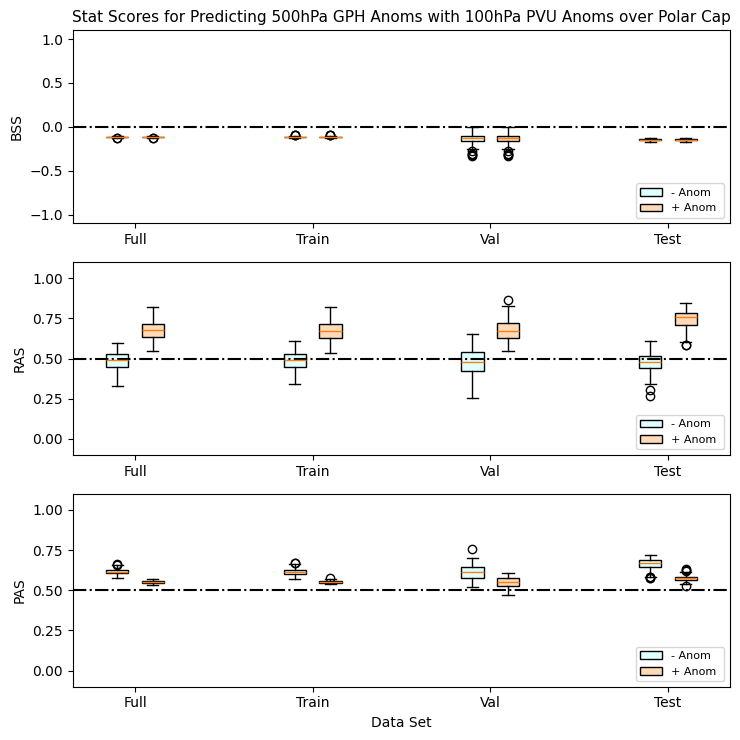

In [52]:
#plot
fig = plt.figure(figsize=(7.5,7.5))
font = 10
#loop through each member
ax1 = plt.subplot(3,1,1)
ax2 = plt.subplot(3,1,2)
ax3 = plt.subplot(3,1,3)

ticks = ['Full', 'Train', 'Val', 'Test'] #set tick numbers for dataset
colors = ['lightcyan','peachpuff']
ind = [2, 4, 6, 8]  # the x locations for the groups
w = 0.25 #box-plot width
labels = ['- Anom', '+ Anom '] #labels of quantiles


##begin to go plot by plot ...
#each plot has a separate plot function for each lead time. In these, the plots get each quantile plotted. 
ax1.set_title("Stat Scores for Predicting 500hPa GPH Anoms with 100hPa PVU Anoms over Polar Cap",fontsize = 11) 

a1_0 = ax1.boxplot([BSS_all[:,0],BSS_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a1_5 = ax1.boxplot([BSS_train[:,0],BSS_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a1_10 = ax1.boxplot([BSS_val[:,0],BSS_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a1_14 = ax1.boxplot([BSS_test[:,0],BSS_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax1.axhline(0, c='k', ls ='-.')
ax1.set_xticks(ind, ticks)
#next few lines color the box plot faces
for bplot in (a1_0, a1_5, a1_10, a1_14,):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a1_0['boxes'], labels):
    patch.set_label(label)
#ax1.set_title('BSS for Temperature Region',fontsize = 14)
ax1.set_ylim(-1.1,1.1)
#ax1.set_xlabel('Data Set',fontsize = 14)
ax1.set_ylabel('BSS',fontsize = font)
ax1.tick_params(axis='both', which='major', labelsize= font)
ax1.legend(loc = 'lower right', fontsize = 8)
ax1.set_aspect('auto') ;

##repeat the process
a2_0 = ax2.boxplot([Rec_all[:,0],Rec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a2_5 = ax2.boxplot([Rec_train[:,0],Rec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a2_10 = ax2.boxplot([Rec_val[:,0],Rec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a2_14 = ax2.boxplot([Rec_test[:,0],Rec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax2.axhline(0.5, c='k', ls ='-.')
ax2.set_xticks(ind, ticks)
for bplot in (a2_0, a2_5, a2_10, a2_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a2_0['boxes'], labels):
    patch.set_label(label)
#ax2.set_title('RAS for Temperature Region',fontsize = 14)
ax2.set_ylim(-0.1,1.1)
ax2.tick_params(axis='both', which='major', labelsize= font)
ax2.set_ylabel('RAS',fontsize = font)
#ax2.set_xlabel('Data Set',fontsize = 14)
#ax2.set_ylabel('Brier Skill Score')
ax2.legend(loc = 'lower right', fontsize = 8)
ax2.set_aspect('auto') ;

a3_0 = ax3.boxplot([Prec_all[:,0],Prec_all[:,1]], positions= [1.8,2.2], widths=w, patch_artist=True)
a3_5 = ax3.boxplot([Prec_train[:,0],Prec_train[:,1]], positions=[3.8,4.2], widths=w, patch_artist=True)
a3_10 = ax3.boxplot([Prec_val[:,0],Prec_val[:,1]], positions=[5.8,6.2], widths=w, patch_artist=True)
a3_14 = ax3.boxplot([Prec_test[:,0],Prec_test[:,1]], positions=[7.8,8.2], widths=w, patch_artist=True)
ax3.axhline(0.5, c='k', ls ='-.')
ax3.set_xticks(ind, ticks)
for bplot in (a3_0, a3_5, a3_10, a3_14):
    for patch, color in zip(bplot['boxes'], colors):
        patch.set_facecolor(color)
for patch, label in zip(a3_0['boxes'], labels):
    patch.set_label(label)
#ax3.set_title('RAS Well')
#ax3.set_title('PAS for Temperature Region',fontsize = 14)
ax3.set_ylim(-0.1,1.1)
ax3.set_ylabel('PAS',fontsize = font)
ax3.set_xlabel('Data Set',fontsize = font)
#ax3.set_ylabel('Recall Accuracy Score',fontsize = 14)
ax3.tick_params(axis='both', which='major', labelsize= font)
ax3.legend(loc = 'lower right', fontsize = 8)
ax3.set_aspect('auto') ;

plt.tight_layout()
#plt.show()
plt.savefig("1204_PVU100_StatScore.png", bbox_inches='tight',dpi =150)


In [ ]:
#lat
lats = np.arange(90, 62.5, -2.5)
#lon
lons = np.arange(0, 362.5, 2.5)

In [ ]:
# plot the original data 
color = 'twilight' 
colorbarMin = 0
colorbarMax = 1
colorspace = 0.05
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
def define_map():
    from matplotlib.path import Path

    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.coastlines()

    # From example: http://scitools.org.uk/cartopy/docs/latest/examples/always_circular_stereo.html
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    return(fig, ax)
    

fig, ax = define_map()
title = 'Frequency LRP of 100hPa PVU associated with 10% Most Confident + 500hPa GPH Anomaly Predictions'
plt.title(title,fontsize=11)
plt.contourf(lons,lats,np.nanmean(pos90_LRP,axis=0),level,transform=ccrs.PlateCarree(), cmap=color)
plt.colorbar(orientation = 'horizontal', shrink=1,fraction=0.1,pad=0.05,aspect=35, label="Frequency")
plt.show()
#Set a title for your map:
plt.savefig("1122_PosPVU100_LRP.png", bbox_inches='tight')

In [ ]:
# plot the original data 
color = 'twilight' 
colorbarMin = 0
colorbarMax = 1
colorspace = 0.05
level = np.arange(colorbarMin,colorbarMax+colorspace,colorspace)
def define_map():
    from matplotlib.path import Path

    fig = plt.figure(figsize=(7,7))
    ax = plt.axes(projection=ccrs.NorthPolarStereo())
    ax.coastlines()

    # From example: http://scitools.org.uk/cartopy/docs/latest/examples/always_circular_stereo.html
    theta = np.linspace(0, 2*np.pi, 100)
    center, radius = [0.5, 0.5], 0.5
    verts = np.vstack([np.sin(theta), np.cos(theta)]).T
    circle = Path(verts * radius + center)

    ax.set_boundary(circle, transform=ax.transAxes)
    return(fig, ax)
    

fig, ax = define_map()
title = 'Frequency LRP of 100hPa PVU associated with 10% Most Confident - 500hPa GPH Anomaly Predictions'
plt.title(title,fontsize=11)
plt.contourf(lons,lats,np.nanmean(neg90_LRP,axis=0),level,transform=ccrs.PlateCarree(), cmap=color)
plt.colorbar(orientation = 'horizontal', shrink=1,fraction=0.1,pad=0.05,aspect=35, label="Frequency")
plt.show()
plt.savefig("1122_NegPVU100_LRP.png", bbox_inches='tight')

In [53]:
##pickle out the stuff for making heat maps because I want to run it on a smaller code
##true values
pickle.dump(neg90_LRP, open("PVU100_neg90_LRP.p", 'wb'))
pickle.dump(pos90_LRP, open("PVU100_pos90_LRP.p",'wb'))

##false values
pickle.dump(Fneg90_LRP, open("PVU100_Fneg90_LRP.p",'wb'))
pickle.dump(Fpos90_LRP, open("PVU100_Fpos90_LRP.p",'wb'))

##for composites
pickle.dump(comp_pos, open("PVU100_comp_pos.p",'wb'))
pickle.dump(compFpos, open("PVU100_compFpos.p",'wb'))
pickle.dump(comp_neg, open("PVU100_comp_neg.p",'wb'))
pickle.dump(compFneg, open("PVU100_compFneg.p",'wb'))

## Percentile ACC Plots

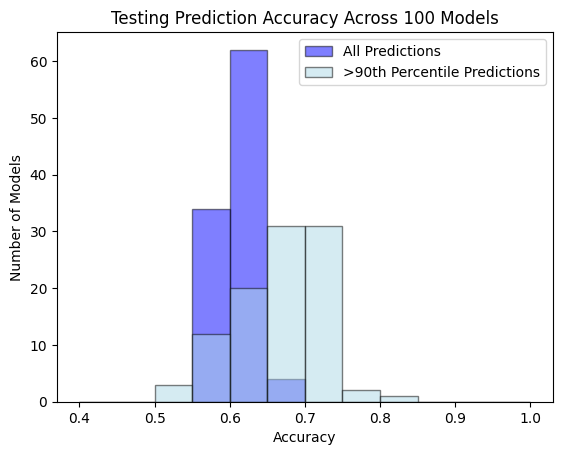

In [54]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(test90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltest_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy')
plt.ylabel('Number of Models')
plt.legend()
plt.title('Testing Prediction Accuracy Across 100 Models')
plt.savefig("PVU100_ACCtest.png", dpi = 150)
plt.show()

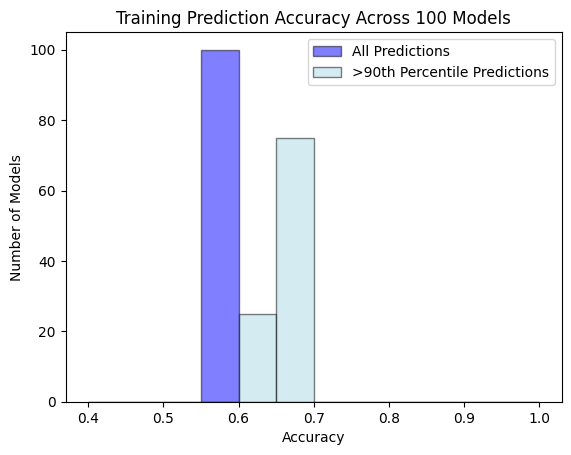

In [55]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(train90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fulltrain_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy')
plt.ylabel('Number of Models')
plt.legend()
plt.title('Training Prediction Accuracy Across 100 Models')
plt.savefig("PVU100_ACCtrain.png", dpi = 150)
plt.show()

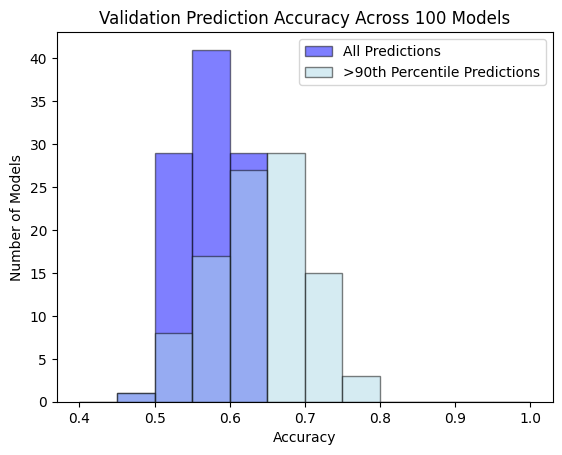

In [56]:
bins = np.linspace(0.4, 1,13)  # 10 bins from 0.4 to 1
##bin the testing 90th percentile accuracy data
counts90, edges90 = np.histogram(val90_acc, bins=bins)
countsfull, edgesfull = np.histogram(fullval_acc, bins=bins)
# Plot the full dataset
#offset = 0.02  # Adjust this value if needed for better visibility
plt.bar(edgesfull[:-1], countsfull, width=np.diff(edgesfull), 
        edgecolor='black', alpha=0.5, label='All Predictions', align='edge', color='blue')
# Plot the 90th percentile
plt.bar(edges90[:-1], counts90, width=np.diff(edges90), 
        edgecolor='black', alpha=0.5, label='>90th Percentile Predictions', align='edge', color = 'lightblue')
plt.xlabel('Accuracy')
plt.ylabel('Number of Models')
plt.legend()
plt.title('Validation Prediction Accuracy Across 100 Models')
plt.savefig("PVU100_ACCval.png", dpi = 150)
plt.show()